In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER    = "bdd100k/videos/train"
VAL_FOLDER      = "bdd100k/videos/val"
CHECKPOINT_DIR  = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Training Parameters
MAX_TRAIN_VIDS = 5  # Set to None to use all training videos
MAX_VAL_VIDS   = 5  # Set to None to use all validation videos
NUM_EPOCHS     = 20    # Increased epochs for better training
FRAME_1_SCALE  = 0.25
FRAME_2_SCALE  = 0.25
SIM_THRESHOLD  = 0.96
BATCH_SIZE     = 8     # Reduced batch size if memory allows
LEARNING_RATE  = 1e-4

# Patch Configuration
PATCH_SIZE = 10  # Each patch is 10x10 pixels

# Model Hyperparameters
EMBED_DIM  = 256  # Transformer embedding dimension
NUM_HEADS  = 8
NUM_LAYERS = 6    # Reduced layers for faster training; adjust as needed
D_FF       = 512  # Feedforward layer size
DROPOUT    = 0.1

# Original Frame Sizes
ORIG_INPUT_HEIGHT, ORIG_INPUT_WIDTH  = 1280, 720
ORIG_OUTPUT_HEIGHT, ORIG_OUTPUT_WIDTH = 1280, 720

# Scaled Frame Sizes
SCALED_INPUT_HEIGHT = int(ORIG_INPUT_HEIGHT * FRAME_1_SCALE)
SCALED_INPUT_WIDTH  = int(ORIG_INPUT_WIDTH * FRAME_1_SCALE)
SCALED_OUTPUT_HEIGHT = int(ORIG_OUTPUT_HEIGHT * FRAME_2_SCALE)
SCALED_OUTPUT_WIDTH  = int(ORIG_OUTPUT_WIDTH * FRAME_2_SCALE)

# Number of Patches
NUM_PATCHES_INPUT_H  = SCALED_INPUT_HEIGHT // PATCH_SIZE
NUM_PATCHES_INPUT_W  = SCALED_INPUT_WIDTH  // PATCH_SIZE
NUM_PATCHES_OUTPUT_H = SCALED_OUTPUT_HEIGHT // PATCH_SIZE
NUM_PATCHES_OUTPUT_W = SCALED_OUTPUT_WIDTH  // PATCH_SIZE

NUM_PATCHES_INPUT  = NUM_PATCHES_INPUT_H * NUM_PATCHES_INPUT_W
NUM_PATCHES_OUTPUT = NUM_PATCHES_OUTPUT_H * NUM_PATCHES_OUTPUT_W

assert NUM_PATCHES_INPUT == NUM_PATCHES_OUTPUT, "Input and output patch numbers must be the same."

# Patch Vector Sizes
PATCH_VECTOR_SIZE_INPUT  = 3 * PATCH_SIZE * PATCH_SIZE  # 3 channels (RGB)
PATCH_VECTOR_SIZE_OUTPUT = PATCH_VECTOR_SIZE_INPUT      # Assuming same

# Model Input and Output Sizes (Per Patch)
INPUT_SIZE  = PATCH_VECTOR_SIZE_INPUT   # 300
OUTPUT_SIZE = PATCH_VECTOR_SIZE_OUTPUT  # 300

# Print Expected Dimensions for Verification
print("\n===== FRAME & PATCH INFO =====")
print(f"Frame Size (H x W): {ORIG_INPUT_HEIGHT} x {ORIG_INPUT_WIDTH}")
print(f"Patch Size: {PATCH_SIZE} x {PATCH_SIZE}")
print(f"Num Patches (H x W): {NUM_PATCHES_INPUT_H} x {NUM_PATCHES_INPUT_W} = {NUM_PATCHES_INPUT}")

print("\n===== INPUT / OUTPUT DIMENSIONS =====")
print(f"Patch Vector Size (Flattened): {PATCH_VECTOR_SIZE_INPUT}")
print(f"Input Size to Model (Per Patch): {INPUT_SIZE}")
print(f"Output Size from Model (Per Patch): {OUTPUT_SIZE}")

print("\n===== TRANSFORMER HYPERPARAMETERS =====")
print(f"Embedding Dimension (D_MODEL): {EMBED_DIM}")
print(f"Num Attention Heads: {NUM_HEADS}")
print(f"Num Transformer Layers: {NUM_LAYERS}")
print(f"Feedforward Layer Dim: {D_FF}")
print(f"Dropout Rate: {DROPOUT}")

# ============================== Informer Model Definition ==============================

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1  = nn.Linear(d_model, d_ff)
        self.dropout   = nn.Dropout(dropout)
        self.linear2  = nn.Linear(d_ff, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Self-Attention
        src2, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        # Feedforward
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn      = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1        = nn.Linear(d_model, d_ff)
        self.dropout         = nn.Dropout(dropout)
        self.linear2        = nn.Linear(d_ff, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory):
        # Self-Attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        # Cross-Attention
        tgt2, _ = self.multihead_attn(tgt, memory, memory)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        # Feedforward
        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

def create_2d_position_encoding(num_patches_h, num_patches_w, embed_dim, device):
    """
    Generates a 2D positional encoding tensor.
    """
    pos_h = torch.arange(num_patches_h, device=device).unsqueeze(1).repeat(1, num_patches_w)
    pos_w = torch.arange(num_patches_w, device=device).unsqueeze(0).repeat(num_patches_h, 1)

    # Normalize positions
    pos_h = pos_h.float() / num_patches_h
    pos_w = pos_w.float() / num_patches_w

    # Flatten grid into (num_patches, 2)
    pos = torch.cat([pos_h.unsqueeze(-1), pos_w.unsqueeze(-1)], dim=-1).view(-1, 2)

    # Initialize positional encoding tensor
    pe = torch.zeros(pos.size(0), embed_dim, device=device)

    # Apply sine and cosine functions
    div_term = torch.exp(torch.arange(0, embed_dim // 2, device=device).float() * (-np.log(10000.0) / (embed_dim // 2)))
    pe[:, 0::2] = torch.sin(pos[:, 0].unsqueeze(1) * div_term)
    pe[:, 1::2] = torch.cos(pos[:, 1].unsqueeze(1) * div_term)

    return pe  # Shape: (num_patches, embed_dim)

class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model, n_heads, d_ff, num_layers, dropout, num_patches_h, num_patches_w):
        super().__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoding     = create_2d_position_encoding(num_patches_h, num_patches_w, d_model, device)
        self.layers           = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout          = nn.Dropout(dropout)

    def forward(self, src):
        """
        src: (num_patches, batch_size, input_size)
        """
        src = self.input_projection(src)  # (num_patches, batch_size, d_model)
        src = src + self.pos_encoding.unsqueeze(1)  # Add positional encoding
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src)
        return src

class InformerDecoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, num_layers, dropout, output_size, num_patches_h, num_patches_w):
        super().__init__()
        self.target_projection = nn.Linear(output_size, d_model)
        self.pos_encoding      = create_2d_position_encoding(num_patches_h, num_patches_w, d_model, device)
        self.layers            = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.output_layer      = nn.Linear(d_model, output_size)

    def forward(self, tgt, memory):
        """
        tgt: (num_patches, batch_size, output_size)
        memory: (num_patches, batch_size, d_model)
        """
        tgt = self.target_projection(tgt)  # (num_patches, batch_size, d_model)
        tgt = tgt + self.pos_encoding.unsqueeze(1)  # Add positional encoding
        for layer in self.layers:
            tgt = layer(tgt, memory)
        out = self.output_layer(tgt)  # (num_patches, batch_size, output_size)
        return out

class Informer(nn.Module):
    def __init__(self, input_size, d_model, n_heads, d_ff, num_layers, dropout, output_size, num_patches_h, num_patches_w):
        super().__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout, num_patches_h, num_patches_w)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size, num_patches_h, num_patches_w)

    def forward(self, src, tgt):
        """
        src: (num_patches, batch_size, input_size)
        tgt: (num_patches, batch_size, output_size)
        """
        memory = self.encoder(src)
        out    = self.decoder(tgt, memory)
        return out

# ============================== Initialize the Model ==============================
model = Informer(
    input_size      = INPUT_SIZE,  # 300
    d_model         = EMBED_DIM,   # 256
    n_heads         = NUM_HEADS,   # 8
    d_ff            = D_FF,        # 512
    num_layers      = NUM_LAYERS,  # 6
    dropout         = DROPOUT,     # 0.1
    output_size     = OUTPUT_SIZE, # 300
    num_patches_h   = NUM_PATCHES_INPUT_H,
    num_patches_w   = NUM_PATCHES_INPUT_W
).to(device)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.MultiheadAttention):
        nn.init.xavier_uniform_(m.out_proj.weight)
        if m.out_proj.bias is not None:
            nn.init.zeros_(m.out_proj.bias)

model.apply(init_weights)
print("[Info] Model initialized and weights set.")

# ============================== Loss and Optimizer ==============================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("[Info] Loss function and optimizer defined.")

# ============================== Custom Dataset Definition ==============================

class PatchPairDataset(Dataset):
    def __init__(self, pairs):
        """
        pairs: List of tuples (input_patches, target_patches)
               Each input_patches and target_patches are numpy arrays of shape (num_patches, embed_dim)
        """
        self.input_patches  = [torch.tensor(inp, dtype=torch.float32) for inp, _ in pairs]
        self.target_patches = [torch.tensor(tgt, dtype=torch.float32) for _, tgt in pairs]

    def __len__(self):
        return len(self.input_patches)

    def __getitem__(self, idx):
        inp = self.input_patches[idx]   # Shape: (num_patches, embed_dim)
        tgt = self.target_patches[idx]  # Shape: (num_patches, embed_dim)
        return inp, tgt

# ============================== Data Preparation ==============================

def frame_similarity(img1, img2):
    """
    Compute frame similarity based on absolute pixel difference.
    Returns similarity percentage.
    """
    img1 = img1.cpu().numpy() if isinstance(img1, torch.Tensor) else img1
    img2 = img2.cpu().numpy() if isinstance(img2, torch.Tensor) else img2

    if len(img1.shape) == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    if len(img2.shape) == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    diff = cv2.absdiff(img1, img2)
    similarity = 100 - (np.sum(diff) / (img1.shape[0] * img1.shape[1] * 255) * 100)
    return similarity

def split_into_patches(tensor, patch_size):
    """
    Split a tensor into non-overlapping patches.
    tensor: (C, H, W)
    Returns:
        patches: (num_patches, C, patch_size, patch_size)
    """
    C, H, W = tensor.shape
    patches = tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.permute(1, 2, 0, 3, 4).contiguous()
    return patches.view(-1, C, patch_size, patch_size)  # (num_patches, C, patch_size, patch_size)

def prepare_video_for_model(mov_path, threshold=0.95):
    """
    Processes video frames into input-output patch pairs.
    Returns a list of tuples: [(input_patches, target_patches), ...]
    """
    device_local = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Retrieve all frames from the video
    cap = cv2.VideoCapture(mov_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()

    if len(frames) < 2:
        return []

    # 2) Build (input -> output) pairs based on similarity
    pairs = []
    for i in range(len(frames) - 1):
        f1, f2 = frames[i], frames[i + 1]

        # Compute similarity
        sim = frame_similarity(f1, f2)
        if sim < threshold:
            continue  # Skip if frames are not similar enough

        # Convert to tensors
        f1_tensor = torch.from_numpy(f1).permute(2, 0, 1).float().unsqueeze(0).to(device_local)  # (1, 3, H, W)
        f2_tensor = torch.from_numpy(f2).permute(2, 0, 1).float().unsqueeze(0).to(device_local)

        # Scale frames
        f1_scaled = F.interpolate(f1_tensor, size=(SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH), mode='bilinear', align_corners=False).squeeze(0) / 255.0  # (3, H, W)
        f2_scaled = F.interpolate(f2_tensor, size=(SCALED_OUTPUT_HEIGHT, SCALED_OUTPUT_WIDTH), mode='bilinear', align_corners=False).squeeze(0) / 255.0

        # Split into patches
        f1_patches = split_into_patches(f1_scaled, PATCH_SIZE)  # (num_patches, 3, 10, 10)
        f2_patches = split_into_patches(f2_scaled, PATCH_SIZE)  # (num_patches, 3, 10, 10)

        # Flatten patches
        f1_patches_flat  = f1_patches.view(NUM_PATCHES_INPUT, -1)  # (576, 300)
        f2_patches_flat  = f2_patches.view(NUM_PATCHES_OUTPUT, -1)  # (576, 300)

        # Convert to NumPy and append pairs
        np_in  = f1_patches_flat.cpu().numpy()  # (576, 300)
        np_out = f2_patches_flat.cpu().numpy()  # (576, 300)
        pairs.append((np_in, np_out))

    return pairs

# ============================== Training & Validation Functions ==============================

def train_on_dataset(dataset):
    """
    Trains the model on the given dataset.
    """
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    model.train()
    loss_sum = 0.0
    loss_count = 0

    for in_batch, out_batch in loader:
        in_batch  = in_batch.to(device)   # (batch_size, num_patches, embed_dim)
        out_batch = out_batch.to(device)  # (batch_size, num_patches, embed_dim)

        batch_size, num_patches, embed_dim = in_batch.shape

        # Reshape to (num_patches, batch_size, embed_dim)
        in_seq  = in_batch.permute(1, 0, 2)   # (576, batch_size, 256)
        out_seq = out_batch.permute(1, 0, 2)  # (576, batch_size, 256)

        optimizer.zero_grad()
        pred = model(in_seq, out_seq)         # (576, batch_size, 256)
        loss = criterion(pred, out_seq)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        loss_count += 1

    avg_loss = loss_sum / loss_count if loss_count else 0.0
    return avg_loss

def val_on_dataset(dataset):
    """
    Validates the model on the given dataset.
    """
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    model.eval()
    loss_sum = 0.0
    loss_count = 0

    with torch.no_grad():
        for vin, vout in loader:
            vin  = vin.to(device)   # (batch_size, num_patches, embed_dim)
            vout = vout.to(device)  # (batch_size, num_patches, embed_dim)

            batch_size, num_patches, embed_dim = vin.shape

            # Reshape to (num_patches, batch_size, embed_dim)
            vin_seq  = vin.permute(1, 0, 2)   # (576, batch_size, 256)
            vout_seq = vout.permute(1, 0, 2)  # (576, batch_size, 256)

            pred = model(vin_seq, vout_seq)  # (576, batch_size, 256)
            loss = criterion(pred, vout_seq)

            loss_sum += loss.item()
            loss_count += 1

    avg_loss = loss_sum / loss_count if loss_count else 0.0
    return avg_loss

def save_checkpoint(epoch):
    """
    Saves the model checkpoint.
    """
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"informer_patches_epoch_{epoch}.pth")
    torch.save({
        'epoch'               : epoch,
        'model_state_dict'    : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, ckpt_path)
    print(f"[Info] Checkpoint saved at epoch {epoch}.")

# ============================== Training Loop ==============================

# Gather Training and Validation Videos
train_movs = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith('.mov')]
train_movs.sort()

val_movs = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith('.mov')]
val_movs.sort()

# Limit the number of videos for faster training
if MAX_TRAIN_VIDS is not None:
    train_movs = train_movs[:MAX_TRAIN_VIDS]

if MAX_VAL_VIDS is not None:
    val_movs = val_movs[:MAX_VAL_VIDS]

print(f"\n[Info] Number of training videos: {len(train_movs)}")
print(f"[Info] Number of validation videos: {len(val_movs)}")

# Initialize Plotting Variables
train_losses = []
val_losses   = []

# Training Loop
for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    # Training Phase
    train_pairs = []
    with tqdm(train_movs, desc=f"Epoch [{epoch}/{NUM_EPOCHS}] - Training", unit="video") as train_pbar:
        for file_name in train_pbar:
            mov_path = os.path.join(TRAIN_FOLDER, file_name)
            frame_pairs = prepare_video_for_model(mov_path, SIM_THRESHOLD)
            if len(frame_pairs) == 0:
                print(f"[Warning] No valid frame pairs found in {file_name}. Skipping.")
                continue
            train_pairs.extend(frame_pairs)

    if not train_pairs:
        print("[Warning] No training pairs found for this epoch.")
        avg_train_loss = float('inf')
    else:
        train_dataset = PatchPairDataset(train_pairs)
        avg_train_loss = train_on_dataset(train_dataset)
        print(f"[Epoch {epoch}] Training Loss: {avg_train_loss:.6f}")

    train_losses.append(avg_train_loss)

    # Validation Phase
    val_pairs = []
    with tqdm(val_movs, desc=f"Epoch [{epoch}/{NUM_EPOCHS}] - Validation", unit="video") as val_pbar:
        for fname in val_pbar:
            mov_path = os.path.join(VAL_FOLDER, fname)
            frame_pairs = prepare_video_for_model(mov_path, SIM_THRESHOLD)
            if len(frame_pairs) == 0:
                print(f"[Warning] No valid frame pairs found in {fname}. Skipping.")
                continue
            val_pairs.extend(frame_pairs)

    if not val_pairs:
        print("[Warning] No validation pairs found for this epoch.")
        avg_val_loss = float('inf')
    else:
        val_dataset = PatchPairDataset(val_pairs)
        avg_val_loss = val_on_dataset(val_dataset)
        print(f"[Epoch {epoch}] Validation Loss: {avg_val_loss:.6f}")

    val_losses.append(avg_val_loss)

    # Save Checkpoint
    save_checkpoint(epoch)

    # Log Time Taken
    elapsed_time = time.time() - start_time
    print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f}s\n")

# ============================== Plot Training Curves ==============================

e_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(10, 6))
plt.plot(e_range, train_losses, label='Train Loss', marker='o')
plt.plot(e_range, val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Informer Model Training Progress')
plt.legend()
plt.grid(True)
plt.show()

print("[Info] Training completed.")


## CNN + Transformer

In [ ]:
# train_cnn_transformer.py

import os
import cv2
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")

# Enable CUDNN benchmark for optimized performance on fixed-size inputs
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER    = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER      = "bdd100k/videos/val"    # Path to validation videos
CHECKPOINT_DIR  = "checkpoints"           # Directory to save checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ============================== Training Parameters ==============================
FRAME_SCALE_INPUT  = 0.25  # Scaling factor for input frames
FRAME_SCALE_OUTPUT = 0.5   # Scaling factor for output frames (upscaling by 2)
NUM_EPOCHS         = 20    # Number of training epochs
SIM_THRESHOLD      = 0.96  # Frame similarity threshold to create pairs
BATCH_SIZE         = 8     # Adjust based on GPU memory
LEARNING_RATE      = 1e-4

# ============================== Original Frame Sizes ==============================
ORIG_INPUT_HEIGHT, ORIG_INPUT_WIDTH  = 1280, 720
ORIG_OUTPUT_HEIGHT, ORIG_OUTPUT_WIDTH = 1280, 720

# ============================== Scaled Frame Sizes ==============================
SCALED_INPUT_HEIGHT  = int(ORIG_INPUT_HEIGHT * FRAME_SCALE_INPUT)
SCALED_INPUT_WIDTH   = int(ORIG_INPUT_WIDTH * FRAME_SCALE_INPUT)
SCALED_OUTPUT_HEIGHT = int(ORIG_OUTPUT_HEIGHT * FRAME_SCALE_OUTPUT)
SCALED_OUTPUT_WIDTH  = int(ORIG_OUTPUT_WIDTH * FRAME_SCALE_OUTPUT)

# Print Expected Dimensions for Verification
print("\n===== FRAME INFO =====")
print(f"Original Input Frame Size (H x W): {ORIG_INPUT_HEIGHT} x {ORIG_INPUT_WIDTH}")
print(f"Original Output Frame Size (H x W): {ORIG_OUTPUT_HEIGHT} x {ORIG_OUTPUT_WIDTH}")
print(f"Scaled Input Frame Size (H x W): {SCALED_INPUT_HEIGHT} x {SCALED_INPUT_WIDTH}")
print(f"Scaled Output Frame Size (H x W): {SCALED_OUTPUT_HEIGHT} x {SCALED_OUTPUT_WIDTH}")

# ============================== Model Definition ==============================

class CNNEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)  # (B, 64, H/2, W/2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, embed_dim, kernel_size=3, stride=2, padding=1)  # (B, embed_dim, H/4, W/4)
        self.bn2 = nn.BatchNorm2d(embed_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)  # (B, 64, H/2, W/2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)  # (B, embed_dim, H/4, W/4)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=60000):  # increased max_len to 60000
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)
    def forward(self, x):
        if x.size(0) > self.pe.size(0):
            raise ValueError(f"Sequence length {x.size(0)} exceeds maximum {self.pe.size(0)}.")
        return x + self.pe[:x.size(0), :]


class TransformerModule(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=3, dim_feedforward=256, dropout=0.1):
        super(TransformerModule, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Use the updated maximum length here:
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=60000)
        self.embed_dim = embed_dim
    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return x


class CNNDecoder(nn.Module):
    def __init__(self, embed_dim=256, output_channels=3):
        super(CNNDecoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(
            embed_dim, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # (B, 128, H/2, W/2)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # (B, 64, H, W)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.deconv3 = nn.ConvTranspose2d(
            64, output_channels, kernel_size=7, stride=2, padding=3, output_padding=1
        )  # (B, 3, 2H, 2W)
        self.sigmoid = nn.Sigmoid()  # Ensures output is in [0,1]

    def forward(self, x):
        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.relu(x)  # (B, 128, H/2, W/2)
        
        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.relu(x)  # (B, 64, H, W)
        
        x = self.deconv3(x)
        x = self.sigmoid(x)  # (B, 3, 2H, 2W)
        return x

class CNN_Transformer_Model(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, num_layers=6, dim_feedforward=512, dropout=0.1):
        super(CNN_Transformer_Model, self).__init__()
        self.encoder = CNNEncoder(embed_dim)
        self.transformer = TransformerModule(embed_dim, num_heads, num_layers, dim_feedforward, dropout)
        self.decoder = CNNDecoder(embed_dim)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, 3, H, W)
        Returns:
            Reconstructed tensor of shape (batch_size, 3, 2H, 2W)
        """
        batch_size = x.size(0)
        encoded = self.encoder(x)  # (B, embed_dim, H/4, W/4)

        # Capture spatial dimensions
        H_4, W_4 = encoded.size(2), encoded.size(3)  # H/4, W/4

        # Flatten spatial dimensions to create a sequence
        seq_len = H_4 * W_4
        encoded = encoded.view(batch_size, encoded.size(1), seq_len)  # (B, embed_dim, seq_len)
        encoded = encoded.permute(2, 0, 1)  # (seq_len, B, embed_dim)

        # Transformer
        transformed = self.transformer(encoded)  # (seq_len, B, embed_dim)

        # Reshape back to feature maps
        transformed = transformed.permute(1, 2, 0)  # (B, embed_dim, seq_len)
        transformed = transformed.view(batch_size, -1, H_4, W_4)  # (B, embed_dim, H/4, W/4)

        # Decoder
        reconstructed = self.decoder(transformed)  # (B, 3, 2H, 2W)
        return reconstructed

# ============================== Initialize the Model ==============================

model = CNN_Transformer_Model(embed_dim=256, num_heads=8, num_layers=6, dim_feedforward=512, dropout=0.1).to(device)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if isinstance(m.bias, torch.Tensor):
            nn.init.zeros_(m.bias)

model.apply(init_weights)
print("[Info] Model initialized and weights set.")

# ============================== Loss and Optimizer ==============================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("[Info] Loss function and optimizer defined.")

# ============================== Mixed Precision Training Setup ==============================
scaler = GradScaler()

# ============================== Custom Dataset Definition ==============================

class FramePairDataset(Dataset):
    def __init__(self, frame_pairs):
        """
        Args:
            frame_pairs: List of tuples (input_frame, target_frame)
                         Each frame is a numpy array of shape (C, H, W) with values in [0,1]
        """
        self.input_frames  = [torch.tensor(inp, dtype=torch.float32) for inp, _ in frame_pairs]
        self.target_frames = [torch.tensor(tgt, dtype=torch.float32) for _, tgt in frame_pairs]

    def __len__(self):
        return len(self.input_frames)

    def __getitem__(self, idx):
        return self.input_frames[idx], self.target_frames[idx]

# ============================== Data Preparation ==============================

def frame_similarity(img1, img2):
    """
    Computes similarity between two frames based on absolute pixel difference.
    Returns similarity percentage.
    """
    img1 = img1.cpu().numpy() if isinstance(img1, torch.Tensor) else img1
    img2 = img2.cpu().numpy() if isinstance(img2, torch.Tensor) else img2

    if len(img1.shape) == 3:
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    else:
        img1_gray = img1

    if len(img2.shape) == 3:
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    else:
        img2_gray = img2

    diff = cv2.absdiff(img1_gray, img2_gray)
    similarity = 100 - (np.sum(diff) / (img1_gray.shape[0] * img1_gray.shape[1] * 255) * 100)
    return similarity

def prepare_video_for_model(video_path, threshold=0.95):
    """
    Processes video frames into input-output frame pairs based on similarity.
    Args:
        video_path (str): Path to the video file.
        threshold (float): Minimum similarity to consider frames as a pair.
    Returns:
        List of tuples: [(input_frame, target_frame), ...]
    """
    device_local = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Retrieve all frames from the video
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()

    if len(frames) < 2:
        return []

    # 2) Build (input -> output) pairs based on similarity
    pairs = []
    for i in range(len(frames) - 1):
        f1, f2 = frames[i], frames[i + 1]

        # Compute similarity
        sim = frame_similarity(f1, f2)
        if sim < threshold:
            continue  # Skip if frames are not similar enough

        # Convert to tensors and normalize
        f1_tensor = torch.from_numpy(f1).permute(2, 0, 1).float().to(device_local) / 255.0  # (3, H, W)
        f2_tensor = torch.from_numpy(f2).permute(2, 0, 1).float().to(device_local) / 255.0  # (3, H, W)

        # Scale frames
        f1_scaled = F.interpolate(
            f1_tensor.unsqueeze(0),
            size=(SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)  # (3, H, W)

        f2_scaled = F.interpolate(
            f2_tensor.unsqueeze(0),
            size=(SCALED_OUTPUT_HEIGHT, SCALED_OUTPUT_WIDTH),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)  # (3, H, W)

        # Append to pairs list
        pairs.append((f1_scaled.cpu().numpy(), f2_scaled.cpu().numpy()))

    return pairs

# ============================== Training & Validation Functions ==============================

def train_on_dataset(model, loader, criterion, optimizer, scaler, device):
    """
    Trains the model on the given dataset.
    Args:
        model (nn.Module): The CNN-Transformer model.
        loader (DataLoader): DataLoader for training data.
        criterion: Loss function.
        optimizer: Optimizer.
        scaler: Gradient scaler for mixed precision.
        device: CUDA device.
    Returns:
        float: Average training loss.
    """
    model.train()
    loss_sum = 0.0
    loss_count = 0

    for in_batch, out_batch in tqdm(loader, desc="Training Batches", unit="batch"):
        in_batch  = in_batch.to(device, non_blocking=True)   # (B, 3, H, W)
        out_batch = out_batch.to(device, non_blocking=True)  # (B, 3, 2H, 2W)

        optimizer.zero_grad()
        with autocast():
            pred = model(in_batch)  # (B, 3, 2H, 2W)
            loss = criterion(pred, out_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item()
        loss_count += 1

    avg_loss = loss_sum / loss_count if loss_count else 0.0
    return avg_loss

def validate_on_dataset(model, loader, criterion, device):
    """
    Validates the model on the given dataset.
    Args:
        model (nn.Module): The CNN-Transformer model.
        loader (DataLoader): DataLoader for validation data.
        criterion: Loss function.
        device: CUDA device.
    Returns:
        float: Average validation loss.
    """
    model.eval()
    loss_sum = 0.0
    loss_count = 0

    with torch.no_grad():
        for in_batch, out_batch in tqdm(loader, desc="Validation Batches", unit="batch"):
            in_batch  = in_batch.to(device, non_blocking=True)   # (B, 3, H, W)
            out_batch = out_batch.to(device, non_blocking=True)  # (B, 3, 2H, 2W)

            with autocast():
                pred = model(in_batch)  # (B, 3, 2H, 2W)
                loss = criterion(pred, out_batch)

            loss_sum += loss.item()
            loss_count += 1

    avg_loss = loss_sum / loss_count if loss_count else 0.0
    return avg_loss

def save_checkpoint(epoch, model, optimizer, scaler, best_val_loss, checkpoint_dir="checkpoints"):
    """
    Saves the model checkpoint.
    Args:
        epoch (int): Current epoch number.
        model (nn.Module): The CNN-Transformer model.
        optimizer: Optimizer.
        scaler: Gradient scaler.
        best_val_loss (float): Best validation loss achieved so far.
        checkpoint_dir (str): Directory to save checkpoints.
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    ckpt_path = os.path.join(checkpoint_dir, f"cnn_transformer_epoch_{epoch}.pth")
    torch.save({
        'epoch'               : epoch,
        'model_state_dict'    : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict'   : scaler.state_dict(),
        'best_val_loss'       : best_val_loss
    }, ckpt_path)
    print(f"[Info] Checkpoint saved at epoch {epoch} with validation loss {best_val_loss:.6f}.")

# ============================== Training Loop ==============================

def main_training():
    # Gather Training and Validation Videos
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    train_videos.sort()

    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    val_videos.sort()

    # Limit the number of videos if specified
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]

    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]

    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    print(f"[Info] Number of validation videos: {len(val_videos)}")

    # Initialize Tracking Variables
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Training Loop
    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()

        # ------------------------------ Training Phase ------------------------------
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        train_pairs = []
        for video_file in tqdm(train_videos, desc="Processing Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            frame_pairs = prepare_video_for_model(video_path, SIM_THRESHOLD)
            if not frame_pairs:
                print(f"[Warning] No valid frame pairs found in {video_file}. Skipping.")
                continue
            train_pairs.extend(frame_pairs)

        print(f"[Info] Number of training frame pairs: {len(train_pairs)}")
        if not train_pairs:
            print("[Warning] No training pairs found for this epoch.")
            avg_train_loss = float('inf')
        else:
            train_dataset = FramePairDataset(train_pairs)
            train_loader = DataLoader(
                train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=0,          # Set num_workers=0 for Windows
                pin_memory=True
            )
            avg_train_loss = train_on_dataset(model, train_loader, criterion, optimizer, scaler, device)
            print(f"[Epoch {epoch}] Average Training Loss: {avg_train_loss:.6f}")

        train_losses.append(avg_train_loss)

        # ------------------------------ Validation Phase ------------------------------
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Validation Phase")
        val_pairs = []
        for video_file in tqdm(val_videos, desc="Processing Validation Videos", unit="video"):
            video_path = os.path.join(VAL_FOLDER, video_file)
            frame_pairs = prepare_video_for_model(video_path, SIM_THRESHOLD)
            if not frame_pairs:
                print(f"[Warning] No valid frame pairs found in {video_file}. Skipping.")
                continue
            val_pairs.extend(frame_pairs)

        print(f"[Info] Number of validation frame pairs: {len(val_pairs)}")
        if not val_pairs:
            print("[Warning] No validation pairs found for this epoch.")
            avg_val_loss = float('inf')
        else:
            val_dataset = FramePairDataset(val_pairs)
            val_loader = DataLoader(
                val_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False,
                num_workers=0,          # Set num_workers=0 for Windows
                pin_memory=True
            )
            avg_val_loss = validate_on_dataset(model, val_loader, criterion, device)
            print(f"[Epoch {epoch}] Average Validation Loss: {avg_val_loss:.6f}")

        val_losses.append(avg_val_loss)

        # ------------------------------ Checkpointing ------------------------------
        # if avg_val_loss < best_val_loss:
        #     best_val_loss = avg_val_loss
        #     save_checkpoint(epoch, model, optimizer, scaler, best_val_loss, CHECKPOINT_DIR)
        #     print(f"[Info] New best model saved at epoch {epoch} with validation loss {best_val_loss:.6f}.")
        best_val_loss = avg_val_loss
        save_checkpoint(epoch, model, optimizer, scaler, best_val_loss, CHECKPOINT_DIR)
        print(f"[Info] New best model saved at epoch {epoch} with validation loss {best_val_loss:.6f}.")
        
        # ------------------------------ Logging ------------------------------
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    # ============================== Plot Loss Curves ==============================
    e_range = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(e_range, train_losses, label='Training Loss', marker='o')
    plt.plot(e_range, val_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


## VAE + TRANSFORMER

In [ ]:
#!/usr/bin/env python
# train_vae_transformer.py

import os
import cv2
import math
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# ============================== Global Flags and Hyperparameters ==============================
RUN_VALIDATION = False               # Set to False to skip validation and speed up training.
TEACHER_FORCING_RATIO = 0.5           # (Not used in this implementation but available for future modifications)
lambda_recon = 1.0                    # Weight for reconstruction (L1) loss.
lambda_latent = 1.0                   # Weight for latent prediction (MSE) loss.
lambda_kl = 0.001                     # Weight for KL divergence loss.

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER = "bdd100k/videos/val"      # Path to validation videos
CHECKPOINT_DIR = "checkpoints"         # Directory to save checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MAX_TRAIN_VIDS = 10   # Limit number of training videos
MAX_VAL_VIDS = 10     # Limit number of validation videos

# ============================== Training Parameters ==============================
# Use scaling factors: 0.5 yields target size of 640x360.
FRAME_SCALE_INPUT = 0.5  
FRAME_SCALE_OUTPUT = 0.5  
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
BUFFER_SIZE = 50     # Number of frames to unroll (transitions) per rolling chunk

# ============================== Original and Target Frame Sizes ==============================
ORIG_HEIGHT, ORIG_WIDTH = 720, 1280
SCALED_INPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_INPUT)    # e.g., 360
SCALED_INPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_INPUT)     # e.g., 640
SCALED_OUTPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_OUTPUT)   # e.g., 360
SCALED_OUTPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_OUTPUT)    # e.g., 640
TARGET_SIZE = (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH)

print("\n===== FRAME INFO =====")
print(f"Original Frame Size: {ORIG_HEIGHT} x {ORIG_WIDTH}")
print(f"Target Frame Size: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")

# ============================== Model Definition ==============================
latent_dim = 128  # Reduced latent dimension for memory savings.

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=60000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
    def forward(self, x):
        if x.size(0) > self.pe.size(0):
            raise ValueError(f"Sequence length {x.size(0)} exceeds maximum {self.pe.size(0)}.")
        return x + self.pe[:x.size(0), :]

# VAE Encoder: Reduced channels.
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAEEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),    # (B,32,H/2,W/2)
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),   # (B,64,H/4,W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),  # (B,128,H/8,W/8)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        # Here, H and W become SCALED_INPUT_HEIGHT/8 and SCALED_INPUT_WIDTH/8, respectively.
        self.fc_mu = nn.Linear(128 * (SCALED_INPUT_HEIGHT // 8) * (SCALED_INPUT_WIDTH // 8), latent_dim)
        self.fc_logvar = nn.Linear(128 * (SCALED_INPUT_HEIGHT // 8) * (SCALED_INPUT_WIDTH // 8), latent_dim)
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        # Clamp logvar to prevent exploding values (which can result in NaN losses)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

# VAE Decoder: Reduced channels.
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * (SCALED_INPUT_HEIGHT // 8) * (SCALED_INPUT_WIDTH // 8))
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # Upsample by factor 2
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # Upsample by factor 2
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),      # Upsample by factor 2 to get original resolution
            nn.Sigmoid(),  # Sigmoid ensures outputs are in [0,1]
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 128, (SCALED_INPUT_HEIGHT // 8), (SCALED_INPUT_WIDTH // 8))
        x = self.deconv(x)
        return x

# Transformer Module
class LatentTransformer(nn.Module):
    def __init__(self, latent_dim=128, num_heads=4, num_layers=3, dim_feedforward=256, dropout=0.1, max_len=100):
        super(LatentTransformer, self).__init__()
        self.pos_encoder = PositionalEncoding(latent_dim, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads,
                                                    dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    def forward(self, z_seq):
        z_seq = self.pos_encoder(z_seq)
        out = self.transformer_encoder(z_seq)
        return out

# Overall VAE-Transformer Model.
class VAE_Transformer(nn.Module):
    def __init__(self, latent_dim=128, num_heads=4, num_layers=3, dim_feedforward=256, dropout=0.1, max_len=100):
        super(VAE_Transformer, self).__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)
        self.transformer = LatentTransformer(latent_dim, num_heads, num_layers, dim_feedforward, dropout, max_len)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x_seq):
        # x_seq: (seq_len, batch, 3, H, W) with values normalized to [0,1]
        z_seq = []
        mu_seq = []
        logvar_seq = []
        for x in x_seq:
            mu, logvar = self.encoder(x)
            z = self.reparameterize(mu, logvar)
            z_seq.append(z.unsqueeze(0))
            mu_seq.append(mu.unsqueeze(0))
            logvar_seq.append(logvar.unsqueeze(0))
        z_seq = torch.cat(z_seq, dim=0)      # (seq_len, batch, latent_dim)
        mu_seq = torch.cat(mu_seq, dim=0)
        logvar_seq = torch.cat(logvar_seq, dim=0)
        # Pass the latent sequence through the transformer.
        z_trans = self.transformer(z_seq)
        return z_seq, z_trans, mu_seq, logvar_seq

# ============================== Loss Functions ==============================
def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def reconstruction_loss(x_recon, x):
    return F.l1_loss(x_recon, x)

def latent_loss(z_pred, z_true):
    return F.mse_loss(z_pred, z_true)

# ============================== Data Preparation ==============================
def process_frame(frame, target_size):
    H, W = frame.shape[:2]
    if (H, W) != target_size:
        frame = cv2.resize(frame, (target_size[1], target_size[0]))
    return frame

def prepare_video_sequence(video_path):
    """
    Load frames from a video and return raw tensors in the original [0,255] range.
    No normalization is applied here.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if len(frames) < 2:
        return None
    # Process first frame for input.
    first_frame_np = process_frame(frames[0], (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH))
    first_frame = (torch.from_numpy(np.ascontiguousarray(first_frame_np))
                        .permute(2, 0, 1)
                        .float()
                        .pin_memory())
    initial_input = first_frame  # raw image in [0,255]
    target_frames = []
    # Process subsequent frames.
    for frame in frames[1:]:
        processed = process_frame(frame, (SCALED_OUTPUT_HEIGHT, SCALED_OUTPUT_WIDTH))
        tensor_frame = (torch.from_numpy(np.ascontiguousarray(processed))
                            .permute(2, 0, 1)
                            .float()
                            .pin_memory())
        target_frames.append(tensor_frame)  # raw image in [0,255]
    return initial_input, target_frames

# ============================== Training Loop with Rolling Buffer ==============================
def train_on_video_sequence(video_path, model, optimizer, device, buffer_size=BUFFER_SIZE, teacher_forcing_ratio=TEACHER_FORCING_RATIO):
    """
    Processes the video in chunks (rolling buffer) to limit GPU memory usage.
    Each chunk contains (buffer_size + 1) frames so that we can compute buffer_size transitions.
    
    NOTE: Here we normalize the chunk just before feeding it to the model.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    initial_input, target_frames = data

    # Build a list of frames on CPU. Each element is a tensor of shape (1, 3, H, W).
    frames_list = [initial_input.unsqueeze(0)] + [tf.unsqueeze(0) for tf in target_frames]
    seq_len = len(frames_list)

    model.train()
    optimizer.zero_grad()
    scaler = GradScaler()  # For mixed precision

    total_loss = 0.0
    count_loss = 0

    # Process video in overlapping chunks
    for start in range(0, seq_len - 1, buffer_size):
        end = min(start + buffer_size + 1, seq_len)  # +1 to have target for the last frame
        # Move the current chunk from CPU to GPU and normalize by dividing by 255 so that the model sees inputs in [0,1]
        chunk = [frame.to(device, non_blocking=True) for frame in frames_list[start:end]]
        x_chunk = (torch.cat(chunk, dim=0).unsqueeze(1)) / 255.0  # shape: (chunk_len, 1, 3, H, W)

        with autocast():
            z_seq, z_trans, mu_seq, logvar_seq = model(x_chunk)
            chunk_len = z_seq.size(0)
            recon_loss = 0.0
            latent_loss_total = 0.0
            kl_loss_total = 0.0

            # Compute loss over transitions within this chunk.
            for t in range(chunk_len - 1):
                z_pred = z_trans[t]   # Predicted latent for frame t+1 (shape: [1, latent_dim])
                z_true = z_seq[t+1]   # Ground truth latent for frame t+1
                latent_loss_total += latent_loss(z_pred, z_true)
                # Decode the predicted latent to reconstruct frame t+1.
                x_recon = model.decoder(z_pred.unsqueeze(0))  # output is in [0,1]
                # Use the raw target frame normalized to [0,1]
                x_target = chunk[t+1] / 255.0
                recon_loss += reconstruction_loss(x_recon, x_target)
                kl_loss_total += kl_divergence(mu_seq[t+1], logvar_seq[t+1])
            
            loss = lambda_recon * recon_loss + lambda_latent * latent_loss_total + lambda_kl * kl_loss_total

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()
        count_loss += (chunk_len - 1)

        # Clean up to free GPU memory.
        del x_chunk, z_seq, z_trans, mu_seq, logvar_seq, chunk
        torch.cuda.empty_cache()

    avg_loss = total_loss / count_loss if count_loss > 0 else float('inf')
    return avg_loss

def validate_on_video_sequence(video_path, model, device, buffer_size=BUFFER_SIZE):
    """
    Similar to training but without gradient updates.
    
    Again, we normalize only as the data enters the model.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    initial_input, target_frames = data

    frames_list = [initial_input.unsqueeze(0)] + [tf.unsqueeze(0) for tf in target_frames]
    seq_len = len(frames_list)
    model.eval()
    total_loss = 0.0
    count_loss = 0

    with torch.no_grad():
        for start in range(0, seq_len - 1, buffer_size):
            end = min(start + buffer_size + 1, seq_len)
            chunk = [frame.to(device, non_blocking=True) for frame in frames_list[start:end]]
            x_chunk = (torch.cat(chunk, dim=0).unsqueeze(1)) / 255.0  # normalize input
            z_seq, z_trans, mu_seq, logvar_seq = model(x_chunk)
            chunk_len = z_seq.size(0)
            recon_loss = 0.0
            latent_loss_total = 0.0
            kl_loss_total = 0.0

            for t in range(chunk_len - 1):
                z_pred = z_trans[t]
                z_true = z_seq[t+1]
                latent_loss_total += latent_loss(z_pred, z_true)
                x_recon = model.decoder(z_pred.unsqueeze(0))  # output in [0,1]
                x_target = chunk[t+1] / 255.0
                recon_loss += reconstruction_loss(x_recon, x_target)
                kl_loss_total += kl_divergence(mu_seq[t+1], logvar_seq[t+1])
            
            chunk_loss = lambda_recon * recon_loss + lambda_latent * latent_loss_total + lambda_kl * kl_loss_total
            total_loss += chunk_loss.item()
            count_loss += (chunk_len - 1)

            del x_chunk, z_seq, z_trans, mu_seq, logvar_seq, chunk
            torch.cuda.empty_cache()

    avg_loss = total_loss / count_loss if count_loss > 0 else float('inf')
    return avg_loss

def main_training():
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov','.mp4','.avi'))]
    train_videos.sort()
    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov','.mp4','.avi'))]
    val_videos.sort()
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]
    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]
    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    print(f"[Info] Number of validation videos: {len(val_videos)}")
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    model = VAE_Transformer(latent_dim=latent_dim, num_heads=4, num_layers=3, 
                            dim_feedforward=256, dropout=0.1, max_len=100).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        epoch_train_loss = []
        for video_file in tqdm(train_videos, desc="Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            loss = train_on_video_sequence(video_path, model, optimizer, device, buffer_size=BUFFER_SIZE, teacher_forcing_ratio=TEACHER_FORCING_RATIO)
            if loss is not None:
                epoch_train_loss.append(loss)
        avg_train_loss = sum(epoch_train_loss) / len(epoch_train_loss) if epoch_train_loss else float('inf')
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch}] Average Training Loss: {avg_train_loss:.6f}")

        if RUN_VALIDATION:
            print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Validation Phase")
            epoch_val_loss = []
            for video_file in tqdm(val_videos, desc="Validation Videos", unit="video"):
                video_path = os.path.join(VAL_FOLDER, video_file)
                loss = validate_on_video_sequence(video_path, model, device, buffer_size=BUFFER_SIZE)
                if loss is not None:
                    epoch_val_loss.append(loss)
            avg_val_loss = sum(epoch_val_loss) / len(epoch_val_loss) if epoch_val_loss else float('inf')
            val_losses.append(avg_val_loss)
            print(f"[Epoch {epoch}] Average Validation Loss: {avg_val_loss:.6f}")
            best_val_loss = avg_val_loss
        else:
            print("[Info] Validation is turned OFF for faster training.")
            best_val_loss = 0.0

        ckpt_path = os.path.join(CHECKPOINT_DIR, f"vae_transformer_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, ckpt_path)
        print(f"[Info] Checkpoint saved at epoch {epoch} with validation loss {best_val_loss:.6f}.")
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    if RUN_VALIDATION:
        plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


## CNN + Transformer

In [ ]:
#!/usr/bin/env python
# train_cnn_transformer_frame_predictor.py

import os
import cv2
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# ============================== Global Flags and Hyperparameters ==============================
RUN_VALIDATION = False          # Set to True if you want to run validation
lambda_recon = 1.0              # Weight for reconstruction (L1) loss

# Hyperparameters for training and architecture
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
BUFFER_SIZE = 50                # Number of frames per rolling chunk
latent_dim = 256                # Dimension of the latent representation
num_heads = 4
num_layers = 3
dim_feedforward = 512
dropout = 0.1
max_len = 100                   # Maximum sequence length for positional encoding

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER = "bdd100k/videos/val"        # Path to validation videos
CHECKPOINT_DIR = "checkpoints"           # Directory to save checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MAX_TRAIN_VIDS = 10  # Limit number of training videos
MAX_VAL_VIDS = 10    # Limit number of validation videos

# ============================== Frame Size Configuration ==============================
# Original frame size
ORIG_HEIGHT, ORIG_WIDTH = 720, 1280
# Scaling factors (adjust as needed)
FRAME_SCALE_INPUT = 0.5  
FRAME_SCALE_OUTPUT = 0.5  
SCALED_INPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_INPUT)    # e.g., 360
SCALED_INPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_INPUT)      # e.g., 640
SCALED_OUTPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_OUTPUT)   # e.g., 360
SCALED_OUTPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_OUTPUT)     # e.g., 640
TARGET_SIZE = (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH)

print("\n===== FRAME INFO =====")
print(f"Original Frame Size: {ORIG_HEIGHT} x {ORIG_WIDTH}")
print(f"Target Frame Size: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")

# ============================== Positional Encoding for the Transformer ==============================
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=60000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # shape (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: (seq_len, batch, embed_dim)
        if x.size(0) > self.pe.size(0):
            raise ValueError(f"Sequence length {x.size(0)} exceeds maximum {self.pe.size(0)}.")
        return x + self.pe[:x.size(0)]

# ============================== CNN Encoder: Normalizes & Encodes Frames ==============================
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(CNNEncoder, self).__init__()
        self.conv = nn.Sequential(
            # Input: (B, 3, H, W)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),   # (B, 64, H/2, W/2)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # (B, 128, H/4, W/4)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),   # (B, 256, H/8, W/8)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        # Save the feature map shape for later use in the decoder.
        self.feature_shape = (256, SCALED_INPUT_HEIGHT // 8, SCALED_INPUT_WIDTH // 8)
        self.flatten_dim = self.feature_shape[0] * self.feature_shape[1] * self.feature_shape[2]
        self.fc = nn.Linear(self.flatten_dim, latent_dim)
        
    def forward(self, x):
        # x: (B, 3, H, W)
        features = self.conv(x)  # (B, 256, H/8, W/8)
        features_flat = features.view(features.size(0), -1)
        latent = self.fc(features_flat)  # (B, latent_dim)
        return latent

# ============================== CNN Decoder: Decodes Latents & De-normalizes ==============================
class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=256, feature_shape=(256, SCALED_INPUT_HEIGHT // 8, SCALED_INPUT_WIDTH // 8)):
        super(CNNDecoder, self).__init__()
        self.feature_shape = feature_shape
        flatten_dim = feature_shape[0] * feature_shape[1] * feature_shape[2]
        self.fc = nn.Linear(latent_dim, flatten_dim)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (B, 128, H/4, W/4)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # (B, 64, H/2, W/2)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # (B, 3, H, W)
            nn.Sigmoid()  # Ensures outputs are in [0, 1]
        )
        
    def forward(self, z):
        # z: (B, latent_dim)
        x = self.fc(z)
        x = x.view(z.size(0), *self.feature_shape)
        x = self.deconv(x)
        # Optionally, you can de-normalize here (e.g., multiply by 255) for visualization.
        return x

# ============================== Transformer Module ==============================
class LatentTransformer(nn.Module):
    def __init__(self, latent_dim=256, num_heads=4, num_layers=3, dim_feedforward=512, dropout=0.1, max_len=100):
        super(LatentTransformer, self).__init__()
        self.pos_encoder = PositionalEncoding(latent_dim, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads,
                                                   dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, z_seq):
        # z_seq: (seq_len, batch, latent_dim)
        z_seq = self.pos_encoder(z_seq)
        out = self.transformer(z_seq)
        return out

# ============================== Overall Model: Encoder -> Transformer -> Decoder ==============================
class CNNTransformerFramePredictor(nn.Module):
    def __init__(self, latent_dim=256, num_heads=4, num_layers=3, 
                 dim_feedforward=512, dropout=0.1, max_len=100):
        super(CNNTransformerFramePredictor, self).__init__()
        self.encoder = CNNEncoder(latent_dim=latent_dim)
        self.transformer = LatentTransformer(latent_dim=latent_dim, num_heads=num_heads, 
                                             num_layers=num_layers, dim_feedforward=dim_feedforward, 
                                             dropout=dropout, max_len=max_len)
        self.decoder = CNNDecoder(latent_dim=latent_dim, feature_shape=self.encoder.feature_shape)
        
    def forward(self, x_seq):
        """
        x_seq: (seq_len, batch, 3, H, W) – a sequence of normalized frames.
        Returns:
          latent_seq: The sequence of encoded latents.
          transformer_out: The transformer’s output sequence.
        """
        latent_seq = []
        for x in x_seq:
            z = self.encoder(x)  # (batch, latent_dim)
            latent_seq.append(z.unsqueeze(0))
        latent_seq = torch.cat(latent_seq, dim=0)  # (seq_len, batch, latent_dim)
        transformer_out = self.transformer(latent_seq)  # (seq_len, batch, latent_dim)
        return latent_seq, transformer_out

# ============================== Loss Function ==============================
def reconstruction_loss(x_recon, x_target):
    return F.l1_loss(x_recon, x_target)

# ============================== Data Preparation ==============================
def process_frame(frame, target_size):
    H, W = frame.shape[:2]
    if (H, W) != target_size:
        frame = cv2.resize(frame, (target_size[1], target_size[0]))
    return frame

def prepare_video_sequence(video_path):
    """
    Loads all frames from the video and processes/resizes them.
    Frames are kept in the original [0,255] range.
    Returns a list of torch tensors.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if len(frames) < 2:
        return None
    processed_frames = []
    for frame in frames:
        processed = process_frame(frame, (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH))
        tensor_frame = (torch.from_numpy(np.ascontiguousarray(processed))
                            .permute(2, 0, 1)
                            .float()
                            .pin_memory())
        processed_frames.append(tensor_frame)
    return processed_frames

# ============================== Training and Validation Loops ==============================
def train_on_video_sequence(video_path, model, optimizer, device, buffer_size=BUFFER_SIZE):
    """
    Processes the video in overlapping chunks. For each chunk, the model predicts the next frame.
    For each time step t in the chunk, the transformer output at time t is decoded to reconstruct frame t+1.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    seq_len = len(data)
    model.train()
    optimizer.zero_grad()
    scaler = GradScaler()
    total_loss = 0.0
    count_loss = 0

    # Process video in overlapping chunks
    for start in range(0, seq_len - 1, buffer_size):
        end = min(start + buffer_size + 1, seq_len)  # +1 to have target for the last frame in the chunk
        # Move current chunk to GPU and normalize pixel values to [0, 1]
        chunk = [frame.to(device, non_blocking=True) for frame in data[start:end]]
        # x_chunk: (chunk_len, 3, H, W); add batch dimension (batch=1)
        x_chunk = torch.stack(chunk, dim=0).unsqueeze(1)  # shape: (chunk_len, 1, 3, H, W)
        x_chunk = x_chunk / 255.0  # normalize

        with autocast():
            # Pass the sequence through the model.
            latent_seq, transformer_out = model(x_chunk)  # both: (seq_len, batch, latent_dim)
            recon_loss = 0.0
            # For each time step t, use transformer output at time t to predict frame at time t+1.
            for t in range(latent_seq.size(0) - 1):
                z_pred = transformer_out[t]  # shape: (batch, latent_dim)
                # Decode the predicted latent into a frame.
                x_recon = model.decoder(z_pred)  # (batch, 3, H, W) with values in [0,1]
                # Ground-truth next frame (already normalized)
                x_target = x_chunk[t + 1]
                recon_loss += reconstruction_loss(x_recon, x_target)
            loss = lambda_recon * recon_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item() * (latent_seq.size(0) - 1)
        count_loss += (latent_seq.size(0) - 1)

        del x_chunk, latent_seq, transformer_out, chunk
        torch.cuda.empty_cache()

    avg_loss = total_loss / count_loss if count_loss > 0 else float('inf')
    return avg_loss

def validate_on_video_sequence(video_path, model, device, buffer_size=BUFFER_SIZE):
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    seq_len = len(data)
    model.eval()
    total_loss = 0.0
    count_loss = 0

    with torch.no_grad():
        for start in range(0, seq_len - 1, buffer_size):
            end = min(start + buffer_size + 1, seq_len)
            chunk = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            x_chunk = torch.stack(chunk, dim=0).unsqueeze(1)  # (chunk_len, 1, 3, H, W)
            x_chunk = x_chunk / 255.0
            latent_seq, transformer_out = model(x_chunk)
            recon_loss = 0.0
            for t in range(latent_seq.size(0) - 1):
                z_pred = transformer_out[t]
                x_recon = model.decoder(z_pred)
                x_target = x_chunk[t + 1]
                recon_loss += reconstruction_loss(x_recon, x_target)
            loss = lambda_recon * recon_loss
            total_loss += loss.item() * (latent_seq.size(0) - 1)
            count_loss += (latent_seq.size(0) - 1)
            del x_chunk, latent_seq, transformer_out, chunk
            torch.cuda.empty_cache()
    avg_loss = total_loss / count_loss if count_loss > 0 else float('inf')
    return avg_loss

# ============================== Main Training Loop ==============================
def main_training():
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    train_videos.sort()
    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    val_videos.sort()
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]
    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]
    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    print(f"[Info] Number of validation videos: {len(val_videos)}")
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    model = CNNTransformerFramePredictor(latent_dim=latent_dim, num_heads=num_heads, num_layers=num_layers,
                                           dim_feedforward=dim_feedforward, dropout=dropout, max_len=max_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        epoch_train_loss = []
        for video_file in tqdm(train_videos, desc="Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            loss = train_on_video_sequence(video_path, model, optimizer, device, buffer_size=BUFFER_SIZE)
            if loss is not None:
                epoch_train_loss.append(loss)
        avg_train_loss = sum(epoch_train_loss) / len(epoch_train_loss) if epoch_train_loss else float('inf')
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch}] Average Training Loss: {avg_train_loss:.6f}")

        if RUN_VALIDATION:
            print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Validation Phase")
            epoch_val_loss = []
            for video_file in tqdm(val_videos, desc="Validation Videos", unit="video"):
                video_path = os.path.join(VAL_FOLDER, video_file)
                loss = validate_on_video_sequence(video_path, model, device, buffer_size=BUFFER_SIZE)
                if loss is not None:
                    epoch_val_loss.append(loss)
            avg_val_loss = sum(epoch_val_loss) / len(epoch_val_loss) if epoch_val_loss else float('inf')
            val_losses.append(avg_val_loss)
            print(f"[Epoch {epoch}] Average Validation Loss: {avg_val_loss:.6f}")
            best_val_loss = avg_val_loss
        else:
            print("[Info] Validation is turned OFF for faster training.")
            best_val_loss = 0.0

        # Save checkpoint.
        ckpt_path = os.path.join(CHECKPOINT_DIR, f"cnn_transformer_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, ckpt_path)
        print(f"[Info] Checkpoint saved at epoch {epoch} with validation loss {best_val_loss:.6f}.")
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    # Plot training (and validation) loss curves.
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    if RUN_VALIDATION:
        plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


## CNN + GAN

In [ ]:
#!/usr/bin/env python 
"""
train_gan_from_embeddings_ffn.py

This script trains a GAN that uses a fully convolutional feed-forward encoder 
to downscale video frames into a latent feature representation.
The generator then upsamples that latent code to reconstruct an image.
The discriminator (using logits loss) distinguishes real frames from generated ones.
"""

import os
import cv2
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.nn.functional as F

# ============================== Global Flags and Hyperparameters ==============================
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
BUFFER_SIZE = 50                # Number of frames per chunk (batch size for training)
latent_dim = 64                 # We now interpret this as the number of channels in the latent feature map
lambda_recon = 1.0              # Weight for reconstruction (L1) loss
RUN_VALIDATION = False          # Set to True if you want to run validation

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER   = "bdd100k/videos/val"      # Path to validation videos
CHECKPOINT_DIR = "checkpoints_gan"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MAX_TRAIN_VIDS = 1  # Limit number of training videos
MAX_VAL_VIDS = 1    # Limit number of validation videos

# ============================== Frame Size Configuration ==============================
ORIG_HEIGHT, ORIG_WIDTH = 720, 1280
FRAME_SCALE_INPUT = 0.10  
FRAME_SCALE_OUTPUT = 0.10  
SCALED_INPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_INPUT)
SCALED_INPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_INPUT)
TARGET_SIZE = (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH)

print("\n===== FRAME INFO =====")
print(f"Original Frame Size: {ORIG_HEIGHT} x {ORIG_WIDTH}")
print(f"Target Frame Size: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")

# ============================== Data Preparation ==============================
def process_frame(frame, target_size):
    """Resize the frame to the target size if necessary."""
    H, W = frame.shape[:2]
    if (H, W) != target_size:
        frame = cv2.resize(frame, (target_size[1], target_size[0]))
    return frame

def prepare_video_sequence(video_path):
    """
    Loads all frames from the video and processes/resizes them.
    Returns a list of torch tensors (with shape [3, H, W] and type float).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if len(frames) < 1:
        return None
    processed_frames = []
    for frame in frames:
        processed = process_frame(frame, TARGET_SIZE)
        tensor_frame = (torch.from_numpy(np.ascontiguousarray(processed))
                            .permute(2, 0, 1)
                            .float()
                            .pin_memory())
        processed_frames.append(tensor_frame)
    return processed_frames

# ============================== Network Definitions ==============================

# ----- FFNEncoder: A fully convolutional encoder that downscales the input image -----
# This network is similar in spirit to the contracting (downsampling) part of a U-net,
# but here it simply produces a latent feature map of shape (latent_dim, H/8, W/8).
class FFNEncoder(nn.Module):
    def __init__(self, latent_channels=latent_dim):
        super(FFNEncoder, self).__init__()
        self.enc1 = nn.Sequential(
            # Input: (B, 3, H, W) -> (B, 64, H/2, W/2)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            # (B, 64, H/2, W/2) -> (B, 128, H/4, W/4)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            # (B, 128, H/4, W/4) -> (B, latent_channels, H/8, W/8)
            nn.Conv2d(128, latent_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(latent_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x1 = self.enc1(x)   # shape: (B, 64, H/2, W/2)
        x2 = self.enc2(x1)  # shape: (B, 128, H/4, W/4)
        x3 = self.enc3(x2)  # shape: (B, latent_channels, H/8, W/8)
        return x3

# ----- FFNGenerator: Upsamples the latent feature map back to an image -----
# Here, we add extra convolutional blocks after each upsampling step.
class FFNGenerator(nn.Module):
    def __init__(self, latent_channels=latent_dim):
        super(FFNGenerator, self).__init__()
        self.dec1 = nn.Sequential(
            # Upsample: (B, latent_channels, H/8, W/8) -> (B, 128, H/4, W/4)
            nn.ConvTranspose2d(latent_channels, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Extra layers at H/4, W/4 resolution
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.dec2 = nn.Sequential(
            # Upsample: (B, 128, H/4, W/4) -> (B, 64, H/2, W/2)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Extra layers at H/2, W/2 resolution
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec3 = nn.Sequential(
            # Upsample: (B, 64, H/2, W/2) -> (B, 32, H, W)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Extra layers at full resolution
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Final conversion to 3 channels.
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # outputs values in [0, 1]
        )
        
    def forward(self, latent):
        x = self.dec1(latent)
        x = self.dec2(x)
        x = self.dec3(x)
        return x

# ----- Discriminator: Distinguishes real images from generated ones -----
# (Same as before; note that we remove the final Sigmoid so we can use BCEWithLogitsLoss.)
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1)  # No Sigmoid here!
        )
        
    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

# ============================== GAN Training Function ==============================
def train_on_video_sequence(video_path, encoder, generator, discriminator,
                            optimizer_G, optimizer_D, device, buffer_size=BUFFER_SIZE):
    """
    For each chunk of frames from the video:
      - The encoder produces a latent feature map from real frames.
      - The generator produces fake images from these latent features.
      - The discriminator is updated to distinguish real from fake images.
      - The encoder and generator are updated using both an adversarial loss and a reconstruction loss.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None, None
    seq_len = len(data)
    encoder.train()
    generator.train()
    discriminator.train()
    scaler = GradScaler()
    total_loss_G = 0.0
    total_loss_D = 0.0
    count = 0

    for start in range(0, seq_len, buffer_size):
        end = min(start + buffer_size, seq_len)
        frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
        x_real = torch.stack(frames, dim=0) / 255.0  # shape: (batch, 3, H, W)
        batch_size = x_real.size(0)
        count += batch_size

        # ------------------------------
        # Train the Discriminator
        # ------------------------------
        optimizer_D.zero_grad()
        with autocast():
            label_real = torch.ones(batch_size, 1, device=device)
            output_real = discriminator(x_real)
            loss_D_real = F.binary_cross_entropy_with_logits(output_real, label_real)
            
            latent = encoder(x_real)
            x_fake = generator(latent)
            label_fake = torch.zeros(batch_size, 1, device=device)
            output_fake = discriminator(x_fake.detach())
            loss_D_fake = F.binary_cross_entropy_with_logits(output_fake, label_fake)
            
            loss_D = (loss_D_real + loss_D_fake) * 0.5

        scaler.scale(loss_D).backward()
        scaler.step(optimizer_D)

        # ------------------------------
        # Train the Encoder and Generator (Generator Loss)
        # ------------------------------
        optimizer_G.zero_grad()
        with autocast():
            latent = encoder(x_real)
            x_fake = generator(latent)
            output_fake_for_G = discriminator(x_fake)
            loss_G_adv = F.binary_cross_entropy_with_logits(output_fake_for_G, label_real)
            loss_recon = F.l1_loss(x_fake, x_real)
            loss_G = loss_G_adv + lambda_recon * loss_recon

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        total_loss_D += loss_D.item() * batch_size
        total_loss_G += loss_G.item() * batch_size

    avg_loss_D = total_loss_D / count if count > 0 else float('inf')
    avg_loss_G = total_loss_G / count if count > 0 else float('inf')
    return avg_loss_G, avg_loss_D

# ============================== (Optional) Validation Function ==============================
def validate_on_video_sequence(video_path, encoder, generator, discriminator, device, buffer_size=BUFFER_SIZE):
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None, None
    seq_len = len(data)
    encoder.eval()
    generator.eval()
    discriminator.eval()
    total_loss_D = 0.0
    total_loss_G = 0.0
    count = 0

    with torch.no_grad():
        for start in range(0, seq_len, buffer_size):
            end = min(start + buffer_size, seq_len)
            frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            x_real = torch.stack(frames, dim=0) / 255.0
            batch_size = x_real.size(0)
            count += batch_size

            label_real = torch.ones(batch_size, 1, device=device)
            output_real = discriminator(x_real)
            loss_D_real = F.binary_cross_entropy_with_logits(output_real, label_real)

            latent = encoder(x_real)
            x_fake = generator(latent)
            label_fake = torch.zeros(batch_size, 1, device=device)
            output_fake = discriminator(x_fake)
            loss_D_fake = F.binary_cross_entropy_with_logits(output_fake, label_fake)
            loss_D = (loss_D_real + loss_D_fake) * 0.5

            output_fake_for_G = discriminator(x_fake)
            loss_G_adv = F.binary_cross_entropy_with_logits(output_fake_for_G, label_real)
            loss_recon = F.l1_loss(x_fake, x_real)
            loss_G = loss_G_adv + lambda_recon * loss_recon

            total_loss_D += loss_D.item() * batch_size
            total_loss_G += loss_G.item() * batch_size

    avg_loss_D = total_loss_D / count if count > 0 else float('inf')
    avg_loss_G = total_loss_G / count if count > 0 else float('inf')
    return avg_loss_G, avg_loss_D

# ============================== Main Training Loop ==============================
def main_training():
    # List video files for training and (optionally) validation
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    train_videos.sort()
    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    val_videos.sort()
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]
    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]
    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    if RUN_VALIDATION:
        print(f"[Info] Number of validation videos: {len(val_videos)}")
    
    # Initialize networks with the new FFN encoder and deeper generator
    encoder = FFNEncoder(latent_channels=latent_dim).to(device)
    generator = FFNGenerator(latent_channels=latent_dim).to(device)
    discriminator = Discriminator(input_channels=3).to(device)

    # Create separate optimizers for (encoder + generator) and discriminator
    optimizer_G = torch.optim.Adam(list(encoder.parameters()) + list(generator.parameters()),
                                   lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    train_losses_G = []
    train_losses_D = []
    val_losses_G = []
    val_losses_D = []

    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        epoch_train_loss_G = []
        epoch_train_loss_D = []
        for video_file in tqdm(train_videos, desc="Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            loss_G, loss_D = train_on_video_sequence(video_path, encoder, generator, discriminator,
                                                     optimizer_G, optimizer_D, device, buffer_size=BUFFER_SIZE)
            if loss_G is not None and loss_D is not None:
                epoch_train_loss_G.append(loss_G)
                epoch_train_loss_D.append(loss_D)
        avg_train_loss_G = sum(epoch_train_loss_G) / len(epoch_train_loss_G) if epoch_train_loss_G else float('inf')
        avg_train_loss_D = sum(epoch_train_loss_D) / len(epoch_train_loss_D) if epoch_train_loss_D else float('inf')
        train_losses_G.append(avg_train_loss_G)
        train_losses_D.append(avg_train_loss_D)
        print(f"[Epoch {epoch}] Average Generator Loss: {avg_train_loss_G:.6f} | Average Discriminator Loss: {avg_train_loss_D:.6f}")

        if RUN_VALIDATION:
            print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Validation Phase")
            epoch_val_loss_G = []
            epoch_val_loss_D = []
            for video_file in tqdm(val_videos, desc="Validation Videos", unit="video"):
                video_path = os.path.join(VAL_FOLDER, video_file)
                loss_G, loss_D = validate_on_video_sequence(video_path, encoder, generator, discriminator,
                                                            device, buffer_size=BUFFER_SIZE)
                if loss_G is not None and loss_D is not None:
                    epoch_val_loss_G.append(loss_G)
                    epoch_val_loss_D.append(loss_D)
            avg_val_loss_G = sum(epoch_val_loss_G) / len(epoch_val_loss_G) if epoch_val_loss_G else float('inf')
            avg_val_loss_D = sum(epoch_val_loss_D) / len(epoch_val_loss_D) if epoch_val_loss_D else float('inf')
            val_losses_G.append(avg_val_loss_G)
            val_losses_D.append(avg_val_loss_D)
            print(f"[Epoch {epoch}] Average Validation Generator Loss: {avg_val_loss_G:.6f} | Discriminator Loss: {avg_val_loss_D:.6f}")

        # Save checkpoint.
        ckpt_path = os.path.join(CHECKPOINT_DIR, f"gan_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'train_loss_G': avg_train_loss_G,
            'train_loss_D': avg_train_loss_D
        }, ckpt_path)
        print(f"[Info] Checkpoint saved at epoch {epoch}.")
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    # Plot training (and validation) loss curves.
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses_G, label='Train Generator Loss', marker='o')
    plt.plot(epochs, train_losses_D, label='Train Discriminator Loss', marker='o')
    if RUN_VALIDATION:
        plt.plot(epochs, val_losses_G, label='Val Generator Loss', marker='x')
        plt.plot(epochs, val_losses_D, label='Val Discriminator Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


## PCA + GAN

In [ ]:
#!/usr/bin/env python 
"""
train_gan_from_embeddings_ffn.py

This script trains a GAN that uses a PCA-based encoder to project video frames 
into a latent code. The latent code is fed into a Generator that upsamples it to 
reconstruct the image. A Discriminator (using logits loss) is used to distinguish 
real frames from generated ones.
"""

import os
import cv2
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.nn.functional as F

# ============================== Global Flags and Hyperparameters ==============================
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
BUFFER_SIZE = 50                # Number of frames per chunk (batch size for training)
latent_dim = 128                 # Dimension of the latent code produced by PCA
lambda_recon = 1.0              # Weight for reconstruction (L1) loss
RUN_VALIDATION = False          # Set to True if you want to run validation

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER   = "bdd100k/videos/val"      # Path to validation videos
CHECKPOINT_DIR = "checkpoints_gan"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MAX_TRAIN_VIDS = 1  # Limit number of training videos
MAX_VAL_VIDS = 1    # Limit number of validation videos

# ============================== Frame Size Configuration ==============================
ORIG_HEIGHT, ORIG_WIDTH = 720, 1280
FRAME_SCALE_INPUT = 0.10  
FRAME_SCALE_OUTPUT = 0.10  
SCALED_INPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_INPUT)
SCALED_INPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_INPUT)
TARGET_SIZE = (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH)

print("\n===== FRAME INFO =====")
print(f"Original Frame Size: {ORIG_HEIGHT} x {ORIG_WIDTH}")
print(f"Target Frame Size: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")

# ============================== Data Preparation ==============================
def process_frame(frame, target_size):
    """Resize the frame to the target size if necessary."""
    H, W = frame.shape[:2]
    if (H, W) != target_size:
        frame = cv2.resize(frame, (target_size[1], target_size[0]))
    return frame

def prepare_video_sequence(video_path):
    """
    Loads all frames from the video and processes/resizes them.
    Returns a list of torch tensors (with shape [3, H, W] and type float).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if len(frames) < 1:
        return None
    processed_frames = []
    for frame in frames:
        processed = process_frame(frame, TARGET_SIZE)
        tensor_frame = (torch.from_numpy(np.ascontiguousarray(processed))
                            .permute(2, 0, 1)
                            .float()
                            .pin_memory())
        processed_frames.append(tensor_frame)
    return processed_frames

# ============================== PCA Encoder Definition ==============================
# Instead of learning a convolutional encoder, we use a precomputed PCA projection.
# This module flattens the input image, subtracts a mean, and multiplies by a PCA basis.
# The PCA basis and mean should be computed over your training dataset.
class PCAEncoder(nn.Module):
    def __init__(self, latent_dim, pca_mean, pca_basis):
        """
        pca_mean: Tensor of shape (D,) where D = 3*H*W
        pca_basis: Tensor of shape (D, latent_dim), assumed to be orthonormal.
        """
        super(PCAEncoder, self).__init__()
        self.latent_dim = latent_dim
        # Register as buffers so they are part of the state (but not updated by gradients)
        self.register_buffer('pca_mean', pca_mean)
        self.register_buffer('pca_basis', pca_basis)
        
    def forward(self, x):
        # x shape: (B, 3, H, W)
        B = x.shape[0]
        x_flat = x.view(B, -1)  # shape: (B, D)
        x_centered = x_flat - self.pca_mean  # subtract mean
        latent = x_centered @ self.pca_basis   # shape: (B, latent_dim)
        return latent

# For demonstration purposes, we create a dummy PCA mean and basis.
# In practice, you should compute these from your training data.
D = 3 * SCALED_INPUT_HEIGHT * SCALED_INPUT_WIDTH  # dimensionality of flattened image
dummy_mean = torch.zeros(D)  # For example, mean = 0 (you would use your computed mean)
# Create a random basis and orthonormalize it.
dummy_basis = torch.randn(D, latent_dim)
q, r = torch.qr(dummy_basis)  # q is orthonormal of shape (D, latent_dim)
pca_basis = q

# ============================== Generator Definition ==============================
# Now the Generator receives a latent vector (of size latent_dim) and upsamples it.
# We first map the latent vector into a spatial feature map via a fully connected layer.
# We choose a target feature map shape that, when upsampled, produces the image.
# For example, if we set feature_shape = (256, H/8, W/8), then H/8 = SCALED_INPUT_HEIGHT//8.
feature_shape = (256, SCALED_INPUT_HEIGHT // 8, SCALED_INPUT_WIDTH // 8)

class Generator(nn.Module):
    def __init__(self, latent_dim, feature_shape):
        super(Generator, self).__init__()
        self.feature_shape = feature_shape
        flatten_dim = feature_shape[0] * feature_shape[1] * feature_shape[2]
        self.fc = nn.Linear(latent_dim, flatten_dim)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # Upsample to image
            nn.Sigmoid()  # Outputs in [0, 1]
        )
        
    def forward(self, latent):
        x = self.fc(latent)
        x = x.view(latent.size(0), *self.feature_shape)
        x = self.deconv(x)
        return x

# ============================== Discriminator Definition ==============================
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1)  # No Sigmoid here!
        )
        
    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

# ============================== GAN Training Function ==============================
def train_on_video_sequence(video_path, pca_encoder, generator, discriminator,
                            optimizer_G, optimizer_D, device, buffer_size=BUFFER_SIZE):
    """
    For each chunk of frames from the video:
      - The PCA encoder projects real frames into a latent code.
      - The generator produces fake images from these latent codes.
      - The discriminator is updated to distinguish real from fake images.
      - The PCA encoder is fixed (non-trainable) so only the generator is updated,
        together with the discriminator.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None, None
    seq_len = len(data)
    # Note: The PCA encoder is not set to train() (its parameters are fixed).
    generator.train()
    discriminator.train()
    scaler = GradScaler()
    total_loss_G = 0.0
    total_loss_D = 0.0
    count = 0

    for start in range(0, seq_len, buffer_size):
        end = min(start + buffer_size, seq_len)
        frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
        x_real = torch.stack(frames, dim=0) / 255.0  # shape: (batch, 3, H, W)
        batch_size = x_real.size(0)
        count += batch_size

        # ------------------------------
        # Train the Discriminator
        # ------------------------------
        optimizer_D.zero_grad()
        with autocast():
            label_real = torch.ones(batch_size, 1, device=device)
            output_real = discriminator(x_real)
            loss_D_real = F.binary_cross_entropy_with_logits(output_real, label_real)
            
            latent = pca_encoder(x_real)  # shape: (B, latent_dim)
            x_fake = generator(latent)
            label_fake = torch.zeros(batch_size, 1, device=device)
            output_fake = discriminator(x_fake.detach())
            loss_D_fake = F.binary_cross_entropy_with_logits(output_fake, label_fake)
            
            loss_D = (loss_D_real + loss_D_fake) * 0.5

        scaler.scale(loss_D).backward()
        scaler.step(optimizer_D)

        # ------------------------------
        # Train the Generator (Generator Loss)
        # ------------------------------
        optimizer_G.zero_grad()
        with autocast():
            latent = pca_encoder(x_real)
            x_fake = generator(latent)
            output_fake_for_G = discriminator(x_fake)
            loss_G_adv = F.binary_cross_entropy_with_logits(output_fake_for_G, label_real)
            loss_recon = F.l1_loss(x_fake, x_real)
            loss_G = loss_G_adv + lambda_recon * loss_recon

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        total_loss_D += loss_D.item() * batch_size
        total_loss_G += loss_G.item() * batch_size

    avg_loss_D = total_loss_D / count if count > 0 else float('inf')
    avg_loss_G = total_loss_G / count if count > 0 else float('inf')
    return avg_loss_G, avg_loss_D

# ============================== (Optional) Validation Function ==============================
def validate_on_video_sequence(video_path, pca_encoder, generator, discriminator, device, buffer_size=BUFFER_SIZE):
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None, None
    seq_len = len(data)
    generator.eval()
    discriminator.eval()
    total_loss_D = 0.0
    total_loss_G = 0.0
    count = 0

    with torch.no_grad():
        for start in range(0, seq_len, buffer_size):
            end = min(start + buffer_size, seq_len)
            frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            x_real = torch.stack(frames, dim=0) / 255.0
            batch_size = x_real.size(0)
            count += batch_size

            label_real = torch.ones(batch_size, 1, device=device)
            output_real = discriminator(x_real)
            loss_D_real = F.binary_cross_entropy_with_logits(output_real, label_real)

            latent = pca_encoder(x_real)
            x_fake = generator(latent)
            label_fake = torch.zeros(batch_size, 1, device=device)
            output_fake = discriminator(x_fake)
            loss_D_fake = F.binary_cross_entropy_with_logits(output_fake, label_fake)
            loss_D = (loss_D_real + loss_D_fake) * 0.5

            output_fake_for_G = discriminator(x_fake)
            loss_G_adv = F.binary_cross_entropy_with_logits(output_fake_for_G, label_real)
            loss_recon = F.l1_loss(x_fake, x_real)
            loss_G = loss_G_adv + lambda_recon * loss_recon

            total_loss_D += loss_D.item() * batch_size
            total_loss_G += loss_G.item() * batch_size

    avg_loss_D = total_loss_D / count if count > 0 else float('inf')
    avg_loss_G = total_loss_G / count if count > 0 else float('inf')
    return avg_loss_G, avg_loss_D

# ============================== Main Training Loop ==============================
def main_training():
    # List video files for training and (optionally) validation
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    train_videos.sort()
    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    val_videos.sort()
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]
    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]
    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    if RUN_VALIDATION:
        print(f"[Info] Number of validation videos: {len(val_videos)}")
    
    # Initialize the PCA encoder, generator, and discriminator.
    # The PCA encoder is initialized with the dummy PCA mean and basis.
    pca_encoder = PCAEncoder(latent_dim=latent_dim, pca_mean=dummy_mean, pca_basis=pca_basis).to(device)
    generator = Generator(latent_dim=latent_dim, feature_shape=feature_shape).to(device)
    discriminator = Discriminator(input_channels=3).to(device)

    # Create separate optimizers for (generator) and discriminator.
    # The PCA encoder is not trainable.
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    train_losses_G = []
    train_losses_D = []
    val_losses_G = []
    val_losses_D = []

    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        epoch_train_loss_G = []
        epoch_train_loss_D = []
        for video_file in tqdm(train_videos, desc="Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            loss_G, loss_D = train_on_video_sequence(video_path, pca_encoder, generator, discriminator,
                                                     optimizer_G, optimizer_D, device, buffer_size=BUFFER_SIZE)
            if loss_G is not None and loss_D is not None:
                epoch_train_loss_G.append(loss_G)
                epoch_train_loss_D.append(loss_D)
        avg_train_loss_G = sum(epoch_train_loss_G) / len(epoch_train_loss_G) if epoch_train_loss_G else float('inf')
        avg_train_loss_D = sum(epoch_train_loss_D) / len(epoch_train_loss_D) if epoch_train_loss_D else float('inf')
        train_losses_G.append(avg_train_loss_G)
        train_losses_D.append(avg_train_loss_D)
        print(f"[Epoch {epoch}] Average Generator Loss: {avg_train_loss_G:.6f} | Average Discriminator Loss: {avg_train_loss_D:.6f}")

        if RUN_VALIDATION:
            print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Validation Phase")
            epoch_val_loss_G = []
            epoch_val_loss_D = []
            for video_file in tqdm(val_videos, desc="Validation Videos", unit="video"):
                video_path = os.path.join(VAL_FOLDER, video_file)
                loss_G, loss_D = validate_on_video_sequence(video_path, pca_encoder, generator, discriminator,
                                                            device, buffer_size=BUFFER_SIZE)
                if loss_G is not None and loss_D is not None:
                    epoch_val_loss_G.append(loss_G)
                    epoch_val_loss_D.append(loss_D)
            avg_val_loss_G = sum(epoch_val_loss_G) / len(epoch_val_loss_G) if epoch_val_loss_G else float('inf')
            avg_val_loss_D = sum(epoch_val_loss_D) / len(epoch_val_loss_D) if epoch_val_loss_D else float('inf')
            val_losses_G.append(avg_val_loss_G)
            val_losses_D.append(avg_val_loss_D)
            print(f"[Epoch {epoch}] Average Validation Generator Loss: {avg_val_loss_G:.6f} | Discriminator Loss: {avg_val_loss_D:.6f}")

        # Save checkpoint.
        ckpt_path = os.path.join(CHECKPOINT_DIR, f"gan_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'train_loss_G': avg_train_loss_G,
            'train_loss_D': avg_train_loss_D
        }, ckpt_path)
        print(f"[Info] Checkpoint saved at epoch {epoch}.")
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    # Plot training (and validation) loss curves.
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses_G, label='Train Generator Loss', marker='o')
    plt.plot(epochs, train_losses_D, label='Train Discriminator Loss', marker='o')
    if RUN_VALIDATION:
        plt.plot(epochs, val_losses_G, label='Val Generator Loss', marker='x')
        plt.plot(epochs, val_losses_D, label='Val Discriminator Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


In [ ]:
#!/usr/bin/env python 
"""
train_gan_from_embeddings_ffn.py

This script trains a GAN that uses a hash-based encoder to convert video frames 
into a latent code. The encoder takes the image, computes a hash, and then uses 
that hash as a seed for a random number generator to produce a noise vector. 
The latent code is then fed into a Generator that upsamples it to reconstruct the image.
A Discriminator (using logits loss) is used to distinguish real frames from generated ones.
"""

import os
import cv2
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.nn.functional as F

# ============================== Global Flags and Hyperparameters ==============================
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
BUFFER_SIZE = 50                # Number of frames per chunk (batch size for training)
latent_dim = 128                # Dimension of the latent code from the hash-based encoder
lambda_recon = 1.0              # Weight for reconstruction (L1) loss
RUN_VALIDATION = False          # Set to True if you want to run validation

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER   = "bdd100k/videos/val"      # Path to validation videos
CHECKPOINT_DIR = "checkpoints_gan"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MAX_TRAIN_VIDS = 1  # Limit number of training videos
MAX_VAL_VIDS = 1    # Limit number of validation videos

# ============================== Frame Size Configuration ==============================
ORIG_HEIGHT, ORIG_WIDTH = 720, 1280
FRAME_SCALE_INPUT = 0.10  
FRAME_SCALE_OUTPUT = 0.10  
SCALED_INPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_INPUT)
SCALED_INPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_INPUT)
TARGET_SIZE = (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH)

print("\n===== FRAME INFO =====")
print(f"Original Frame Size: {ORIG_HEIGHT} x {ORIG_WIDTH}")
print(f"Target Frame Size: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")

# ============================== Data Preparation ==============================
def process_frame(frame, target_size):
    """Resize the frame to the target size if necessary."""
    H, W = frame.shape[:2]
    if (H, W) != target_size:
        frame = cv2.resize(frame, (target_size[1], target_size[0]))
    return frame

def prepare_video_sequence(video_path):
    """
    Loads all frames from the video and processes/resizes them.
    Returns a list of torch tensors (with shape [3, H, W] and type float).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if len(frames) < 1:
        return None
    processed_frames = []
    for frame in frames:
        processed = process_frame(frame, TARGET_SIZE)
        tensor_frame = (torch.from_numpy(np.ascontiguousarray(processed))
                            .permute(2, 0, 1)
                            .float()
                            .pin_memory())
        processed_frames.append(tensor_frame)
    return processed_frames

# ============================== Hash Encoder Definition ==============================
# This encoder does not learn anything. Instead, it takes the input image,
# computes a simple hash, and uses that hash to seed a random number generator,
# which produces a noise vector as the latent code.
class HashEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(HashEncoder, self).__init__()
        self.latent_dim = latent_dim

    def forward(self, x):
        # x: (B, 3, H, W)
        B = x.shape[0]
        latent_list = []
        # Process each sample in the batch individually.
        for i in range(B):
            # Compute a simple hash value from the image.
            # (For example, multiply by 1000 and take the sum.)
            # You can modify this to a more sophisticated hash if desired.
            val = torch.sum(x[i] * 1000).item()
            # Convert the value to an integer seed.
            seed = int(val) % (2**32 - 1)
            # Use the seed to initialize a NumPy RandomState (or Generator).
            rng = np.random.RandomState(seed)
            noise = rng.randn(self.latent_dim).astype(np.float32)
            latent_list.append(noise)
        # Stack into a tensor of shape (B, latent_dim)
        latent = torch.tensor(np.stack(latent_list), device=x.device)
        return latent

# ============================== Generator Definition ==============================
# Now the Generator receives a latent vector (of size latent_dim) and upsamples it.
# We first map the latent vector into a spatial feature map via a fully connected layer.
# For example, if we set feature_shape = (256, H/8, W/8).
feature_shape = (256, SCALED_INPUT_HEIGHT // 8, SCALED_INPUT_WIDTH // 8)

class Generator(nn.Module):
    def __init__(self, latent_dim, feature_shape):
        super(Generator, self).__init__()
        self.feature_shape = feature_shape
        flatten_dim = feature_shape[0] * feature_shape[1] * feature_shape[2]
        self.fc = nn.Linear(latent_dim, flatten_dim)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # Upsample to image
            nn.Sigmoid()  # Outputs in [0, 1]
        )
        
    def forward(self, latent):
        x = self.fc(latent)
        x = x.view(latent.size(0), *self.feature_shape)
        x = self.deconv(x)
        return x

# ============================== Discriminator Definition ==============================
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1)  # No Sigmoid here!
        )
        
    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

# ============================== GAN Training Function ==============================
def train_on_video_sequence(video_path, hash_encoder, generator, discriminator,
                            optimizer_G, optimizer_D, device, buffer_size=BUFFER_SIZE):
    """
    For each chunk of frames from the video:
      - The hash encoder deterministically produces a latent code from real frames.
      - The generator produces fake images from these latent codes.
      - The discriminator is updated to distinguish real from fake images.
      - Since the hash encoder is fixed (non-trainable), only the generator and discriminator are updated.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None, None
    seq_len = len(data)
    # The hash encoder is fixed.
    generator.train()
    discriminator.train()
    scaler = GradScaler()
    total_loss_G = 0.0
    total_loss_D = 0.0
    count = 0

    for start in range(0, seq_len, buffer_size):
        end = min(start + buffer_size, seq_len)
        frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
        x_real = torch.stack(frames, dim=0) / 255.0  # shape: (B, 3, H, W)
        batch_size = x_real.size(0)
        count += batch_size

        # ------------------------------
        # Train the Discriminator
        # ------------------------------
        optimizer_D.zero_grad()
        with autocast():
            label_real = torch.ones(batch_size, 1, device=device)
            output_real = discriminator(x_real)
            loss_D_real = F.binary_cross_entropy_with_logits(output_real, label_real)
            
            latent = hash_encoder(x_real)  # shape: (B, latent_dim)
            x_fake = generator(latent)
            label_fake = torch.zeros(batch_size, 1, device=device)
            output_fake = discriminator(x_fake.detach())
            loss_D_fake = F.binary_cross_entropy_with_logits(output_fake, label_fake)
            
            loss_D = (loss_D_real + loss_D_fake) * 0.5

        scaler.scale(loss_D).backward()
        scaler.step(optimizer_D)

        # ------------------------------
        # Train the Generator (Generator Loss)
        # ------------------------------
        optimizer_G.zero_grad()
        with autocast():
            latent = hash_encoder(x_real)
            x_fake = generator(latent)
            output_fake_for_G = discriminator(x_fake)
            loss_G_adv = F.binary_cross_entropy_with_logits(output_fake_for_G, label_real)
            loss_recon = F.l1_loss(x_fake, x_real)
            loss_G = loss_G_adv + lambda_recon * loss_recon

        scaler.scale(loss_G).backward()
        scaler.step(optimizer_G)
        scaler.update()

        total_loss_D += loss_D.item() * batch_size
        total_loss_G += loss_G.item() * batch_size

    avg_loss_D = total_loss_D / count if count > 0 else float('inf')
    avg_loss_G = total_loss_G / count if count > 0 else float('inf')
    return avg_loss_G, avg_loss_D

# ============================== (Optional) Validation Function ==============================
def validate_on_video_sequence(video_path, hash_encoder, generator, discriminator, device, buffer_size=BUFFER_SIZE):
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None, None
    seq_len = len(data)
    generator.eval()
    discriminator.eval()
    total_loss_D = 0.0
    total_loss_G = 0.0
    count = 0

    with torch.no_grad():
        for start in range(0, seq_len, buffer_size):
            end = min(start + buffer_size, seq_len)
            frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            x_real = torch.stack(frames, dim=0) / 255.0
            batch_size = x_real.size(0)
            count += batch_size

            label_real = torch.ones(batch_size, 1, device=device)
            output_real = discriminator(x_real)
            loss_D_real = F.binary_cross_entropy_with_logits(output_real, label_real)

            latent = hash_encoder(x_real)
            x_fake = generator(latent)
            label_fake = torch.zeros(batch_size, 1, device=device)
            output_fake = discriminator(x_fake)
            loss_D_fake = F.binary_cross_entropy_with_logits(output_fake, label_fake)
            loss_D = (loss_D_real + loss_D_fake) * 0.5

            output_fake_for_G = discriminator(x_fake)
            loss_G_adv = F.binary_cross_entropy_with_logits(output_fake_for_G, label_real)
            loss_recon = F.l1_loss(x_fake, x_real)
            loss_G = loss_G_adv + lambda_recon * loss_recon

            total_loss_D += loss_D.item() * batch_size
            total_loss_G += loss_G.item() * batch_size

    avg_loss_D = total_loss_D / count if count > 0 else float('inf')
    avg_loss_G = total_loss_G / count if count > 0 else float('inf')
    return avg_loss_G, avg_loss_D

# ============================== Main Training Loop ==============================
def main_training():
    # List video files for training and (optionally) validation
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    train_videos.sort()
    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    val_videos.sort()
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]
    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]
    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    if RUN_VALIDATION:
        print(f"[Info] Number of validation videos: {len(val_videos)}")
    
    # Initialize the hash encoder, generator, and discriminator.
    hash_encoder = HashEncoder(latent_dim=latent_dim).to(device)
    generator = Generator(latent_dim=latent_dim, feature_shape=feature_shape).to(device)
    discriminator = Discriminator(input_channels=3).to(device)

    # Create separate optimizers for generator and discriminator.
    # The hash encoder is non-trainable.
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    train_losses_G = []
    train_losses_D = []
    val_losses_G = []
    val_losses_D = []

    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        epoch_train_loss_G = []
        epoch_train_loss_D = []
        for video_file in tqdm(train_videos, desc="Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            loss_G, loss_D = train_on_video_sequence(video_path, hash_encoder, generator, discriminator,
                                                     optimizer_G, optimizer_D, device, buffer_size=BUFFER_SIZE)
            if loss_G is not None and loss_D is not None:
                epoch_train_loss_G.append(loss_G)
                epoch_train_loss_D.append(loss_D)
        avg_train_loss_G = sum(epoch_train_loss_G) / len(epoch_train_loss_G) if epoch_train_loss_G else float('inf')
        avg_train_loss_D = sum(epoch_train_loss_D) / len(epoch_train_loss_D) if epoch_train_loss_D else float('inf')
        train_losses_G.append(avg_train_loss_G)
        train_losses_D.append(avg_train_loss_D)
        print(f"[Epoch {epoch}] Average Generator Loss: {avg_train_loss_G:.6f} | Average Discriminator Loss: {avg_train_loss_D:.6f}")

        if RUN_VALIDATION:
            print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Validation Phase")
            epoch_val_loss_G = []
            epoch_val_loss_D = []
            for video_file in tqdm(val_videos, desc="Validation Videos", unit="video"):
                video_path = os.path.join(VAL_FOLDER, video_file)
                loss_G, loss_D = validate_on_video_sequence(video_path, hash_encoder, generator, discriminator,
                                                            device, buffer_size=BUFFER_SIZE)
                if loss_G is not None and loss_D is not None:
                    epoch_val_loss_G.append(loss_G)
                    epoch_val_loss_D.append(loss_D)
            avg_val_loss_G = sum(epoch_val_loss_G) / len(epoch_val_loss_G) if epoch_val_loss_G else float('inf')
            avg_val_loss_D = sum(epoch_val_loss_D) / len(epoch_val_loss_D) if epoch_val_loss_D else float('inf')
            val_losses_G.append(avg_val_loss_G)
            val_losses_D.append(avg_val_loss_D)
            print(f"[Epoch {epoch}] Average Validation Generator Loss: {avg_val_loss_G:.6f} | Discriminator Loss: {avg_val_loss_D:.6f}")

        # Save checkpoint.
        ckpt_path = os.path.join(CHECKPOINT_DIR, f"gan_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'train_loss_G': avg_train_loss_G,
            'train_loss_D': avg_train_loss_D
        }, ckpt_path)
        print(f"[Info] Checkpoint saved at epoch {epoch}.")
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    # Plot training (and validation) loss curves.
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses_G, label='Train Generator Loss', marker='o')
    plt.plot(epochs, train_losses_D, label='Train Discriminator Loss', marker='o')
    if RUN_VALIDATION:
        plt.plot(epochs, val_losses_G, label='Val Generator Loss', marker='x')
        plt.plot(epochs, val_losses_D, label='Val Discriminator Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


## Transformer Image Predictor

In [13]:
#!/usr/bin/env python
"""
train_transformer_from_embeddings.py

This script uses a PCA-based encoder to project video frames into a latent code.
A Transformer-based generator upsamples the latent code into an image.
Training is driven by a reconstruction loss (L1) between the generated and original images.
"""

import os
import cv2
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.nn.functional as F

# ============================== Global Flags and Hyperparameters ==============================
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
BUFFER_SIZE = 50                # Number of frames per chunk (batch size for training)
latent_dim = 128                # Dimension of the latent code produced by PCA
lambda_recon = 1.0              # Weight for reconstruction (L1) loss

# Transformer-specific hyperparameters
PATCH_SIZE = 4                  # Size of each image patch (assumes square patches)
d_model = 256                   # Transformer embedding dimension
nhead = 8                       # Number of attention heads
num_layers = 6                  # Number of transformer encoder layers
dropout = 0.1                   # Dropout probability

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER   = "bdd100k/videos/val"      # Path to validation videos
CHECKPOINT_DIR = "checkpoints_transformer"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MAX_TRAIN_VIDS = 2  # Limit number of training videos
MAX_VAL_VIDS = 2    # Limit number of validation videos

# ============================== Frame Size Configuration ==============================
ORIG_HEIGHT, ORIG_WIDTH = 720, 1280
FRAME_SCALE_INPUT = 0.50  
FRAME_SCALE_OUTPUT = 1  
SCALED_INPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_INPUT)
SCALED_INPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_INPUT)
TARGET_SIZE = (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH)

print("\n===== FRAME INFO =====")
print(f"Original Frame Size: {ORIG_HEIGHT} x {ORIG_WIDTH}")
print(f"Target Frame Size: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")

# ============================== Data Preparation ==============================
def process_frame(frame, target_size):
    """Resize the frame to the target size if necessary."""
    H, W = frame.shape[:2]
    if (H, W) != target_size:
        frame = cv2.resize(frame, (target_size[1], target_size[0]))
    return frame

def prepare_video_sequence(video_path):
    """
    Loads all frames from the video and processes/resizes them.
    Returns a list of torch tensors (with shape [3, H, W] and type float).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if len(frames) < 1:
        return None
    processed_frames = []
    for frame in frames:
        processed = process_frame(frame, TARGET_SIZE)
        tensor_frame = (torch.from_numpy(np.ascontiguousarray(processed))
                            .permute(2, 0, 1)
                            .float()
                            .pin_memory())
        processed_frames.append(tensor_frame)
    return processed_frames

# ============================== PCA Encoder Definition ==============================
# This encoder projects the image into a lower-dimensional latent code via PCA.
class PCAEncoder(nn.Module):
    def __init__(self, latent_dim, pca_mean, pca_basis):
        """
        pca_mean: Tensor of shape (D,) where D = 3*H*W
        pca_basis: Tensor of shape (D, latent_dim), assumed to be orthonormal.
        """
        super(PCAEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.register_buffer('pca_mean', pca_mean)
        self.register_buffer('pca_basis', pca_basis)
        
    def forward(self, x):
        # x shape: (B, 3, H, W)
        B = x.shape[0]
        x_flat = x.view(B, -1)  # shape: (B, D)
        x_centered = x_flat - self.pca_mean  # subtract mean
        latent = x_centered @ self.pca_basis   # shape: (B, latent_dim)
        return latent

# For demonstration purposes, create a dummy PCA mean and basis.
D = 3 * SCALED_INPUT_HEIGHT * SCALED_INPUT_WIDTH  # dimensionality of flattened image
dummy_mean = torch.zeros(D)  # In practice, use your computed mean.
dummy_basis = torch.randn(D, latent_dim)
q, _ = torch.qr(dummy_basis)  # Orthonormalize
pca_basis = q

# ============================== Transformer Generator Definition ==============================
# This module takes the latent code and maps it into a sequence of patch embeddings.
# The transformer then processes the token sequence and the tokens are reassembled into an image.
class TransformerGenerator(nn.Module):
    def __init__(self, latent_dim, image_size, patch_size, d_model=256, nhead=8, num_layers=6, dropout=0.1):
        """
        image_size: Tuple (H, W) for the output image.
        patch_size: Size of square patches to divide the image into.
        """
        super(TransformerGenerator, self).__init__()
        self.image_size = image_size  # (H, W)
        self.patch_size = patch_size
        self.grid_size = (image_size[0] // patch_size, image_size[1] // patch_size)
        self.num_tokens = self.grid_size[0] * self.grid_size[1]
        self.d_model = d_model

        # Map the latent vector to a sequence of tokens
        self.linear_proj = nn.Linear(latent_dim, self.num_tokens * d_model)
        # Learned positional embeddings for the tokens
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Map each token to a patch (flattened patch pixels)
        self.token_to_patch = nn.Linear(d_model, patch_size * patch_size * 3)
        
    def forward(self, latent):
        # latent shape: (B, latent_dim)
        B = latent.size(0)
        # Map latent to token embeddings: shape (B, num_tokens, d_model)
        tokens = self.linear_proj(latent).view(B, self.num_tokens, self.d_model)
        tokens = tokens + self.pos_embedding  # Add positional information
        
        # Transformer expects shape (sequence_length, batch, d_model)
        tokens = tokens.transpose(0, 1)
        tokens = self.transformer(tokens)
        tokens = tokens.transpose(0, 1)  # Back to (B, num_tokens, d_model)
        
        # Map tokens to patches
        patches = self.token_to_patch(tokens)  # (B, num_tokens, patch_size*patch_size*3)
        
        # Reassemble patches into full image:
        grid_h, grid_w = self.grid_size  # e.g., (H/patch_size, W/patch_size)
        patches = patches.view(B, grid_h, grid_w, self.patch_size, self.patch_size, 3)
        # Rearrange axes to form image: (B, 3, H, W)
        image = patches.permute(0, 5, 1, 3, 2, 4).contiguous()
        image = image.view(B, 3, grid_h * self.patch_size, grid_w * self.patch_size)
        # Use sigmoid to produce outputs in [0, 1]
        return torch.sigmoid(image)

# ============================== Training Function ==============================
def train_on_video_sequence(video_path, pca_encoder, transformer_gen,
                            optimizer, device, buffer_size=BUFFER_SIZE):
    """
    For each chunk of frames from the video:
      - Use the PCA encoder to get latent representations.
      - The transformer upsamples the latent code to reconstruct the image.
      - Update the transformer based solely on a reconstruction (L1) loss.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    seq_len = len(data)
    transformer_gen.train()
    scaler = GradScaler()
    total_loss = 0.0
    count = 0

    for start in range(0, seq_len, buffer_size):
        end = min(start + buffer_size, seq_len)
        frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
        x_real = torch.stack(frames, dim=0) / 255.0  # (B, 3, H, W)
        batch_size = x_real.size(0)
        count += batch_size

        optimizer.zero_grad()
        with autocast():
            # Get latent representation via PCA encoder (fixed)
            latent = pca_encoder(x_real)
            # Generate (reconstructed) image via the transformer generator
            x_rec = transformer_gen(latent)
            # Reconstruction loss (L1)
            loss = F.l1_loss(x_rec, x_real)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * batch_size

    avg_loss = total_loss / count if count > 0 else float('inf')
    return avg_loss

# ============================== (Optional) Validation Function ==============================
def validate_on_video_sequence(video_path, pca_encoder, transformer_gen, device, buffer_size=BUFFER_SIZE):
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    seq_len = len(data)
    transformer_gen.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for start in range(0, seq_len, buffer_size):
            end = min(start + buffer_size, seq_len)
            frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            x_real = torch.stack(frames, dim=0) / 255.0
            batch_size = x_real.size(0)
            count += batch_size

            latent = pca_encoder(x_real)
            x_rec = transformer_gen(latent)
            loss = F.l1_loss(x_rec, x_real)
            total_loss += loss.item() * batch_size

    avg_loss = total_loss / count if count > 0 else float('inf')
    return avg_loss

# ============================== Main Training Loop ==============================
def main_training():
    # List video files for training and (optionally) validation
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    train_videos.sort()
    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    val_videos.sort()
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]
    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]
    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    print(f"[Info] Number of validation videos: {len(val_videos)}")
    
    # Initialize the PCA encoder (fixed) and the Transformer-based generator.
    pca_encoder = PCAEncoder(latent_dim=latent_dim, pca_mean=dummy_mean, pca_basis=pca_basis).to(device)
    transformer_gen = TransformerGenerator(
        latent_dim=latent_dim,
        image_size=TARGET_SIZE,
        patch_size=PATCH_SIZE,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Only the transformer generator is trainable.
    optimizer = torch.optim.Adam(transformer_gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    train_losses = []
    val_losses = []

    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        epoch_train_losses = []
        for video_file in tqdm(train_videos, desc="Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            loss = train_on_video_sequence(video_path, pca_encoder, transformer_gen,
                                           optimizer, device, buffer_size=BUFFER_SIZE)
            if loss is not None:
                epoch_train_losses.append(loss)
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses) if epoch_train_losses else float('inf')
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch}] Average Train Loss: {avg_train_loss:.6f}")

        # Validation phase
        epoch_val_losses = []
        for video_file in tqdm(val_videos, desc="Validation Videos", unit="video"):
            video_path = os.path.join(VAL_FOLDER, video_file)
            loss = validate_on_video_sequence(video_path, pca_encoder, transformer_gen, device, buffer_size=BUFFER_SIZE)
            if loss is not None:
                epoch_val_losses.append(loss)
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses) if epoch_val_losses else float('inf')
        val_losses.append(avg_val_loss)
        print(f"[Epoch {epoch}] Average Validation Loss: {avg_val_loss:.6f}")

        # Save checkpoint.
        ckpt_path = os.path.join(CHECKPOINT_DIR, f"transformer_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'transformer_gen_state_dict': transformer_gen.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        }, ckpt_path)
        print(f"[Info] Checkpoint saved at epoch {epoch}.")
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    # Plot training and validation loss curves.
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('L1 Reconstruction Loss')
    plt.title('Transformer Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


## Informer + Frame Gen

In [1]:
#!/usr/bin/env python
"""
train_informer_from_embeddings.py

This script uses a PCA-based encoder to project video frames into a latent code.
An Informer-based generator upsamples the latent code into an image.
Training is driven by a reconstruction loss (L1) between the generated and original images.
"""

import os
import cv2
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.nn.functional as F

# ============================== Global Flags and Hyperparameters ==============================
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
BUFFER_SIZE = 4                # Number of frames per chunk (batch size for training)
latent_dim = 256               # Dimension of the latent code produced by PCA
lambda_recon = 1.0             # Weight for reconstruction (L1) loss

# Informer-specific hyperparameters
PATCH_SIZE = 4                 # Size of each image patch (assumes square patches)
d_model = 256                  # Embedding dimension
nhead = 8                      # Number of attention heads
num_layers = 6                 # Number of Informer encoder layers
dropout = 0.1                  # Dropout probability

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER   = "bdd100k/videos/val"      # Path to validation videos
CHECKPOINT_DIR = "checkpoints_informer"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MAX_TRAIN_VIDS = 2  # Limit number of training videos
MAX_VAL_VIDS = 2    # Limit number of validation videos

# ============================== Frame Size Configuration ==============================
ORIG_HEIGHT, ORIG_WIDTH = 720, 1280
FRAME_SCALE_INPUT = 0.10  
FRAME_SCALE_OUTPUT = 0.25  
SCALED_INPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_INPUT)
SCALED_INPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_INPUT)
TARGET_SIZE = (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH)

print("\n===== FRAME INFO =====")
print(f"Original Frame Size: {ORIG_HEIGHT} x {ORIG_WIDTH}")
print(f"Target Frame Size: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")

# ============================== Data Preparation ==============================
def process_frame(frame, target_size):
    """Resize the frame to the target size if necessary."""
    H, W = frame.shape[:2]
    if (H, W) != target_size:
        frame = cv2.resize(frame, (target_size[1], target_size[0]))
    return frame

def prepare_video_sequence(video_path):
    """
    Loads all frames from the video and processes/resizes them.
    Returns a list of torch tensors (with shape [3, H, W] and type float).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if len(frames) < 1:
        return None
    processed_frames = []
    for frame in frames:
        processed = process_frame(frame, TARGET_SIZE)
        tensor_frame = (torch.from_numpy(np.ascontiguousarray(processed))
                            .permute(2, 0, 1)
                            .float()
                            .pin_memory())
        processed_frames.append(tensor_frame)
    return processed_frames

# ============================== PCA Encoder Definition ==============================
class PCAEncoder(nn.Module):
    def __init__(self, latent_dim, pca_mean, pca_basis):
        """
        pca_mean: Tensor of shape (D,) where D = 3*H*W
        pca_basis: Tensor of shape (D, latent_dim), assumed to be orthonormal.
        """
        super(PCAEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.register_buffer('pca_mean', pca_mean)
        self.register_buffer('pca_basis', pca_basis)
        
    def forward(self, x):
        # x shape: (B, 3, H, W)
        B = x.shape[0]
        x_flat = x.reshape(B, -1)  # shape: (B, D)
        x_centered = x_flat - self.pca_mean  # subtract mean
        latent = x_centered @ self.pca_basis   # shape: (B, latent_dim)
        return latent

# Create a dummy PCA mean and basis.
D = 3 * SCALED_INPUT_HEIGHT * SCALED_INPUT_WIDTH  # dimensionality of flattened image
dummy_mean = torch.zeros(D)  # In practice, use your computed mean.
dummy_basis = torch.randn(D, latent_dim)
q, _ = torch.qr(dummy_basis)  # Orthonormalize
pca_basis = q

# ============================== Informer Generator Definition ==============================
class InformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(InformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_model * 4)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model * 4, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, src):
        # src shape: (seq_len, B, d_model)
        attn_output, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ff_output = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return src

class InformerGenerator(nn.Module):
    def __init__(self, latent_dim, image_size, patch_size, d_model=256, nhead=8, num_layers=6, dropout=0.1):
        """
        image_size: Tuple (H, W) for the output image.
        patch_size: Size of square patches to divide the image into.
        """
        super(InformerGenerator, self).__init__()
        self.image_size = image_size  # (H, W)
        self.patch_size = patch_size
        self.grid_size = (image_size[0] // patch_size, image_size[1] // patch_size)
        self.num_tokens = self.grid_size[0] * self.grid_size[1]
        self.d_model = d_model

        # Map the latent vector to a sequence of tokens.
        self.linear_proj = nn.Linear(latent_dim, self.num_tokens * d_model)
        # Learned positional embeddings for the tokens.
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))
        
        # Stack of Informer encoder layers.
        self.encoder_layers = nn.ModuleList([
            InformerEncoderLayer(d_model, nhead, dropout=dropout) for _ in range(num_layers)
        ])
        
        # Map each token to a patch (flattened patch pixels).
        self.token_to_patch = nn.Linear(d_model, patch_size * patch_size * 3)
        
    def forward(self, latent):
        # latent shape: (B, latent_dim)
        B = latent.size(0)
        # Map latent to token embeddings: shape (B, num_tokens, d_model)
        tokens = self.linear_proj(latent).view(B, self.num_tokens, self.d_model)
        tokens = tokens + self.pos_embedding  # Add positional information
        
        # Informer encoder layers expect input shape (seq_len, B, d_model)
        tokens = tokens.transpose(0, 1)
        for layer in self.encoder_layers:
            tokens = layer(tokens)
        tokens = tokens.transpose(0, 1)  # Back to (B, num_tokens, d_model)
        
        # Map tokens to patches.
        patches = self.token_to_patch(tokens)  # (B, num_tokens, patch_size*patch_size*3)
        
        # Reassemble patches into full image.
        grid_h, grid_w = self.grid_size  # e.g., (H/patch_size, W/patch_size)
        patches = patches.view(B, grid_h, grid_w, self.patch_size, self.patch_size, 3)
        # Rearrange axes to form image: (B, 3, H, W)
        image = patches.permute(0, 5, 1, 3, 2, 4).contiguous()
        image = image.view(B, 3, grid_h * self.patch_size, grid_w * self.patch_size)
        return torch.sigmoid(image)

# ============================== Training Function ==============================
def train_on_video_sequence(video_path, pca_encoder, informer_gen,
                            optimizer, device, buffer_size=BUFFER_SIZE):
    """
    Processes a video sequence in chunks (batches).
    For each chunk:
      - Get latent representations from the PCA encoder.
      - Reconstruct the image with the Informer generator.
      - Compute and backpropagate the reconstruction (L1) loss.
    Additionally, a progress bar reports the number of frames processed and
    the average time per image in each batch.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    seq_len = len(data)
    informer_gen.train()
    scaler = GradScaler()
    total_loss = 0.0
    count = 0

    # Create a progress bar for the frames in the video.
    with tqdm(total=seq_len, desc="Training Frames", unit="frame", leave=False) as frame_pbar:
        for start in range(0, seq_len, buffer_size):
            batch_start_time = time.time()
            end = min(start + buffer_size, seq_len)
            frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            x_real = torch.stack(frames, dim=0) / 255.0  # (B, 3, H, W)
            batch_size = x_real.size(0)
            count += batch_size

            optimizer.zero_grad()
            with autocast():
                latent = pca_encoder(x_real)
                x_rec = informer_gen(latent)
                loss = F.l1_loss(x_rec, x_real)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * batch_size

            # Compute average time per image for this batch.
            batch_time = time.time() - batch_start_time
            time_per_image = batch_time / batch_size
            frame_pbar.set_postfix({"time/img (s)": f"{time_per_image:.4f}"})
            frame_pbar.update(batch_size)
    avg_loss = total_loss / count if count > 0 else float('inf')
    return avg_loss

# ============================== (Optional) Validation Function ==============================
def validate_on_video_sequence(video_path, pca_encoder, informer_gen, device, buffer_size=BUFFER_SIZE):
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    seq_len = len(data)
    informer_gen.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for start in range(0, seq_len, buffer_size):
            end = min(start + buffer_size, seq_len)
            frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            x_real = torch.stack(frames, dim=0) / 255.0
            batch_size = x_real.size(0)
            count += batch_size

            latent = pca_encoder(x_real)
            x_rec = informer_gen(latent)
            loss = F.l1_loss(x_rec, x_real)
            total_loss += loss.item() * batch_size

    avg_loss = total_loss / count if count > 0 else float('inf')
    return avg_loss

# ============================== Main Training Loop ==============================
def main_training():
    # List video files for training and (optionally) validation.
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    train_videos.sort()
    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    val_videos.sort()
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]
    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]
    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    print(f"[Info] Number of validation videos: {len(val_videos)}")
    
    # Initialize the PCA encoder (fixed) and the Informer-based generator.
    pca_encoder = PCAEncoder(latent_dim=latent_dim, pca_mean=dummy_mean, pca_basis=pca_basis).to(device)
    informer_gen = InformerGenerator(
        latent_dim=latent_dim,
        image_size=TARGET_SIZE,
        patch_size=PATCH_SIZE,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Only the Informer generator is trainable.
    optimizer = torch.optim.Adam(informer_gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    train_losses = []
    val_losses = []

    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        epoch_train_losses = []
        for video_file in tqdm(train_videos, desc="Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            loss = train_on_video_sequence(video_path, pca_encoder, informer_gen,
                                           optimizer, device, buffer_size=BUFFER_SIZE)
            if loss is not None:
                epoch_train_losses.append(loss)
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses) if epoch_train_losses else float('inf')
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch}] Average Train Loss: {avg_train_loss:.6f}")

        # Validation phase.
        epoch_val_losses = []
        for video_file in tqdm(val_videos, desc="Validation Videos", unit="video"):
            video_path = os.path.join(VAL_FOLDER, video_file)
            loss = validate_on_video_sequence(video_path, pca_encoder, informer_gen, device, buffer_size=BUFFER_SIZE)
            if loss is not None:
                epoch_val_losses.append(loss)
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses) if epoch_val_losses else float('inf')
        val_losses.append(avg_val_loss)
        print(f"[Epoch {epoch}] Average Validation Loss: {avg_val_loss:.6f}")

        # Save checkpoint.
        ckpt_path = os.path.join(CHECKPOINT_DIR, f"informer_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'informer_gen_state_dict': informer_gen.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        }, ckpt_path)
        print(f"[Info] Checkpoint saved at epoch {epoch}.")
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    # Plot training and validation loss curves.
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('L1 Reconstruction Loss')
    plt.title('Informer Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


[Info] Using device: cuda

===== FRAME INFO =====
Original Frame Size: 720 x 1280
Target Frame Size: 72 x 128

[Info] Number of training videos: 2
[Info] Number of validation videos: 2


C:\Users\keplarV4\AppData\Local\Temp\ipykernel_21992\2232168893.py:121: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2422.)
  q, _ = torch.qr(dummy_basis)  # Orthonormalize



[Epoch 1/200] - Training Phase


Training Videos: 100%|██████████| 2/2 [00:27<00:00, 13.61s/video]


[Epoch 1] Average Train Loss: 0.089938


Validation Videos: 100%|██████████| 2/2 [00:10<00:00,  5.47s/video]


[Epoch 1] Average Validation Loss: 0.200497
[Info] Checkpoint saved at epoch 1.
[Epoch 1] Completed in 38.72 seconds.

[Epoch 2/200] - Training Phase


Training Videos: 100%|██████████| 2/2 [00:25<00:00, 12.80s/video]


[Epoch 2] Average Train Loss: 0.077753


Validation Videos: 100%|██████████| 2/2 [00:11<00:00,  5.55s/video]


[Epoch 2] Average Validation Loss: 0.192978
[Info] Checkpoint saved at epoch 2.
[Epoch 2] Completed in 37.23 seconds.

[Epoch 3/200] - Training Phase


Training Videos: 100%|██████████| 2/2 [00:25<00:00, 12.85s/video]


[Epoch 3] Average Train Loss: 0.071903


Validation Videos: 100%|██████████| 2/2 [00:11<00:00,  5.58s/video]


[Epoch 3] Average Validation Loss: 0.191970
[Info] Checkpoint saved at epoch 3.
[Epoch 3] Completed in 37.38 seconds.

[Epoch 4/200] - Training Phase


Training Videos: 100%|██████████| 2/2 [00:25<00:00, 12.53s/video]


[Epoch 4] Average Train Loss: 0.067114


Validation Videos: 100%|██████████| 2/2 [00:10<00:00,  5.49s/video]


[Epoch 4] Average Validation Loss: 0.170891
[Info] Checkpoint saved at epoch 4.
[Epoch 4] Completed in 36.57 seconds.

[Epoch 5/200] - Training Phase


Training Videos: 100%|██████████| 2/2 [00:25<00:00, 12.64s/video]


[Epoch 5] Average Train Loss: 0.063435


Validation Videos: 100%|██████████| 2/2 [00:11<00:00,  5.51s/video]


[Epoch 5] Average Validation Loss: 0.156714
[Info] Checkpoint saved at epoch 5.
[Epoch 5] Completed in 36.81 seconds.

[Epoch 6/200] - Training Phase


Training Videos: 100%|██████████| 2/2 [00:25<00:00, 12.66s/video]


[Epoch 6] Average Train Loss: 0.060605


Validation Videos: 100%|██████████| 2/2 [00:11<00:00,  5.56s/video]


[Epoch 6] Average Validation Loss: 0.142262
[Info] Checkpoint saved at epoch 6.
[Epoch 6] Completed in 36.96 seconds.

[Epoch 7/200] - Training Phase


Training Videos: 100%|██████████| 2/2 [00:25<00:00, 12.74s/video]


[Epoch 7] Average Train Loss: 0.058274


Validation Videos: 100%|██████████| 2/2 [00:11<00:00,  5.78s/video]


[Epoch 7] Average Validation Loss: 0.141806
[Info] Checkpoint saved at epoch 7.
[Epoch 7] Completed in 37.58 seconds.

[Epoch 8/200] - Training Phase


Training Videos: 100%|██████████| 2/2 [00:25<00:00, 12.95s/video]


[Epoch 8] Average Train Loss: 0.056407


Validation Videos: 100%|██████████| 2/2 [00:11<00:00,  5.80s/video]


[Epoch 8] Average Validation Loss: 0.142115
[Info] Checkpoint saved at epoch 8.
[Epoch 8] Completed in 38.01 seconds.

[Epoch 9/200] - Training Phase


Training Videos:   0%|          | 0/2 [00:08<?, ?video/s]133.58frame/s, time/img (s)=0.0078]


KeyboardInterrupt: 

## CNN + Informer

In [5]:
#!/usr/bin/env python
"""
train_informer_from_pretrained_embeddings_ssim.py

This script uses a pretrained image embedding model (ResNet‑18) to project video frames 
into a latent embedding space. An Informer‑based generator then upsamples the latent code 
into an image. Training is driven by a reconstruction loss based on SSIM between the 
generated and original images.
"""

import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim

# Import torchvision to load a pretrained model.
import torchvision.models as models

# ============================== Global Flags and Hyperparameters ==============================
NUM_EPOCHS = 200
LEARNING_RATE = 1e-4
BUFFER_SIZE = 4                # Number of frames per chunk (batch size for training)
latent_dim = 256               # Dimension of the latent embedding produced by the pretrained encoder
lambda_recon = 1.0             # Weight for reconstruction loss

# Informer-specific hyperparameters
PATCH_SIZE = 4                 # Size of each image patch (smaller patch increases number of patches)
d_model = 256                  # Embedding dimension (should match latent_dim for the linear mapping)
nhead = 8                      # Number of attention heads
num_layers = 6                 # Number of Informer encoder layers
dropout = 0.1                  # Dropout probability

# ============================== Device Configuration ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")
torch.backends.cudnn.benchmark = True

# ============================== Global Config & Paths ==============================
TRAIN_FOLDER = "bdd100k/videos/train"  # Path to training videos
VAL_FOLDER   = "bdd100k/videos/val"      # Path to validation videos
CHECKPOINT_DIR = "checkpoints_informer"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MAX_TRAIN_VIDS = 1  # Limit number of training videos
MAX_VAL_VIDS = 1    # Limit number of validation videos

# ============================== Frame Size Configuration ==============================
ORIG_HEIGHT, ORIG_WIDTH = 720, 1280
FRAME_SCALE_INPUT = 0.10  
FRAME_SCALE_OUTPUT = 0.25  
SCALED_INPUT_HEIGHT = int(ORIG_HEIGHT * FRAME_SCALE_INPUT)
SCALED_INPUT_WIDTH  = int(ORIG_WIDTH * FRAME_SCALE_INPUT)
TARGET_SIZE = (SCALED_INPUT_HEIGHT, SCALED_INPUT_WIDTH)

print("\n===== FRAME INFO =====")
print(f"Original Frame Size: {ORIG_HEIGHT} x {ORIG_WIDTH}")
print(f"Target Frame Size: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")

# ============================== Data Preparation ==============================
def process_frame(frame, target_size):
    """Resize the frame to the target size if necessary."""
    H, W = frame.shape[:2]
    if (H, W) != target_size:
        frame = cv2.resize(frame, (target_size[1], target_size[0]))
    return frame

def prepare_video_sequence(video_path):
    """
    Loads all frames from the video and processes/resizes them.
    Returns a list of torch tensors (with shape [3, H, W] and type float).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    if len(frames) < 1:
        return None
    processed_frames = []
    for frame in frames:
        processed = process_frame(frame, TARGET_SIZE)
        # Convert to tensor; scaling to [0,1] will be handled in the encoder if needed.
        tensor_frame = (torch.from_numpy(np.ascontiguousarray(processed))
                            .permute(2, 0, 1)
                            .float()
                            .pin_memory())
        processed_frames.append(tensor_frame)
    return processed_frames

# ============================== Pretrained Image Encoder Definition ==============================
class PretrainedResNetEncoder(nn.Module):
    """
    Uses a pretrained ResNet-18 to extract image features, then projects them
    to a latent embedding of dimension `latent_dim`.
    
    The model expects input images to be in [0, 1] and normalizes them using 
    ImageNet mean and std.
    """
    def __init__(self, latent_dim):
        super(PretrainedResNetEncoder, self).__init__()
        # Load a pretrained ResNet-18.
        resnet = models.resnet18(pretrained=True)
        # Remove the final fully-connected layer.
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        # Project the extracted features to the desired latent dimension.
        self.proj = nn.Linear(resnet.fc.in_features, latent_dim)
        # ImageNet normalization parameters.
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        # Optionally freeze the feature extractor if you do not wish to finetune it:
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        # x: (B, 3, H, W) in [0, 1]. Normalize using ImageNet statistics.
        x = (x - self.mean) / self.std
        features = self.feature_extractor(x)  # (B, C, 1, 1)
        features = features.view(features.size(0), -1)
        latent = self.proj(features)
        return latent

# ============================== Informer Generator Definition ==============================
class InformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(InformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_model * 4)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model * 4, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, src):
        # src shape: (seq_len, B, d_model)
        attn_output, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ff_output = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return src

class InformerGenerator(nn.Module):
    def __init__(self, latent_dim, image_size, patch_size, d_model=256, nhead=8, num_layers=6, dropout=0.1):
        """
        image_size: Tuple (H, W) for the output image.
        patch_size: Size of square patches to divide the image into.
        """
        super(InformerGenerator, self).__init__()
        self.image_size = image_size  # (H, W)
        self.patch_size = patch_size
        self.grid_size = (image_size[0] // patch_size, image_size[1] // patch_size)
        self.num_tokens = self.grid_size[0] * self.grid_size[1]
        self.d_model = d_model

        # Map the latent vector to a sequence of tokens.
        self.linear_proj = nn.Linear(latent_dim, self.num_tokens * d_model)
        # Learned positional embeddings for the tokens.
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))
        
        # Stack of Informer encoder layers.
        self.encoder_layers = nn.ModuleList([
            InformerEncoderLayer(d_model, nhead, dropout=dropout) for _ in range(num_layers)
        ])
        
        # Map each token to a patch (flattened patch pixels).
        self.token_to_patch = nn.Linear(d_model, patch_size * patch_size * 3)
        
    def forward(self, latent):
        # latent shape: (B, latent_dim)
        B = latent.size(0)
        # Map latent to token embeddings: shape (B, num_tokens, d_model)
        tokens = self.linear_proj(latent).view(B, self.num_tokens, self.d_model)
        tokens = tokens + self.pos_embedding  # Add positional information
        
        # Informer encoder layers expect input shape (seq_len, B, d_model)
        tokens = tokens.transpose(0, 1)
        for layer in self.encoder_layers:
            tokens = layer(tokens)
        tokens = tokens.transpose(0, 1)  # Back to (B, num_tokens, d_model)
        
        # Map tokens to patches.
        patches = self.token_to_patch(tokens)  # (B, num_tokens, patch_size*patch_size*3)
        
        # Reassemble patches into full image.
        grid_h, grid_w = self.grid_size  # e.g., (H/patch_size, W/patch_size)
        patches = patches.view(B, grid_h, grid_w, self.patch_size, self.patch_size, 3)
        # Rearrange axes to form image: (B, 3, H, W)
        image = patches.permute(0, 5, 1, 3, 2, 4).contiguous()
        image = image.view(B, 3, grid_h * self.patch_size, grid_w * self.patch_size)
        return torch.sigmoid(image)

# ============================== Training Function ==============================
def train_on_video_sequence(video_path, encoder, informer_gen,
                            optimizer, device, buffer_size=BUFFER_SIZE):
    """
    Processes a video sequence in chunks (batches).
    For each chunk:
      - Get latent representations from the pretrained encoder.
      - Reconstruct the image with the Informer generator.
      - Compute and backpropagate the reconstruction loss based on SSIM.
    """
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    seq_len = len(data)
    informer_gen.train()
    encoder.train()
    scaler = GradScaler()
    total_loss = 0.0
    count = 0

    with tqdm(total=seq_len, desc="Training Frames", unit="frame", leave=False) as frame_pbar:
        for start in range(0, seq_len, buffer_size):
            batch_start_time = time.time()
            end = min(start + buffer_size, seq_len)
            frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            # Scale to [0,1]
            x_real = torch.stack(frames, dim=0) / 255.0  # (B, 3, H, W)
            batch_size = x_real.size(0)
            count += batch_size

            optimizer.zero_grad()
            with autocast():
                # Get latent embeddings from the pretrained encoder.
                latent = encoder(x_real)
                x_rec = informer_gen(latent)
                # Use SSIM as the loss (minimizing 1 - SSIM)
                loss = 1 - ssim(x_rec, x_real, data_range=1.0, size_average=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * batch_size

            batch_time = time.time() - batch_start_time
            time_per_image = batch_time / batch_size
            frame_pbar.set_postfix({"time/img (s)": f"{time_per_image:.4f}"})
            frame_pbar.update(batch_size)
    avg_loss = total_loss / count if count > 0 else float('inf')
    return avg_loss

# ============================== Validation Function ==============================
def validate_on_video_sequence(video_path, encoder, informer_gen, device, buffer_size=BUFFER_SIZE):
    data = prepare_video_sequence(video_path)
    if data is None:
        print(f"[Warning] Video {video_path} has too few frames. Skipping.")
        return None
    seq_len = len(data)
    informer_gen.eval()
    encoder.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for start in range(0, seq_len, buffer_size):
            end = min(start + buffer_size, seq_len)
            frames = [frame.to(device, non_blocking=True) for frame in data[start:end]]
            x_real = torch.stack(frames, dim=0) / 255.0
            batch_size = x_real.size(0)
            count += batch_size

            latent = encoder(x_real)
            x_rec = informer_gen(latent)
            loss = 1 - ssim(x_rec, x_real, data_range=1.0, size_average=True)
            total_loss += loss.item() * batch_size

    avg_loss = total_loss / count if count > 0 else float('inf')
    return avg_loss

# ============================== Main Training Loop ==============================
def main_training():
    # List video files for training and (optionally) validation.
    train_videos = [f for f in os.listdir(TRAIN_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    train_videos.sort()
    val_videos = [f for f in os.listdir(VAL_FOLDER) if f.lower().endswith(('.mov', '.mp4', '.avi'))]
    val_videos.sort()
    if MAX_TRAIN_VIDS is not None:
        train_videos = train_videos[:MAX_TRAIN_VIDS]
    if MAX_VAL_VIDS is not None:
        val_videos = val_videos[:MAX_VAL_VIDS]
    print(f"\n[Info] Number of training videos: {len(train_videos)}")
    print(f"[Info] Number of validation videos: {len(val_videos)}")
    
    # Initialize the pretrained encoder and the Informer-based generator.
    encoder = PretrainedResNetEncoder(latent_dim=latent_dim).to(device)
    informer_gen = InformerGenerator(
        latent_dim=latent_dim,
        image_size=TARGET_SIZE,
        patch_size=PATCH_SIZE,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Both networks are trainable (though you might freeze the encoder if desired).
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(informer_gen.parameters()),
                                 lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    train_losses = []
    val_losses = []

    for epoch in range(1, NUM_EPOCHS + 1):
        start_time = time.time()
        print(f"\n[Epoch {epoch}/{NUM_EPOCHS}] - Training Phase")
        epoch_train_losses = []
        for video_file in tqdm(train_videos, desc="Training Videos", unit="video"):
            video_path = os.path.join(TRAIN_FOLDER, video_file)
            loss = train_on_video_sequence(video_path, encoder, informer_gen,
                                           optimizer, device, buffer_size=BUFFER_SIZE)
            if loss is not None:
                epoch_train_losses.append(loss)
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses) if epoch_train_losses else float('inf')
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch}] Average Train Loss (1-SSIM): {avg_train_loss:.6f}")

        # Validation phase.
        epoch_val_losses = []
        for video_file in tqdm(val_videos, desc="Validation Videos", unit="video"):
            video_path = os.path.join(VAL_FOLDER, video_file)
            loss = validate_on_video_sequence(video_path, encoder, informer_gen, device, buffer_size=BUFFER_SIZE)
            if loss is not None:
                epoch_val_losses.append(loss)
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses) if epoch_val_losses else float('inf')
        val_losses.append(avg_val_loss)
        print(f"[Epoch {epoch}] Average Validation Loss (1-SSIM): {avg_val_loss:.6f}")

        # Save checkpoint.
        ckpt_path = os.path.join(CHECKPOINT_DIR, f"informer_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'informer_gen_state_dict': informer_gen.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        }, ckpt_path)
        print(f"[Info] Checkpoint saved at epoch {epoch}.")
        elapsed_time = time.time() - start_time
        print(f"[Epoch {epoch}] Completed in {elapsed_time:.2f} seconds.")

    # Plot training and validation loss curves.
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss (1-SSIM)', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss (1-SSIM)', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (1 - SSIM)')
    plt.title('Informer Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("[Info] Training process completed.")

if __name__ == "__main__":
    main_training()


[Info] Using device: cuda

===== FRAME INFO =====
Original Frame Size: 720 x 1280
Target Frame Size: 72 x 128

[Info] Number of training videos: 1
[Info] Number of validation videos: 1

[Epoch 1/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:15<00:00, 15.97s/video]


[Epoch 1] Average Train Loss (1-SSIM): 0.712585


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.72s/video]


[Epoch 1] Average Validation Loss (1-SSIM): 0.793712
[Info] Checkpoint saved at epoch 1.
[Epoch 1] Completed in 23.28 seconds.

[Epoch 2/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.65s/video]


[Epoch 2] Average Train Loss (1-SSIM): 0.743346


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.37s/video]


[Epoch 2] Average Validation Loss (1-SSIM): 0.800513
[Info] Checkpoint saved at epoch 2.
[Epoch 2] Completed in 21.61 seconds.

[Epoch 3/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.48s/video]


[Epoch 3] Average Train Loss (1-SSIM): 0.718202


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.32s/video]


[Epoch 3] Average Validation Loss (1-SSIM): 0.779145
[Info] Checkpoint saved at epoch 3.
[Epoch 3] Completed in 21.39 seconds.

[Epoch 4/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.63s/video]


[Epoch 4] Average Train Loss (1-SSIM): 0.716426


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.35s/video]


[Epoch 4] Average Validation Loss (1-SSIM): 0.809348
[Info] Checkpoint saved at epoch 4.
[Epoch 4] Completed in 21.55 seconds.

[Epoch 5/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.89s/video]


[Epoch 5] Average Train Loss (1-SSIM): 0.726387


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.36s/video]


[Epoch 5] Average Validation Loss (1-SSIM): 0.818580
[Info] Checkpoint saved at epoch 5.
[Epoch 5] Completed in 21.82 seconds.

[Epoch 6/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.96s/video]


[Epoch 6] Average Train Loss (1-SSIM): 0.711299


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.39s/video]


[Epoch 6] Average Validation Loss (1-SSIM): 0.812109
[Info] Checkpoint saved at epoch 6.
[Epoch 6] Completed in 21.93 seconds.

[Epoch 7/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.79s/video]


[Epoch 7] Average Train Loss (1-SSIM): 0.816731


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.38s/video]


[Epoch 7] Average Validation Loss (1-SSIM): 0.833303
[Info] Checkpoint saved at epoch 7.
[Epoch 7] Completed in 21.74 seconds.

[Epoch 8/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.91s/video]


[Epoch 8] Average Train Loss (1-SSIM): 0.703722


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.50s/video]


[Epoch 8] Average Validation Loss (1-SSIM): 0.773848
[Info] Checkpoint saved at epoch 8.
[Epoch 8] Completed in 22.03 seconds.

[Epoch 9/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.91s/video]


[Epoch 9] Average Train Loss (1-SSIM): 0.674037


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.75s/video]


[Epoch 9] Average Validation Loss (1-SSIM): 0.768590
[Info] Checkpoint saved at epoch 9.
[Epoch 9] Completed in 22.25 seconds.

[Epoch 10/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.57s/video]


[Epoch 10] Average Train Loss (1-SSIM): 0.707453


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.40s/video]


[Epoch 10] Average Validation Loss (1-SSIM): 0.802462
[Info] Checkpoint saved at epoch 10.
[Epoch 10] Completed in 21.54 seconds.

[Epoch 11/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.42s/video]


[Epoch 11] Average Train Loss (1-SSIM): 0.701173


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.28s/video]


[Epoch 11] Average Validation Loss (1-SSIM): 0.802664
[Info] Checkpoint saved at epoch 11.
[Epoch 11] Completed in 21.27 seconds.

[Epoch 12/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.72s/video]


[Epoch 12] Average Train Loss (1-SSIM): 0.727849


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.56s/video]


[Epoch 12] Average Validation Loss (1-SSIM): 0.784975
[Info] Checkpoint saved at epoch 12.
[Epoch 12] Completed in 21.86 seconds.

[Epoch 13/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:14<00:00, 14.89s/video]


[Epoch 13] Average Train Loss (1-SSIM): 0.697297


Validation Videos: 100%|██████████| 1/1 [00:06<00:00,  6.54s/video]


[Epoch 13] Average Validation Loss (1-SSIM): 0.781157
[Info] Checkpoint saved at epoch 13.
[Epoch 13] Completed in 22.02 seconds.

[Epoch 14/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:16<00:00, 16.12s/video]


[Epoch 14] Average Train Loss (1-SSIM): 0.770155


Validation Videos: 100%|██████████| 1/1 [00:07<00:00,  7.45s/video]


[Epoch 14] Average Validation Loss (1-SSIM): 0.810032
[Info] Checkpoint saved at epoch 14.
[Epoch 14] Completed in 24.23 seconds.

[Epoch 15/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:15<00:00, 15.97s/video]


[Epoch 15] Average Train Loss (1-SSIM): 0.723636


Validation Videos: 100%|██████████| 1/1 [00:07<00:00,  7.67s/video]


[Epoch 15] Average Validation Loss (1-SSIM): 0.820516
[Info] Checkpoint saved at epoch 15.
[Epoch 15] Completed in 24.23 seconds.

[Epoch 16/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:16<00:00, 16.36s/video]


[Epoch 16] Average Train Loss (1-SSIM): 0.777573


Validation Videos: 100%|██████████| 1/1 [00:07<00:00,  7.87s/video]


[Epoch 16] Average Validation Loss (1-SSIM): 0.828812
[Info] Checkpoint saved at epoch 16.
[Epoch 16] Completed in 24.83 seconds.

[Epoch 17/200] - Training Phase


Training Videos: 100%|██████████| 1/1 [00:16<00:00, 16.59s/video]


[Epoch 17] Average Train Loss (1-SSIM): 0.872060


Validation Videos: 100%|██████████| 1/1 [00:07<00:00,  7.33s/video]


[Epoch 17] Average Validation Loss (1-SSIM): 0.884081
[Info] Checkpoint saved at epoch 17.
[Epoch 17] Completed in 24.54 seconds.

[Epoch 18/200] - Training Phase


Training Videos:   0%|          | 0/1 [00:12<?, ?video/s]


KeyboardInterrupt: 

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader
from PIL import Image
import time
import warnings
import tkinter as tk
from tkinter import messagebox
from PIL import ImageTk

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

##############################################
# 1) Configuration & Paths
##############################################

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
current_dir = os.getcwd()
csv_train = os.path.join(current_dir, "train_data.csv")  # CSV containing .mov filenames
video_dir = os.path.join(current_dir, "bdd100k", "videos")  # Directory where videos are stored

# Image and model configurations
IMAGE_SIZE = 256  # Increased for better visibility
EMBED_DIM = 256    # Embedding size for Transformer
NUM_HEADS = 8      # Number of attention heads
NUM_LAYERS = 3     # Number of layers in encoder and decoder
NUM_EPOCHS = 100   # Number of training epochs
BATCH_SIZE = 16    # Batch size for training
LEARNING_RATE = 5e-4  # Learning rate for optimizer
CHECKPOINT_DIR = os.path.join(current_dir, "checkpoints")  # Directory to save checkpoints
TRAIN_TEST_SPLIT = 0.8  # Ratio of data to be used for training

# Create checkpoint directory if it doesn't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Starting the Informer training process...")

# Define image transformations
transform_model = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

transform_display = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
])

##############################################
# 2) Iterable Dataset Class for Streaming Frame Pairs
##############################################

class StreamingVideoFrameDataset(IterableDataset):
    def __init__(self, video_filenames, video_root, transform=None, input_length=1, output_length=1):
        """
        Args:
            video_filenames (list): List of video filenames.
            video_root (str): Directory with all the videos.
            transform (callable, optional): Optional transform to be applied on a sample.
            input_length (int): Number of input frames.
            output_length (int): Number of output frames to predict.
        """
        super().__init__()
        self.video_filenames = video_filenames
        self.video_root = video_root
        self.transform = transform
        self.input_length = input_length
        self.output_length = output_length

    def __iter__(self):
        for fname in self.video_filenames:
            video_path = os.path.join(self.video_root, fname)
            if not os.path.exists(video_path):
                print(f"[Warning] Video file {video_path} does not exist. Skipping.")
                continue  # Skip non-existent videos

            cap = cv2.VideoCapture(video_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()

            # Generate (input_frame, future_frame) pairs
            for i in range(len(frames) - self.output_length):
                input_frames = frames[i:i + self.input_length]
                output_frames = frames[i + self.input_length:i + self.input_length + self.output_length]

                # Apply transformations
                input_seq = []
                output_seq = []
                for input_frame in input_frames:
                    frame_rgb = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
                    pil_image = Image.fromarray(frame_rgb)
                    if self.transform:
                        pil_image = self.transform(pil_image)
                    input_seq.append(pil_image)
                input_seq = torch.stack(input_seq)  # [input_length, C, H, W]

                for output_frame in output_frames:
                    frame_rgb = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)
                    pil_image = Image.fromarray(frame_rgb)
                    if self.transform:
                        pil_image = self.transform(pil_image)
                    output_seq.append(pil_image)
                output_seq = torch.stack(output_seq)  # [output_length, C, H, W]

                yield input_seq, output_seq

##############################################
# 3) Informer Model with Proper Decoder
##############################################

# Implementing a proper Informer Decoder with Cross-Attention
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None):
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        # Feed forward
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1):
        super(InformerEncoder, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src = self.input_projection(src)  # [seq_len, batch_size, d_model]
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src  # [seq_len, batch_size, d_model]

class InformerDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=3*IMAGE_SIZE*IMAGE_SIZE):
        super(InformerDecoder, self).__init__()
        self.d_model = d_model
        self.target_projection = nn.Linear(output_size, d_model)  # Added projection
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt = self.target_projection(tgt)  # [seq_len, batch_size, d_model]
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        output = self.output_layer(tgt)  # [seq_len, batch_size, output_size]
        return output

class Informer(nn.Module):
    def __init__(self, input_size=3*IMAGE_SIZE*IMAGE_SIZE, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=3*IMAGE_SIZE*IMAGE_SIZE):
        super(Informer, self).__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)  # [seq_len, batch_size, d_model]
        decoder_output = self.decoder(tgt, memory, tgt_mask, memory_mask)  # [seq_len, batch_size, output_size]
        return decoder_output

# Initialize Informer Model
model = Informer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

##############################################
# 4) Checkpointing Functions
##############################################

def save_checkpoint(state, filename):
    """
    Save the training state to a checkpoint file.

    Args:
        state (dict): State dictionary containing model, optimizer states, etc.
        filename (str): Path to the checkpoint file.
    """
    torch.save(state, filename)
    print(f"Checkpoint saved at {filename}")

def load_checkpoint(filename):
    """
    Load the training state from a checkpoint file.

    Args:
        filename (str): Path to the checkpoint file.

    Returns:
        dict or None: Loaded state dictionary or None if file doesn't exist or is invalid.
    """
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename, map_location=device)
        required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch']
        if all(key in checkpoint for key in required_keys):
            return checkpoint
        else:
            print(f"Checkpoint '{filename}' is missing required keys. Skipping.")
            return None
    else:
        print(f"No checkpoint found at '{filename}'. Starting from scratch.")
        return None

##############################################
# 5) Training Loop with Optimizations
##############################################

def train_informer(num_epochs=NUM_EPOCHS, checkpoint_interval=10):
    """
    Training loop for the Informer model.

    Args:
        num_epochs (int): Number of training epochs.
        checkpoint_interval (int): Interval (in epochs) at which to save checkpoints.
    """
    start_epoch = 0
    
    # User-specified checkpoint path (relative)
    user_checkpoint_path = os.path.join(CHECKPOINT_DIR, "informer_epoch_10.pth")  # UPDATE: Set your desired checkpoint here
    
    if os.path.exists(user_checkpoint_path):
        checkpoint = load_checkpoint(user_checkpoint_path)
        if checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            print(f"Resuming training from epoch {start_epoch}")
        else:
            print("Failed to load the specified checkpoint. Starting from scratch.")
    else:
        print(f"User-specified checkpoint '{user_checkpoint_path}' not found. Starting training from scratch.")

    # Read the CSV and get all training video filenames
    data = pd.read_csv(csv_train)
    all_filenames = data['filename'].tolist()
    print(f"Total videos to train on: {len(all_filenames)}")
    
    # Split into training and testing video filenames
    train_size = int(TRAIN_TEST_SPLIT * len(all_filenames))
    train_filenames = all_filenames[:train_size]
    test_filenames = all_filenames[train_size:]
    print(f"Training videos: {len(train_filenames)}, Testing videos: {len(test_filenames)}")

    # Initialize Streaming Dataset and DataLoader
    streaming_dataset = StreamingVideoFrameDataset(train_filenames, video_dir, transform=transform_model, input_length=1, output_length=1)
    dataloader = DataLoader(
        streaming_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,  # Shuffle is False for IterableDataset
        num_workers=4,  # Adjust based on your CPU cores
        pin_memory=True if device.type == 'cuda' else False,
        prefetch_factor=2,  # Number of batches loaded in advance by each worker
        persistent_workers=True  # Keeps workers alive between epochs
    )

    # Initialize Mixed Precision scaler
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()

        # Iterate over the DataLoader
        for batch_idx, (input_seq, output_seq) in enumerate(dataloader):
            input_seq = input_seq.to(device)   # [B, input_length, C, H, W]
            output_seq = output_seq.to(device) # [B, output_length, C, H, W]
            
            # Flatten the input frames
            input_seq = input_seq.view(input_seq.size(0), input_seq.size(1), -1)  # [B, input_length, C*H*W]
            output_seq = output_seq.view(output_seq.size(0), output_seq.size(1), -1)  # [B, output_length, C*H*W]
            
            # Prepare source and target sequences
            src = input_seq.permute(1, 0, 2)  # [input_length, B, C*H*W]
            tgt = output_seq.permute(1, 0, 2) # [output_length, B, C*H*W]
            
            optimizer.zero_grad()
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(src, tgt)
                loss = criterion(outputs, tgt)
            
            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()

            # Logging at intervals (e.g., every 100 batches)
            if (batch_idx + 1) % 100 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {batch_idx+1}] Loss: {loss.item():.6f}")

        end_time = time.time()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}, Time: {end_time - start_time:.2f}s")
        
        # Save periodic checkpoints every 'checkpoint_interval' epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"informer_epoch_{epoch+1}.pth")
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")
        
        # Evaluate after each epoch
        val_loss = evaluate_informer(model, test_filenames, criterion)
        
    print("Training completed.")

##############################################
# 6) Evaluation Function
##############################################

def evaluate_informer(model, test_filenames, criterion):
    """
    Evaluate the model on the test set.

    Args:
        model (nn.Module): The Informer model.
        test_filenames (list): List of test video filenames.
        criterion (nn.Module): Loss function.

    Returns:
        float: Average loss on the test set.
    """
    model.eval()
    total_loss = 0.0
    total_batches = 0
    start_time = time.time()
    
    # Initialize Evaluation DataLoader
    eval_dataset = StreamingVideoFrameDataset(test_filenames, video_dir, transform=transform_model, input_length=1, output_length=1)
    eval_dataloader = DataLoader(
        eval_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,  # Shuffle is False for evaluation
        num_workers=4,  # Adjust based on your CPU cores
        pin_memory=True if device.type == 'cuda' else False,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    with torch.no_grad():
        for batch_idx, (input_seq, output_seq) in enumerate(eval_dataloader):
            input_seq = input_seq.to(device)
            output_seq = output_seq.to(device)
            
            # Flatten the input frames
            input_seq = input_seq.view(input_seq.size(0), input_seq.size(1), -1)  # [B, input_length, C*H*W]
            output_seq = output_seq.view(output_seq.size(0), output_seq.size(1), -1)  # [B, output_length, C*H*W]
            
            # Prepare source and target sequences
            src = input_seq.permute(1, 0, 2)  # [input_length, B, C*H*W]
            tgt = output_seq.permute(1, 0, 2) # [output_length, B, C*H*W]
            
            # Forward pass
            outputs = model(src, tgt)
            loss = criterion(outputs, tgt)
            
            total_loss += loss.item()
            total_batches += 1

    avg_loss = total_loss / total_batches if total_batches > 0 else 0
    end_time = time.time()
    print(f"Validation Loss: {avg_loss:.6f}, Time: {end_time - start_time:.2f}s")
    model.train()
    
    return avg_loss

##############################################
# 7) GUI for Frame Prediction
##############################################

class FramePredictorGUI:
    def __init__(self, master, model, test_filenames, transform_model, transform_display):
        self.master = master
        self.master.title("Next Frame Predictor")
        self.master.geometry("600x550")  # Increased window size for better visibility
        self.model = model
        self.model.eval()
        self.test_filenames = test_filenames
        self.transform_model = transform_model
        self.transform_display = transform_display
        self.current_frame = None  # Current input frame
        self.predicted_frame = None  # Current predicted frame

        # GUI Elements
        self.input_label = tk.Label(master, text="Input Frame")
        self.input_label.pack(pady=5)
        self.canvas_input = tk.Canvas(master, width=IMAGE_SIZE, height=IMAGE_SIZE)
        self.canvas_input.pack()

        self.predicted_label = tk.Label(master, text="Predicted Future Frame")
        self.predicted_label.pack(pady=5)
        self.canvas_predicted = tk.Canvas(master, width=IMAGE_SIZE, height=IMAGE_SIZE)
        self.canvas_predicted.pack()

        self.next_button = tk.Button(master, text="Next", command=self.next_frame)
        self.next_button.pack(pady=10)

        # Initialize with a random sample
        self.load_random_sample()

    def load_random_sample(self):
        # Randomly select a test video
        if not self.test_filenames:
            messagebox.showerror("Error", "No test videos available for GUI.")
            return

        fname = np.random.choice(self.test_filenames)
        video_path = os.path.join(video_dir, fname)
        dataset = VideoFrameDataset(video_path, transform=self.transform_model, input_length=1, output_length=1)
        if len(dataset) == 0:
            messagebox.showerror("Error", f"No frame pairs found in {fname}.")
            return

        # Randomly select a frame pair
        idx = np.random.randint(0, len(dataset))
        input_seq, _ = dataset[idx]  # We don't need the actual output sequence for the GUI

        # Prepare input tensor
        input_tensor = input_seq.unsqueeze(0).to(device)   # [1, input_length, C, H, W]

        # Flatten the input frames
        input_flat = input_tensor.view(input_tensor.size(0), -1)  # [1, C*H*W]
        # Prepare source and target sequences
        src = input_flat.unsqueeze(0)  # [1,1, C*H*W]
        tgt = torch.zeros(1, 1, 3*IMAGE_SIZE*IMAGE_SIZE).to(device)  # [1,1, C*H*W]

        # Debugging: Print shapes
        print(f"Loading Random Sample from {fname} - src shape: {src.shape}, tgt shape: {tgt.shape}")

        # Forward pass to get prediction with mixed precision
        with torch.cuda.amp.autocast():
            prediction = self.model(src, tgt)  # [1,1, C*H*W]

        # Reshape outputs
        predicted_output = prediction.permute(1,0,2).view(1, -1, 3, IMAGE_SIZE, IMAGE_SIZE)  # [1,1, C, H, W]

        # Convert tensors to NumPy arrays for visualization
        self.current_frame = input_tensor.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()
        self.predicted_frame = predicted_output.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()

        # Clip values to [0,1] range for display
        self.current_frame = np.clip(self.current_frame, 0, 1)
        self.predicted_frame = np.clip(self.predicted_frame, 0, 1)

        # Convert to PIL Images
        input_pil = Image.fromarray((self.current_frame * 255).astype(np.uint8))
        predicted_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))

        # Apply display transformations
        input_pil = self.transform_display(input_pil)
        predicted_pil = self.transform_display(predicted_pil)

        # Convert to Tkinter-compatible images
        self.tk_input = ImageTk.PhotoImage(input_pil)
        self.tk_predicted = ImageTk.PhotoImage(predicted_pil)

        # Create image items and store their IDs
        self.image_input = self.canvas_input.create_image(0, 0, anchor=tk.NW, image=self.tk_input)
        self.image_predicted = self.canvas_predicted.create_image(0, 0, anchor=tk.NW, image=self.tk_predicted)

    def next_frame(self):
        if self.predicted_frame is None:
            messagebox.showwarning("Warning", "No predicted frame available.")
            return

        # Prepare input tensor from the predicted frame
        input_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))
        input_tensor = self.transform_model(input_pil).unsqueeze(0).to(device)  # [1, C, H, W]

        # Flatten the input frames
        input_flat = input_tensor.view(input_tensor.size(0), -1)  # [1, C*H*W]
        # Prepare source and target sequences
        src = input_flat.unsqueeze(0)  # [1,1, C*H*W]
        tgt = torch.zeros(1, 1, 3*IMAGE_SIZE*IMAGE_SIZE).to(device)  # [1,1, C*H*W]

        # Debugging: Print shapes
        print(f"Next Frame - src shape: {src.shape}, tgt shape: {tgt.shape}")

        # Forward pass to get prediction with mixed precision
        try:
            with torch.cuda.amp.autocast():
                prediction = self.model(src, tgt)  # [1,1, C*H*W]
        except RuntimeError as e:
            print(f"RuntimeError during model inference: {e}")
            messagebox.showerror("Error", f"RuntimeError during model inference:\n{e}")
            return

        # Reshape outputs
        predicted_output = prediction.permute(1,0,2).view(1, -1, 3, IMAGE_SIZE, IMAGE_SIZE)  # [1,1, C, H, W]

        # Convert tensors to NumPy arrays for visualization
        self.current_frame = self.predicted_frame  # Set previous prediction as new input
        self.predicted_frame = predicted_output.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()

        # Clip values to [0,1] range for display
        self.predicted_frame = np.clip(self.predicted_frame, 0, 1)

        # Convert to PIL Image
        predicted_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))

        # Apply display transformations
        predicted_pil = self.transform_display(predicted_pil)

        # Convert to Tkinter-compatible image
        self.tk_predicted = ImageTk.PhotoImage(predicted_pil)

        # Update the predicted frame on the canvas
        self.canvas_predicted.itemconfig(self.image_predicted, image=self.tk_predicted)

        # Update the input frame on the canvas with the previous predicted frame
        input_pil = Image.fromarray((self.current_frame * 255).astype(np.uint8))
        input_pil = self.transform_display(input_pil)
        self.tk_input = ImageTk.PhotoImage(input_pil)
        self.canvas_input.itemconfig(self.image_input, image=self.tk_input)

        # Debugging: Print new predicted frame shape
        print(f"Predicted Frame Shape: {self.predicted_frame.shape}")

##############################################
# 8) Main Execution
##############################################

if __name__ == "__main__":
    start_time = time.time()
    
    # Read the CSV and get all video filenames
    data = pd.read_csv(csv_train)
    all_filenames = data['filename'].tolist()
    print(f"Total videos: {len(all_filenames)}")
    
    # Split into training and testing video filenames
    train_size = int(TRAIN_TEST_SPLIT * len(all_filenames))
    train_filenames = all_filenames[:train_size]
    test_filenames = all_filenames[train_size:]
    print(f"Training videos: {len(train_filenames)}, Testing videos: {len(test_filenames)}")

    # Start training
    train_informer(num_epochs=NUM_EPOCHS, checkpoint_interval=10)
    
    # After training, prepare list of test samples for GUI
    # For GUI, it's more efficient to randomly select videos and frames as needed
    # Therefore, no need to preload all test samples
    
    # Start the GUI
    root = tk.Tk()
    gui = FramePredictorGUI(root, model, test_filenames, transform_model, transform_display)
    root.mainloop()
    
    end_time = time.time()
    print(f"Total execution time: {end_time - start_time:.2f}s") 

Using device: cuda
Starting the Informer training process...
Total videos: 700
Training videos: 560, Testing videos: 140
User-specified checkpoint 'c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\checkpoints\informer_epoch_10.pth' not found. Starting training from scratch.
Total videos to train on: 700
Training videos: 560, Testing videos: 140


RuntimeError: DataLoader worker (pid(s) 42116, 45452, 37396, 32116) exited unexpectedly

In [26]:
import os
import cv2 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import time
import warnings
import tkinter as tk
from tkinter import messagebox
from PIL import ImageTk

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

##############################################
# 1) Configuration & Paths
##############################################

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
current_dir = os.getcwd()
# Update video_dir to point to the "train" folder containing the .mov files.
video_dir = os.path.join(current_dir, "bdd100k", "videos", "train")

# Image and model configurations
IMAGE_SIZE = 256  # Increased for better visibility
EMBED_DIM = 256    # Embedding size for Transformer
NUM_HEADS = 8      # Number of attention heads
NUM_LAYERS = 3     # Number of layers in encoder and decoder
NUM_EPOCHS = 100   # Number of epochs (adjust as needed)
BATCH_SIZE = 16    # Batch size for training
LEARNING_RATE = 5e-4  # Learning rate for optimizer
CHECKPOINT_DIR = os.path.join(current_dir, "checkpoints")  # Directory to save checkpoints
TRAIN_TEST_SPLIT = 0.8  # Ratio of data to be used for training

# Create checkpoint directory if it doesn't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Starting the Informer training process...")

# Define image transformations
transform_model = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

transform_display = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
])

##############################################
# 2) Dataset Class for Video Frames from MOV Files
##############################################

class VideoFrameDataset(Dataset):
    def __init__(self, video_root, transform=None, input_length=1, output_length=1):
        """
        Args:
            video_root (str): Directory containing .mov video files.
            transform (callable, optional): Optional transform to be applied on a sample.
            input_length (int): Number of input frames.
            output_length (int): Number of output frames to predict.
        """
        super().__init__()
        self.video_root = video_root
        self.transform = transform
        # List all .mov files in the given directory
        self.filenames = [f for f in os.listdir(video_root) if f.lower().endswith('.mov')]
        self.input_length = input_length
        self.output_length = output_length
        print(f"Total videos found: {len(self.filenames)}")

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        try:
            fname = self.filenames[idx]
            video_path = os.path.join(self.video_root, fname)
            
            if not os.path.exists(video_path):
                print(f"[Warning] Video file {video_path} does not exist. Returning black images.")
                # Return black images for input and output sequences
                input_seq = torch.zeros(self.input_length, 3, IMAGE_SIZE, IMAGE_SIZE)
                output_seq = torch.zeros(self.output_length, 3, IMAGE_SIZE, IMAGE_SIZE)
                return input_seq, output_seq
            
            cap = cv2.VideoCapture(video_path)
            frames = []
            for _ in range(self.input_length + self.output_length):
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()
            
            if len(frames) < self.input_length + self.output_length:
                print(f"[Warning] Not enough frames in {video_path}. Returning black images.")
                input_seq = torch.zeros(self.input_length, 3, IMAGE_SIZE, IMAGE_SIZE)
                output_seq = torch.zeros(self.output_length, 3, IMAGE_SIZE, IMAGE_SIZE)
                return input_seq, output_seq
            
            # Process input frames
            input_seq = []
            for i in range(self.input_length):
                frame_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                if self.transform:
                    pil_image = self.transform(pil_image)
                input_seq.append(pil_image)
            input_seq = torch.stack(input_seq)  # [input_length, C, H, W]
            
            # Process output frames
            output_seq = []
            for i in range(self.input_length, self.input_length + self.output_length):
                frame_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                if self.transform:
                    pil_image = self.transform(pil_image)
                output_seq.append(pil_image)
            output_seq = torch.stack(output_seq)  # [output_length, C, H, W]
            
            return input_seq, output_seq  # (input_sequence, output_sequence)
        
        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")
            input_seq = torch.zeros(self.input_length, 3, IMAGE_SIZE, IMAGE_SIZE)
            output_seq = torch.zeros(self.output_length, 3, IMAGE_SIZE, IMAGE_SIZE)
            return input_seq, output_seq

# Initialize dataset using the train folder of .mov files
full_dataset = VideoFrameDataset(video_dir, transform=transform_model, input_length=1, output_length=1)
print(f"Dataset initialized with {len(full_dataset)} samples.")

# Split dataset into training and testing
train_size = int(TRAIN_TEST_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")

# Initialize DataLoaders with num_workers=0 to avoid multiprocessing issues
dataloader_train = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)
dataloader_test = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)
print("DataLoaders initialized.")

##############################################
# 3) Informer Model with Proper Decoder
##############################################

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None):
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1):
        super(InformerEncoder, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src = self.input_projection(src)
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class InformerDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=3*IMAGE_SIZE*IMAGE_SIZE):
        super(InformerDecoder, self).__init__()
        self.d_model = d_model
        self.target_projection = nn.Linear(output_size, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt = self.target_projection(tgt)
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        output = self.output_layer(tgt)
        return output

class Informer(nn.Module):
    def __init__(self, input_size=3*IMAGE_SIZE*IMAGE_SIZE, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=3*IMAGE_SIZE*IMAGE_SIZE):
        super(Informer, self).__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)
        decoder_output = self.decoder(tgt, memory, tgt_mask, memory_mask)
        return decoder_output

# Initialize the Informer model
model = Informer().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

##############################################
# 4) Checkpointing Functions
##############################################

def save_checkpoint(state, filename):
    torch.save(state, filename)
    print(f"Checkpoint saved at {filename}")

def load_checkpoint(filename):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename, map_location=device)
        required_keys = ['model_state_dict', 'optimizer_state_dict']
        if all(key in checkpoint for key in required_keys):
            return checkpoint
        else:
            print(f"Checkpoint '{filename}' is missing required keys. Skipping.")
            return None
    else:
        print(f"No checkpoint found at '{filename}'. Starting from scratch.")
        return None

def cleanup_checkpoints(checkpoint_dir, max_keep=5):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth') and "best_informer" not in f]
    if len(checkpoint_files) <= max_keep:
        return
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.pth')[0]))
    files_to_remove = checkpoint_files[:-max_keep]
    for f in files_to_remove:
        os.remove(os.path.join(checkpoint_dir, f))
        print(f"Removed old checkpoint: {f}")

##############################################
# 5) Training Loop (Saving Every Epoch)
##############################################

def train_informer(num_epochs=NUM_EPOCHS, max_keep=5):
    start_epoch = 0
    best_loss = float('inf')
    
    checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth') and "best_informer" not in f]
    if checkpoint_files:
        try:
            latest_checkpoint = max(
                checkpoint_files, 
                key=lambda x: int(x.split('_')[-1].split('.pth')[0])
            )
            checkpoint_path = os.path.join(CHECKPOINT_DIR, latest_checkpoint)
            checkpoint = load_checkpoint(checkpoint_path)
            if checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_loss = checkpoint.get('best_loss', best_loss)
                print(f"Resuming training from epoch {start_epoch}")
            else:
                print("Failed to load checkpoint. Starting from scratch.")
        except Exception as e:
            print(f"Error parsing checkpoint filenames: {e}. Starting from scratch.")
    else:
        print("No existing checkpoints found. Starting training from scratch.")
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()
        for batch_idx, (input_seq, output_seq) in enumerate(dataloader_train):
            if batch_idx % 10 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {batch_idx+1}/{len(dataloader_train)}]")
            
            input_seq = input_seq.to(device)
            output_seq = output_seq.to(device)
            
            input_seq = input_seq.view(input_seq.size(0), input_seq.size(1), -1)
            output_seq = output_seq.view(output_seq.size(0), output_seq.size(1), -1)
            
            src = input_seq.permute(1, 0, 2)
            tgt = output_seq.permute(1, 0, 2)
            
            outputs = model(src, tgt)
            loss = criterion(outputs, tgt)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        end_time = time.time()
        avg_loss = epoch_loss / len(dataloader_train)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}, Time: {end_time - start_time:.2f}s")
        
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"informer_epoch_{epoch+1}.pth")
        save_checkpoint({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_loss': best_loss,
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")
        
        cleanup_checkpoints(CHECKPOINT_DIR, max_keep=max_keep)
        
        val_loss = evaluate_informer(model, dataloader_test, criterion)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_informer.pth")
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss,
                'loss': avg_loss,
            }, best_checkpoint_path)
            print(f"New best model saved at epoch {epoch+1}")

##############################################
# 6) Evaluation Function
##############################################

def evaluate_informer(model, dataloader_test, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_idx, (input_seq, output_seq) in enumerate(dataloader_test):
            input_seq = input_seq.to(device)
            output_seq = output_seq.to(device)
            
            input_seq = input_seq.view(input_seq.size(0), input_seq.size(1), -1)
            output_seq = output_seq.view(output_seq.size(0), output_seq.size(1), -1)
            
            src = input_seq.permute(1, 0, 2)
            tgt = output_seq.permute(1, 0, 2)
            
            outputs = model(src, tgt)
            loss = criterion(outputs, tgt)
            
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader_test)
    print(f"Validation Loss: {avg_loss:.6f}")
    model.train()
    
    return avg_loss

##############################################
# 7) GUI for Frame Prediction
##############################################

class FramePredictorGUI:
    def __init__(self, master, model, test_samples, transform_model, transform_display):
        self.master = master
        self.master.title("Next Frame Predictor")
        self.master.geometry("600x550")
        self.model = model
        self.model.eval()
        self.test_samples = test_samples
        self.transform_model = transform_model
        self.transform_display = transform_display
        self.current_frame = None
        self.predicted_frame = None

        self.input_label = tk.Label(master, text="Input Frame")
        self.input_label.pack(pady=5)
        self.canvas_input = tk.Canvas(master, width=IMAGE_SIZE, height=IMAGE_SIZE)
        self.canvas_input.pack()

        self.predicted_label = tk.Label(master, text="Predicted Future Frame")
        self.predicted_label.pack(pady=5)
        self.canvas_predicted = tk.Canvas(master, width=IMAGE_SIZE, height=IMAGE_SIZE)
        self.canvas_predicted.pack()

        self.next_button = tk.Button(master, text="Next", command=self.next_frame)
        self.next_button.pack(pady=10)

        self.load_random_sample()

    def load_random_sample(self):
        idx = np.random.randint(0, len(self.test_samples))
        input_seq, _ = self.test_samples[idx]

        input_tensor = input_seq.unsqueeze(0).to(device)

        input_flat = input_tensor.view(input_tensor.size(0), -1)
        src = input_flat.unsqueeze(0)
        tgt = torch.zeros(1, 1, 3*IMAGE_SIZE*IMAGE_SIZE).to(device)

        print(f"Loading Random Sample - src shape: {src.shape}, tgt shape: {tgt.shape}")

        with torch.no_grad():
            prediction = self.model(src, tgt)

        predicted_output = prediction.permute(1,0,2).view(1, -1, 3, IMAGE_SIZE, IMAGE_SIZE)

        self.current_frame = input_tensor.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()
        self.predicted_frame = predicted_output.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()

        self.current_frame = np.clip(self.current_frame, 0, 1)
        self.predicted_frame = np.clip(self.predicted_frame, 0, 1)

        input_pil = Image.fromarray((self.current_frame * 255).astype(np.uint8))
        predicted_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))

        input_pil = self.transform_display(input_pil)
        predicted_pil = self.transform_display(predicted_pil)

        self.tk_input = ImageTk.PhotoImage(input_pil)
        self.tk_predicted = ImageTk.PhotoImage(predicted_pil)

        self.image_input = self.canvas_input.create_image(0, 0, anchor=tk.NW, image=self.tk_input)
        self.image_predicted = self.canvas_predicted.create_image(0, 0, anchor=tk.NW, image=self.tk_predicted)

    def next_frame(self):
        if self.predicted_frame is None:
            messagebox.showwarning("Warning", "No predicted frame available.")
            return

        input_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))
        input_tensor = self.transform_model(input_pil).unsqueeze(0).to(device)

        input_flat = input_tensor.view(input_tensor.size(0), -1)
        src = input_flat.unsqueeze(0)
        tgt = torch.zeros(1, 1, 3*IMAGE_SIZE*IMAGE_SIZE).to(device)

        print(f"Next Frame - src shape: {src.shape}, tgt shape: {tgt.shape}")

        try:
            with torch.no_grad():
                prediction = self.model(src, tgt)
        except RuntimeError as e:
            print(f"RuntimeError during model inference: {e}")
            messagebox.showerror("Error", f"RuntimeError during model inference:\n{e}")
            return

        predicted_output = prediction.permute(1,0,2).view(1, -1, 3, IMAGE_SIZE, IMAGE_SIZE)

        self.current_frame = self.predicted_frame
        self.predicted_frame = predicted_output.cpu().squeeze(0).squeeze(0).permute(1, 2, 0).numpy()

        self.predicted_frame = np.clip(self.predicted_frame, 0, 1)

        predicted_pil = Image.fromarray((self.predicted_frame * 255).astype(np.uint8))
        predicted_pil = self.transform_display(predicted_pil)
        self.tk_predicted = ImageTk.PhotoImage(predicted_pil)
        self.canvas_predicted.itemconfig(self.image_predicted, image=self.tk_predicted)

        input_pil = Image.fromarray((self.current_frame * 255).astype(np.uint8))
        input_pil = self.transform_display(input_pil)
        self.tk_input = ImageTk.PhotoImage(input_pil)
        self.canvas_input.itemconfig(self.image_input, image=self.tk_input)

        print(f"Predicted Frame Shape: {self.predicted_frame.shape}")

##############################################
# 8) Main Execution
##############################################

if __name__ == "__main__":
    start_time = time.time()
    
    best_checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_informer.pth")
    
    if os.path.exists(best_checkpoint_path):
        print(f"Loading best model from {best_checkpoint_path}")
        checkpoint = torch.load(best_checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Best checkpoint not found. Starting training.")
        train_informer(num_epochs=NUM_EPOCHS)
        
        if os.path.exists(best_checkpoint_path):
            print(f"Loading best model from {best_checkpoint_path}")
            checkpoint = torch.load(best_checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            print("Training completed but best checkpoint not found.")
            print("Proceeding to GUI with the current model state.")
    
    test_samples = list(test_dataset)
    
    root = tk.Tk()
    gui = FramePredictorGUI(root, model, test_samples, transform_model, transform_display)
    root.mainloop()
    
    end_time = time.time()
    print(f"Total execution time: {end_time - start_time:.2f}s")


Using device: cuda
Starting the Informer training process...
Total videos found: 488
Dataset initialized with 488 samples.
Training samples: 390, Testing samples: 98
DataLoaders initialized.
Best checkpoint not found. Starting training.
Loading checkpoint 'c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\checkpoints\informer_epoch_15.pth'
Resuming training from epoch 15
[Epoch 16/100] [Batch 1/25]
[Epoch 16/100] [Batch 11/25]
[Epoch 16/100] [Batch 21/25]
Epoch [16/100], Loss: 0.042142, Time: 14.28s
Checkpoint saved at c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\checkpoints\informer_epoch_16.pth
Saved checkpoint: c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\checkpoints\informer_epoch_16.pth
Removed old checkpoint: informer_epoch_11.pth
Validation Loss: 0.046772
[Epoch 17/100] [Batch 1/25]
[Epoch 17/100] [Batch 11/25]
[Epoch 17/100] [Batch 21/25]
Epoch [17/100], Loss: 0.041086, Time: 15.

KeyboardInterrupt: 

## OLD Code that worked

In [45]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import random
import threading

# ----------------------------
# Configuration & Paths
# ----------------------------

# Define default paths (Update these paths as necessary)
DEFAULT_H5_PATH = os.path.join(os.getcwd(), "frame_pairs.h5")  # Path to the H5 file
DEFAULT_CHECKPOINT_PATH = os.path.join(os.getcwd(), "checkpoints", "informer_epoch_50.pth")  # Path to the checkpoint

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image dimensions (based on your dataset)
INPUT_HEIGHT = 90
INPUT_WIDTH = 160
OUTPUT_HEIGHT = 180
OUTPUT_WIDTH = 320
INPUT_SIZE = 3 * INPUT_HEIGHT * INPUT_WIDTH      # 3 * 90 * 160 = 43,200
OUTPUT_SIZE = 3 * OUTPUT_HEIGHT * OUTPUT_WIDTH   # 3 * 180 * 320 = 172,800

# ----------------------------
# Informer Model Definition
# ----------------------------

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None):
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        # Feed forward
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1):
        super(InformerEncoder, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src = self.input_projection(src)  # [seq_len, batch_size, d_model]
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src  # [seq_len, batch_size, d_model]

class InformerDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=OUTPUT_SIZE):
        super(InformerDecoder, self).__init__()
        self.d_model = d_model
        self.target_projection = nn.Linear(output_size, d_model)  # Correctly set to OUTPUT_SIZE
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, output_size)    # Correctly set to OUTPUT_SIZE

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt = self.target_projection(tgt)  # [seq_len, batch_size, d_model]
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        output = self.output_layer(tgt)     # [seq_len, batch_size, output_size]
        return output

class Informer(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=OUTPUT_SIZE):
        super(Informer, self).__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)  # [seq_len, batch_size, d_model]
        decoder_output = self.decoder(tgt, memory, tgt_mask, memory_mask)  # [seq_len, batch_size, output_size]
        return decoder_output

# ----------------------------
# Utility Functions
# ----------------------------

def load_model(checkpoint_path):
    """
    Load the Informer model from a checkpoint.
    """
    if not os.path.exists(checkpoint_path):
        messagebox.showerror("Error", f"Checkpoint file not found at {checkpoint_path}")
        return None
    
    model = Informer().to(device)
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"Model loaded successfully from {checkpoint_path}")
        return model
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load model: {e}")
        return None

def load_h5_dataset(h5_path):
    """
    Load the H5 dataset.
    """
    if not os.path.exists(h5_path):
        messagebox.showerror("Error", f"H5 file not found at {h5_path}")
        return None
    
    try:
        h5_file = h5py.File(h5_path, 'r')
        inputs = h5_file['inputs_scaled']
        outputs = h5_file['outputs_scaled']
        print(f"H5 dataset loaded successfully from {h5_path}")
        return inputs, outputs
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load H5 dataset: {e}")
        return None

def preprocess_input(input_frame):
    """
    Preprocess the input frame as per model's requirements.
    """
    # Convert to tensor and flatten
    transform = transforms.ToTensor()
    input_frame = np.squeeze(input_frame)  # Remove extra dimensions if they exist
    if input_frame.ndim == 2:  # If grayscale, expand dimensions
        input_frame = np.expand_dims(input_frame, axis=-1)
    elif input_frame.ndim == 3 and input_frame.shape[0] in {1, 3}:  # If (C, H, W) format, transpose
        input_frame = np.transpose(input_frame, (1, 2, 0))

    input_pil = Image.fromarray((input_frame * 255).astype(np.uint8))

    input_tensor = transform(input_pil).to(device)  # [C, H, W]
    input_tensor = input_tensor.view(1, -1)  # [1, C*H*W]
    return input_tensor  # [1, 43200]

def postprocess_output(output_tensor):
    """
    Postprocess the output tensor to an image.
    """
    # print(f"Output Tensor Shape (before squeeze): {output_tensor.shape}")
    
    # Remove the sequence dimension and reshape
    output_tensor = output_tensor.squeeze(0)  # [batch_size, output_size]
    # print(f"Output Tensor Shape (after squeeze): {output_tensor.shape}")
    
    output_tensor = output_tensor.cpu().detach().numpy()
    
    # Verify the output size
    expected_size = 3 * OUTPUT_HEIGHT * OUTPUT_WIDTH
    if output_tensor.shape[1] != expected_size:
        raise ValueError(f"Unexpected output size: {output_tensor.shape[1]}. Expected {expected_size}.")
    
    output_frame = output_tensor[0].reshape(3, OUTPUT_HEIGHT, OUTPUT_WIDTH)  # [3, 180, 320]
    output_frame = np.clip(output_frame, 0, 1)
    output_frame = np.transpose(output_frame, (1, 2, 0))  # [H, W, C]
    output_pil = Image.fromarray((output_frame * 255).astype(np.uint8))
    return output_pil

def scale_output_to_input(output_pil):
    """
    Scale the output image back to input size.
    """
    # Resize output image to input size (90x160)
    scaled_pil = output_pil.resize((INPUT_WIDTH, INPUT_HEIGHT))
    scaled_np = np.array(scaled_pil).astype(np.float32) / 255.0  # [H, W, C] in [0,1]
    scaled_np = np.transpose(scaled_np, (2, 0, 1))  # [C, H, W]
    return scaled_np  # [3, 90, 160]

# ----------------------------
# GUI Application
# ----------------------------

class InformerGUI:
    def __init__(self, master, h5_path, checkpoint_path):
        self.master = master
        self.master.title("Informer Model Tester")
        self.master.geometry("1200x700")
        
        # Load model
        self.model = load_model(checkpoint_path)
        if self.model is None:
            self.master.destroy()
            return
        
        # # Inspect model's output size
        # print("\nInspecting model's output size...")
        # inspect_model_output_size(self.model)
        
        # Load H5 dataset
        datasets = load_h5_dataset(h5_path)
        if datasets is None:
            self.master.destroy()
            return
        self.inputs, self.outputs = datasets
        self.total_samples = self.inputs.shape[0]
        
        # Initialize variables
        self.current_input = None  # Tensor
        self.current_output = None  # Tensor
        
        # Create GUI components
        self.create_widgets()
        
        # Select a random frame on startup
        self.select_random_frame()
        
    def create_widgets(self):
        # Frame selection
        selection_frame = ttk.Frame(self.master)
        selection_frame.pack(pady=10)
        
        self.random_button = ttk.Button(selection_frame, text="Select Random Frame", command=self.select_random_frame)
        self.random_button.pack(side=tk.LEFT, padx=5)
        
        self.predict_button = ttk.Button(selection_frame, text="Predict Next Frame", command=self.predict_next_frame)
        self.predict_button.pack(side=tk.LEFT, padx=5)
        self.predict_button.config(state=tk.DISABLED)  # Disabled until a frame is selected
        
        # Images display
        images_frame = ttk.Frame(self.master)
        images_frame.pack(pady=10)
        
        # Input Frame
        input_label = ttk.Label(images_frame, text="Input Frame")
        input_label.grid(row=0, column=0, padx=10, pady=5)
        
        self.input_canvas = tk.Canvas(images_frame, width=INPUT_WIDTH, height=INPUT_HEIGHT)
        self.input_canvas.grid(row=1, column=0, padx=10, pady=5)
        
        # Output Frame
        output_label = ttk.Label(images_frame, text="Predicted Output")
        output_label.grid(row=0, column=1, padx=10, pady=5)
        
        self.output_canvas = tk.Canvas(images_frame, width=OUTPUT_WIDTH, height=OUTPUT_HEIGHT)
        self.output_canvas.grid(row=1, column=1, padx=10, pady=5)
        
        # Status bar
        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = ttk.Label(self.master, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        
    def select_random_frame(self):
        """
        Select a random frame from the dataset and display it.
        """
        index = random.randint(0, self.total_samples -1)
        input_frame = self.inputs[index]  # [3, 90, 160]
        
        # Preprocess input
        input_tensor = preprocess_input(input_frame)  # [1, 43200]
        self.current_input = input_tensor
        
        # Run prediction in a separate thread (initial)
        threading.Thread(target=self.run_prediction, args=(input_tensor, False)).start()
        
    def predict_next_frame(self):
        """
        Use the predicted output as input for the next prediction.
        """
        if self.current_output is None:
            messagebox.showwarning("No Prediction", "Please select a frame first.")
            return

        try:
            # Convert model output tensor to PIL image
            output_pil = postprocess_output(self.current_output)  # Convert tensor to image

            # Resize output to match input size (90x160)
            scaled_pil = output_pil.resize((INPUT_WIDTH, INPUT_HEIGHT))

            # Convert resized image back to tensor
            transform = transforms.ToTensor()
            scaled_tensor = transform(scaled_pil).to(device)  # Shape: [3, 90, 160]
            scaled_tensor = scaled_tensor.view(1, -1)  # Flatten to [1, 43200]

            # Store new input for next prediction
            self.current_input = scaled_tensor

            # Run prediction in a separate thread (recursive prediction)
            threading.Thread(target=self.run_prediction, args=(scaled_tensor, True)).start()

        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred during recursive prediction: {e}")


        
    def run_prediction(self, input_tensor, is_recursive=False):
        """
        Run the model prediction and update the GUI.

        Args:
            input_tensor (torch.Tensor): The preprocessed input tensor.
            is_recursive (bool): Flag indicating if this prediction is recursive.
        """
        try:
            self.status_var.set("Predicting...")
            self.master.update_idletasks()

            # Ensure input tensor shape is correct
            src = input_tensor.unsqueeze(0)  # Ensure shape is [1, 1, INPUT_SIZE]

            if not is_recursive:
                # For the initial prediction, initialize tgt with zeros
                tgt = torch.zeros(1, 1, OUTPUT_SIZE).to(device)  # [1, 1, 172800]
            else:
                # For recursive predictions, use the previous output as tgt
                tgt = self.current_output  # [1, 1, 172800]

            # Forward pass through the model
            with torch.no_grad():
                output_tensor = self.model(src, tgt)  # [1, 1, 172800]

            # print(f"Model Output Shape: {output_tensor.shape}")  # Debugging

            self.current_output = output_tensor  # Store for next prediction

            # Convert output tensor to displayable image
            output_pil = postprocess_output(output_tensor)  # Convert model output to an image

            # Convert input tensor back to a PIL image for display
            input_pil = self.tensor_to_pil(input_tensor)

            # Update GUI with images
            self.display_images(input_pil, output_pil)

            # Enable the predict button
            self.predict_button.config(state=tk.NORMAL)

            self.status_var.set("Prediction complete.")

        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred during prediction: {e}")
            self.status_var.set("Prediction failed.")

    def tensor_to_pil(self, tensor):
        """
        Convert input tensor back to PIL Image for display.
        """
        tensor = tensor.squeeze(0)  # [43200]
        tensor = tensor.view(3, INPUT_HEIGHT, INPUT_WIDTH)  # [3, 90, 160]
        tensor = tensor.cpu().detach().numpy()
        tensor = np.clip(tensor, 0, 1)
        tensor = np.transpose(tensor, (1, 2, 0))  # [H, W, C]
        input_pil = Image.fromarray((tensor * 255).astype(np.uint8))
        return input_pil
    
    def display_images(self, input_pil, output_pil):
        """
        Display the input and output images on the GUI.
        """
        # Convert images to ImageTk
        input_tk = ImageTk.PhotoImage(input_pil)
        output_tk = ImageTk.PhotoImage(output_pil)
        
        # Keep references to avoid garbage collection
        self.input_image = input_tk
        self.output_image = output_tk
        
        # Display on canvases
        self.input_canvas.create_image(0, 0, anchor=tk.NW, image=self.input_image)
        self.output_canvas.create_image(0, 0, anchor=tk.NW, image=self.output_image)

# ----------------------------
# Main Execution
# ----------------------------

def main():
    root = tk.Tk()
    app = InformerGUI(root, DEFAULT_H5_PATH, DEFAULT_CHECKPOINT_PATH)
    root.mainloop()

if __name__ == "__main__":
    main()

In [49]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import random
import threading
import argparse

# ----------------------------
# Configuration & Paths
# ----------------------------
DEFAULT_H5_PATH = os.path.join(os.getcwd(), "frame_pairs.h5")  # HDF5 file with datasets
DEFAULT_CHECKPOINT_PATH = os.path.join(os.getcwd(), "checkpoints", "informer_epoch_50.pth")
TRAINED_MODEL_PATH = os.path.join(os.getcwd(), "checkpoints", "informer_trained.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image dimensions
INPUT_HEIGHT = 90
INPUT_WIDTH = 160
OUTPUT_HEIGHT = 180
OUTPUT_WIDTH = 320
INPUT_SIZE = 3 * INPUT_HEIGHT * INPUT_WIDTH      # 43,200
OUTPUT_SIZE = 3 * OUTPUT_HEIGHT * OUTPUT_WIDTH     # 172,800

# ----------------------------
# Informer Model Definition
# ----------------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None):
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1):
        super(InformerEncoder, self).__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src = self.input_projection(src)  # [seq_len, batch, d_model]
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class InformerDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=OUTPUT_SIZE):
        super(InformerDecoder, self).__init__()
        self.d_model = d_model
        self.target_projection = nn.Linear(output_size, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt = self.target_projection(tgt)  # [seq_len, batch, d_model]
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        output = self.output_layer(tgt)     # [seq_len, batch, output_size]
        return output

class Informer(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=OUTPUT_SIZE):
        super(Informer, self).__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)  # [seq_len, batch, d_model]
        decoder_output = self.decoder(tgt, memory, tgt_mask, memory_mask)  # [seq_len, batch, output_size]
        return decoder_output

# ----------------------------
# Utility Functions for Inference
# ----------------------------
def load_model(checkpoint_path):
    if not os.path.exists(checkpoint_path):
        messagebox.showerror("Error", f"Checkpoint file not found at {checkpoint_path}")
        return None
    model = Informer().to(device)
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"Model loaded successfully from {checkpoint_path}")
        return model
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load model: {e}")
        return None

# For training, we want the low-res input and high-res target.
def load_h5_dataset(h5_path):
    if not os.path.exists(h5_path):
        messagebox.showerror("Error", f"H5 file not found at {h5_path}")
        return None
    try:
        h5_file = h5py.File(h5_path, 'r')
        # Use the original low-res inputs and high-res outputs.
        inputs = h5_file['inputs_original']    # shape: (N, 3, 90, 160)
        outputs = h5_file['outputs_scaled']      # shape: (N, 3, 180, 320)
        print(f"H5 dataset loaded successfully from {h5_path}")
        return inputs, outputs
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load H5 dataset: {e}")
        return None

def preprocess_input(input_frame):
    # Squeeze the frame to remove singleton dimensions
    input_frame = np.squeeze(input_frame)
    # If the image has a single channel, ensure it has an extra dimension
    if input_frame.ndim == 2:
        input_frame = np.expand_dims(input_frame, axis=-1)
    # If the channel dimension is first (as in [C, H, W]), transpose to [H, W, C]
    elif input_frame.ndim == 3 and input_frame.shape[0] in {1, 3}:
        input_frame = np.transpose(input_frame, (1, 2, 0))
    
    # Check the data type and range. If floating and max<=1, assume [0,1]; if max>1, assume [0,255].
    if np.issubdtype(input_frame.dtype, np.floating):
        if input_frame.max() <= 1:
            input_arr = (input_frame * 255).astype(np.uint8)
        else:
            input_arr = input_frame.astype(np.uint8)
    else:
        input_arr = input_frame  # Assume already in uint8 or similar

    # Convert to PIL image and then to tensor
    input_pil = Image.fromarray(input_arr)
    transform = transforms.ToTensor()
    input_tensor = transform(input_pil).to(device)  # shape: [C, H, W]
    input_tensor = input_tensor.view(1, -1)          # reshape to [1, INPUT_SIZE]
    return input_tensor

def preprocess_target(target_frame):
    # Squeeze the frame to remove singleton dimensions
    target_frame = np.squeeze(target_frame)
    if target_frame.ndim == 2:
        target_frame = np.expand_dims(target_frame, axis=-1)
    elif target_frame.ndim == 3 and target_frame.shape[0] in {1, 3}:
        target_frame = np.transpose(target_frame, (1, 2, 0))
    
    # Check the data type and range.
    if np.issubdtype(target_frame.dtype, np.floating):
        if target_frame.max() <= 1:
            target_arr = (target_frame * 255).astype(np.uint8)
        else:
            target_arr = target_frame.astype(np.uint8)
    else:
        target_arr = target_frame

    target_pil = Image.fromarray(target_arr)
    transform = transforms.ToTensor()
    target_tensor = transform(target_pil).to(device)  # shape: [C, H, W]
    target_tensor = target_tensor.view(1, -1)           # reshape to [1, OUTPUT_SIZE]
    return target_tensor

def postprocess_output(output_tensor):
    output_tensor = output_tensor.squeeze(0)  # [batch, OUTPUT_SIZE]
    output_tensor = output_tensor.cpu().detach().numpy()
    expected_size = 3 * OUTPUT_HEIGHT * OUTPUT_WIDTH
    if output_tensor.shape[1] != expected_size:
        raise ValueError(f"Unexpected output size: {output_tensor.shape[1]}. Expected {expected_size}.")
    output_frame = output_tensor[0].reshape(3, OUTPUT_HEIGHT, OUTPUT_WIDTH)
    output_frame = np.clip(output_frame, 0, 1)
    output_frame = np.transpose(output_frame, (1, 2, 0))
    output_pil = Image.fromarray((output_frame * 255).astype(np.uint8))
    return output_pil

# ----------------------------
# PyTorch Dataset for Training
# ----------------------------
class H5FramePairDataset(Dataset):
    def __init__(self, h5_path):
        if not os.path.exists(h5_path):
            raise FileNotFoundError(f"H5 file not found at {h5_path}")
        self.h5_file = h5py.File(h5_path, 'r')
        # For training, use the low-res inputs and high-res targets.
        self.inputs = self.h5_file['inputs_original']   # shape: (N, 3, 90, 160)
        self.outputs = self.h5_file['outputs_scaled']     # shape: (N, 3, 180, 320)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        input_frame = self.inputs[idx]    # [3, 90, 160]
        target_frame = self.outputs[idx]    # [3, 180, 320]
        input_tensor = preprocess_input(input_frame)    # [1, INPUT_SIZE]
        target_tensor = preprocess_target(target_frame)   # [1, OUTPUT_SIZE]
        return input_tensor, target_tensor

# ----------------------------
# Training Functionality
# ----------------------------
def train_model(h5_path, epochs=10, batch_size=16, learning_rate=1e-3, save_path=TRAINED_MODEL_PATH):
    dataset = H5FramePairDataset(h5_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = Informer().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    print("Starting training...")
    for epoch in range(1, epochs+1):
        epoch_loss = 0.0
        for i, (src, tgt) in enumerate(dataloader):
            # DataLoader returns src: [batch, 1, INPUT_SIZE] and tgt: [batch, 1, OUTPUT_SIZE]
            src_seq = src.transpose(0, 1)  # shape: [1, batch, INPUT_SIZE]
            tgt_seq = tgt.transpose(0, 1)  # shape: [1, batch, OUTPUT_SIZE]
            optimizer.zero_grad()
            output = model(src_seq, tgt_seq)  # output shape: [1, batch, OUTPUT_SIZE]
            loss = criterion(output, tgt_seq)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.6f}")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({'model_state_dict': model.state_dict()}, save_path)
    print(f"Training complete. Model saved to {save_path}")

# ----------------------------
# GUI Application for Inference
# ----------------------------
class InformerGUI:
    def __init__(self, master, h5_path, checkpoint_path):
        self.master = master
        self.master.title("Informer Model Tester")
        self.master.geometry("1200x700")
        self.model = load_model(checkpoint_path)
        if self.model is None:
            self.master.destroy()
            return
        datasets = load_h5_dataset(h5_path)
        if datasets is None:
            self.master.destroy()
            return
        self.inputs, self.outputs = datasets  # For inference, these can be the scaled datasets.
        self.total_samples = self.inputs.shape[0]
        self.current_input = None
        self.current_output = None
        self.create_widgets()
        self.select_random_frame()
        
    def create_widgets(self):
        selection_frame = ttk.Frame(self.master)
        selection_frame.pack(pady=10)
        self.random_button = ttk.Button(selection_frame, text="Select Random Frame", command=self.select_random_frame)
        self.random_button.pack(side=tk.LEFT, padx=5)
        self.predict_button = ttk.Button(selection_frame, text="Predict Next Frame", command=self.predict_next_frame)
        self.predict_button.pack(side=tk.LEFT, padx=5)
        self.predict_button.config(state=tk.DISABLED)
        images_frame = ttk.Frame(self.master)
        images_frame.pack(pady=10)
        input_label = ttk.Label(images_frame, text="Input Frame")
        input_label.grid(row=0, column=0, padx=10, pady=5)
        self.input_canvas = tk.Canvas(images_frame, width=INPUT_WIDTH, height=INPUT_HEIGHT)
        self.input_canvas.grid(row=1, column=0, padx=10, pady=5)
        output_label = ttk.Label(images_frame, text="Predicted Output")
        output_label.grid(row=0, column=1, padx=10, pady=5)
        self.output_canvas = tk.Canvas(images_frame, width=OUTPUT_WIDTH, height=OUTPUT_HEIGHT)
        self.output_canvas.grid(row=1, column=1, padx=10, pady=5)
        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = ttk.Label(self.master, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        
    def select_random_frame(self):
        index = random.randint(0, self.total_samples - 1)
        input_frame = self.inputs[index]
        input_tensor = preprocess_input(input_frame)
        self.current_input = input_tensor
        threading.Thread(target=self.run_prediction, args=(input_tensor, False)).start()
        
    def predict_next_frame(self):
        if self.current_output is None:
            messagebox.showwarning("No Prediction", "Please select a frame first.")
            return
        try:
            output_pil = postprocess_output(self.current_output)
            # Resize output to input dimensions for the next prediction
            scaled_pil = output_pil.resize((INPUT_WIDTH, INPUT_HEIGHT))
            transform = transforms.ToTensor()
            scaled_tensor = transform(scaled_pil).to(device)
            scaled_tensor = scaled_tensor.view(1, -1)
            self.current_input = scaled_tensor
            threading.Thread(target=self.run_prediction, args=(scaled_tensor, True)).start()
        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred: {e}")

    def run_prediction(self, input_tensor, is_recursive=False):
        try:
            self.status_var.set("Predicting...")
            self.master.update_idletasks()
            src = input_tensor.unsqueeze(0)  # shape: [1, 1, INPUT_SIZE]
            if not is_recursive:
                tgt = torch.zeros(1, 1, OUTPUT_SIZE).to(device)
            else:
                tgt = self.current_output
            with torch.no_grad():
                src_seq = src.transpose(0, 1)  # shape: [1, 1, INPUT_SIZE]
                tgt_seq = tgt.transpose(0, 1)  # shape: [1, 1, OUTPUT_SIZE]
                output_tensor = self.model(src_seq, tgt_seq)
            self.current_output = output_tensor
            output_pil = postprocess_output(output_tensor)
            input_pil = self.tensor_to_pil(input_tensor)
            self.display_images(input_pil, output_pil)
            self.predict_button.config(state=tk.NORMAL)
            self.status_var.set("Prediction complete.")
        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred: {e}")
            self.status_var.set("Prediction failed.")

    def tensor_to_pil(self, tensor):
        tensor = tensor.squeeze(0)  # reshape from [INPUT_SIZE] to [3, INPUT_HEIGHT, INPUT_WIDTH]
        tensor = tensor.view(3, INPUT_HEIGHT, INPUT_WIDTH)
        tensor = tensor.cpu().detach().numpy()
        tensor = np.clip(tensor, 0, 1)
        tensor = np.transpose(tensor, (1, 2, 0))
        input_pil = Image.fromarray((tensor * 255).astype(np.uint8))
        return input_pil

    def display_images(self, input_pil, output_pil):
        input_tk = ImageTk.PhotoImage(input_pil)
        output_tk = ImageTk.PhotoImage(output_pil)
        self.input_image = input_tk  # keep a reference to avoid garbage collection
        self.output_image = output_tk
        self.input_canvas.create_image(0, 0, anchor=tk.NW, image=self.input_image)
        self.output_canvas.create_image(0, 0, anchor=tk.NW, image=self.output_image)

# ----------------------------
# Main Execution with Mode Selection
# ----------------------------
def main_gui(checkpoint_path):
    root = tk.Tk()
    app = InformerGUI(root, DEFAULT_H5_PATH, checkpoint_path)
    root.mainloop()

def main_train():
    parser = argparse.ArgumentParser(description="Train the Informer model.")
    parser.add_argument("--h5_path", type=str, default=DEFAULT_H5_PATH, help="Path to the H5 dataset file.")
    parser.add_argument("--epochs", type=int, default=10, help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training.")
    parser.add_argument("--lr", type=float, default=1e-3, help="Learning rate.")
    parser.add_argument("--save_path", type=str, default=TRAINED_MODEL_PATH, help="Path to save the trained model.")
    args = parser.parse_args()
    train_model(args.h5_path, epochs=args.epochs, batch_size=args.batch_size, learning_rate=args.lr, save_path=args.save_path)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Informer Model: Train or Test via GUI")
    parser.add_argument("--mode", type=str, default="gui", choices=["gui", "train"], help="Run mode: 'gui' for testing, 'train' for training.")
    parser.add_argument("--predict_only", action="store_true", help="If set, skip training and load the default checkpoint for prediction.")
    args, unknown = parser.parse_known_args()
    if args.mode == "train":
        main_train()
    else:
        if not args.predict_only and not os.path.exists(TRAINED_MODEL_PATH):
            print("No trained checkpoint found. Training the model first...")
            train_model(DEFAULT_H5_PATH, epochs=10, batch_size=16, learning_rate=1e-3, save_path=TRAINED_MODEL_PATH)
            checkpoint_path = TRAINED_MODEL_PATH
        else:
            checkpoint_path = DEFAULT_CHECKPOINT_PATH if args.predict_only else TRAINED_MODEL_PATH
        main_gui(checkpoint_path)


Model loaded successfully from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\checkpoints\informer_trained.pth
H5 dataset loaded successfully from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\frame_pairs.h5


## Working Model of old frame

In [58]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk, messagebox
import random
import threading
import argparse

# ----------------------------
# Global Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Transformer Model Definition
# ----------------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()
    def forward(self, src, src_mask=None):
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class TransformerEncoder(nn.Module):
    def __init__(self, input_size, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_mask=None):
        src = self.input_projection(src)  # [seq_len, batch, d_model]
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class TransformerDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=172800):
        super(TransformerDecoder, self).__init__()
        self.target_projection = nn.Linear(output_size, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, output_size)
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt = self.target_projection(tgt)  # [seq_len, batch, d_model]
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        output = self.output_layer(tgt)     # [seq_len, batch, output_size]
        return output

class Transformer(nn.Module):
    def __init__(self, input_size=43200, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=172800):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout)
        self.decoder = TransformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)  # [seq_len, batch, d_model]
        decoder_output = self.decoder(tgt, memory, tgt_mask, memory_mask)  # [seq_len, batch, output_size]
        return decoder_output

# ----------------------------
# Utility Functions
# ----------------------------
def load_model(checkpoint_path):
    if not os.path.exists(checkpoint_path):
        messagebox.showerror("Error", f"Checkpoint file not found at {checkpoint_path}")
        return None
    model = Transformer().to(device)
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"Model loaded successfully from {checkpoint_path}")
        return model
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load model: {e}")
        return None

def load_h5_dataset(h5_path):
    if not os.path.exists(h5_path):
        messagebox.showerror("Error", f"H5 file not found at {h5_path}")
        return None
    try:
        h5_file = h5py.File(h5_path, 'r')
        inputs = h5_file['inputs_original']    # [N, 3, 90, 160]
        outputs = h5_file['outputs_scaled']      # [N, 3, 180, 320]
        print(f"H5 dataset loaded successfully from {h5_path}")
        return inputs, outputs
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load H5 dataset: {e}")
        return None

def preprocess_input(input_frame):
    input_frame = np.squeeze(input_frame)
    if input_frame.ndim == 2:
        input_frame = np.expand_dims(input_frame, axis=-1)
    elif input_frame.ndim == 3 and input_frame.shape[0] in {1, 3}:
        input_frame = np.transpose(input_frame, (1, 2, 0))
    if np.issubdtype(input_frame.dtype, np.floating) and input_frame.max() <= 1:
        input_arr = (input_frame * 255).astype(np.uint8)
    else:
        input_arr = input_frame.astype(np.uint8)
    input_pil = Image.fromarray(input_arr)
    transform = transforms.ToTensor()
    input_tensor = transform(input_pil).to(device)  # [C, H, W]
    input_tensor = input_tensor.view(1, -1)          # [1, 43200]
    return input_tensor

def preprocess_target(target_frame):
    target_frame = np.squeeze(target_frame)
    if target_frame.ndim == 2:
        target_frame = np.expand_dims(target_frame, axis=-1)
    elif target_frame.ndim == 3 and target_frame.shape[0] in {1, 3}:
        target_frame = np.transpose(target_frame, (1, 2, 0))
    if np.issubdtype(target_frame.dtype, np.floating) and target_frame.max() <= 1:
        target_arr = (target_frame * 255).astype(np.uint8)
    else:
        target_arr = target_frame.astype(np.uint8)
    target_pil = Image.fromarray(target_arr)
    transform = transforms.ToTensor()
    target_tensor = transform(target_pil).to(device)  # [C, H, W]
    target_tensor = target_tensor.view(1, -1)           # [1, 172800]
    return target_tensor

def postprocess_output(output_tensor):
    output_tensor = output_tensor.squeeze(0)  # [batch, 172800]
    output_tensor = output_tensor.cpu().detach().numpy()
    expected_size = 3 * 180 * 320
    if output_tensor.shape[1] != expected_size:
        raise ValueError(f"Unexpected output size: {output_tensor.shape[1]}. Expected {expected_size}.")
    output_frame = output_tensor[0].reshape(3, 180, 320)
    output_frame = np.clip(output_frame, 0, 1)
    output_frame = np.transpose(output_frame, (1, 2, 0))
    output_pil = Image.fromarray((output_frame * 255).astype(np.uint8))
    return output_pil

# ----------------------------
# PyTorch Dataset for Training
# ----------------------------
class H5FramePairDataset(Dataset):
    def __init__(self, h5_path):
        if not os.path.exists(h5_path):
            raise FileNotFoundError(f"H5 file not found at {h5_path}")
        self.h5_file = h5py.File(h5_path, 'r')
        self.inputs = self.h5_file['inputs_original']   # [N, 3, 90, 160]
        self.outputs = self.h5_file['outputs_scaled']     # [N, 3, 180, 320]
    def __len__(self):
        return self.inputs.shape[0]
    def __getitem__(self, idx):
        input_frame = self.inputs[idx]
        target_frame = self.outputs[idx]
        input_tensor = preprocess_input(input_frame)    # [1, 43200]
        target_tensor = preprocess_target(target_frame)   # [1, 172800]
        return input_tensor, target_tensor

# ----------------------------
# Training Functionality
# ----------------------------
def train_model(h5_path, epochs, batch_size, learning_rate, save_path, config):
    dataset = H5FramePairDataset(h5_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = Transformer().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    print("Starting training...")
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        for i, (src, tgt) in enumerate(dataloader):
            # src: [batch, 1, 43200], tgt: [batch, 1, 172800]
            src_seq = src.transpose(0, 1)  # [1, batch, 43200]
            tgt_seq = tgt.transpose(0, 1)  # [1, batch, 172800]
            optimizer.zero_grad()
            output = model(src_seq, tgt_seq)  # [1, batch, 172800]
            loss = criterion(output, tgt_seq)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.6f}")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({'model_state_dict': model.state_dict()}, save_path)
    print(f"Training complete. Model saved to {save_path}")

# ----------------------------
# Utility to compute tensor size in KB
# ----------------------------
def tensor_size_kb(tensor):
    return tensor.element_size() * tensor.nelement() / 1024

# ----------------------------
# GUI Application for Inference and Play
# ----------------------------
class TransformerGUI:
    def __init__(self, master, h5_path, checkpoint_path, config):
        self.config = config
        self.master = master
        self.master.title("Transformer Model Tester")
        self.master.geometry("1200x700")
        self.model = load_model(checkpoint_path)
        if self.model is None:
            self.master.destroy()
            return
        datasets = load_h5_dataset(h5_path)
        if datasets is None:
            self.master.destroy()
            return
        self.inputs, self.outputs = datasets
        self.total_samples = self.inputs.shape[0]
        self.current_input = None
        self.current_output = None
        self.playing = False
        self.create_widgets()
        self.select_random_frame()
        
    def create_widgets(self):
        selection_frame = ttk.Frame(self.master)
        selection_frame.pack(pady=10)
        self.random_button = ttk.Button(selection_frame, text="Select Random Frame", command=self.select_random_frame)
        self.random_button.pack(side=tk.LEFT, padx=5)
        self.predict_button = ttk.Button(selection_frame, text="Predict Next Frame", command=self.predict_next_frame)
        self.predict_button.pack(side=tk.LEFT, padx=5)
        self.play_button = ttk.Button(selection_frame, text="Play", command=self.toggle_play)
        self.play_button.pack(side=tk.LEFT, padx=5)
        self.predict_button.config(state=tk.DISABLED)
        
        images_frame = ttk.Frame(self.master)
        images_frame.pack(pady=10)
        input_label = ttk.Label(images_frame, text="Input Frame")
        input_label.grid(row=0, column=0, padx=10, pady=5)
        self.input_canvas = tk.Canvas(images_frame, width=self.config["input_width"], height=self.config["input_height"])
        self.input_canvas.grid(row=1, column=0, padx=10, pady=5)
        output_label = ttk.Label(images_frame, text="Predicted Output")
        output_label.grid(row=0, column=1, padx=10, pady=5)
        self.output_canvas = tk.Canvas(images_frame, width=self.config["output_width"], height=self.config["output_height"])
        self.output_canvas.grid(row=1, column=1, padx=10, pady=5)
        
        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = ttk.Label(self.master, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        
        # New label to display tensor sizes (in KB)
        self.size_var = tk.StringVar()
        self.size_var.set("Sizes: Input: 0 KB, Latent: 0 KB, Output: 0 KB")
        self.size_label = ttk.Label(self.master, textvariable=self.size_var, relief=tk.RIDGE, anchor=tk.W)
        self.size_label.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        
    def select_random_frame(self):
        index = random.randint(0, self.total_samples - 1)
        input_frame = self.inputs[index]
        input_tensor = preprocess_input(input_frame)
        self.current_input = input_tensor
        threading.Thread(target=self.run_prediction, args=(input_tensor, False)).start()
        
    def predict_next_frame(self):
        if self.current_output is None:
            messagebox.showwarning("No Prediction", "Please select a frame first.")
            return
        try:
            output_pil = postprocess_output(self.current_output)
            scaled_pil = output_pil.resize((self.config["input_width"], self.config["input_height"]))
            transform = transforms.ToTensor()
            scaled_tensor = transform(scaled_pil).to(device)
            scaled_tensor = scaled_tensor.view(1, -1)
            self.current_input = scaled_tensor
            threading.Thread(target=self.run_prediction, args=(scaled_tensor, True)).start()
        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred: {e}")

    def run_prediction(self, input_tensor, is_recursive=False):
        try:
            self.status_var.set("Predicting...")
            self.master.update_idletasks()
            src = input_tensor.unsqueeze(0)  # [1, 1, INPUT_SIZE]
            if not is_recursive:
                tgt = torch.zeros(1, 1, self.config["output_size"]).to(device)
            else:
                tgt = self.current_output
            with torch.no_grad():
                src_seq = src.transpose(0, 1)  # [1, 1, INPUT_SIZE]
                tgt_seq = tgt.transpose(0, 1)  # [1, 1, OUTPUT_SIZE]
                # Compute the encoder latent space separately:
                memory = self.model.encoder(src_seq)
                output_tensor = self.model.decoder(tgt_seq, memory)
            self.current_output = output_tensor
            output_pil = postprocess_output(output_tensor)
            input_pil = self.tensor_to_pil(input_tensor)
            self.display_images(input_pil, output_pil)
            self.predict_button.config(state=tk.NORMAL)
            self.status_var.set("Prediction complete.")
            # Update size info:
            self.update_size_info(input_tensor, memory, output_tensor)
        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred: {e}")
            self.status_var.set("Prediction failed.")

    def update_size_info(self, input_tensor, memory_tensor, output_tensor):
        # Compute sizes in kilobytes.
        in_size = tensor_size_kb(input_tensor)
        mem_size = tensor_size_kb(memory_tensor)
        out_size = tensor_size_kb(output_tensor)
        self.size_var.set(f"Sizes: Input: {in_size:.1f} KB, Latent: {mem_size:.1f} KB, Output: {out_size:.1f} KB")

    def tensor_to_pil(self, tensor):
        tensor = tensor.squeeze(0)  # [INPUT_SIZE]
        tensor = tensor.view(3, self.config["input_height"], self.config["input_width"])
        tensor = tensor.cpu().detach().numpy()
        tensor = np.clip(tensor, 0, 1)
        tensor = np.transpose(tensor, (1, 2, 0))
        input_pil = Image.fromarray((tensor * 255).astype(np.uint8))
        return input_pil

    def display_images(self, input_pil, output_pil):
        input_tk = ImageTk.PhotoImage(input_pil)
        output_tk = ImageTk.PhotoImage(output_pil)
        self.input_image = input_tk
        self.output_image = output_tk
        self.input_canvas.create_image(0, 0, anchor=tk.NW, image=self.input_image)
        self.output_canvas.create_image(0, 0, anchor=tk.NW, image=self.output_image)
        
    def toggle_play(self):
        self.playing = not self.playing
        if self.playing:
            self.play_button.config(text="Stop")
            self.play_loop()
        else:
            self.play_button.config(text="Play")
            
    def play_loop(self):
        if not self.playing:
            return
        self.predict_next_frame()
        delay = int(1000 / self.config["fps"])  # milliseconds delay based on fps
        self.master.after(delay, self.play_loop)

def tensor_size_kb(tensor):
    return tensor.element_size() * tensor.nelement() / 1024

# ----------------------------
# Main Execution
# ----------------------------
def main():
    # Configuration dictionary (the only config)
    config = {
        "h5_path": os.path.join(os.getcwd(), "frame_pairs.h5"),
        "default_checkpoint": os.path.join(os.getcwd(), "checkpoints", "Transformer_epoch_50.pth"),
        "trained_checkpoint": os.path.join(os.getcwd(), "checkpoints", "Transformer_trained.pth"),
        "epochs": 10,
        "batch_size": 16,
        "learning_rate": 1e-3,
        "mode": "gui",  # "train" or "gui"
        "predict_only": False,
        "input_height": 90,
        "input_width": 160,
        "output_height": 180,
        "output_width": 320,
        "input_size": 43200,    # 3*90*160
        "output_size": 172800,  # 3*180*320
        "fps": 2               # frames per second in play mode
    }
    
    parser = argparse.ArgumentParser(description="Transformer Model: Train or Test via GUI")
    parser.add_argument("--mode", type=str, default=config["mode"], choices=["gui", "train"],
                        help="Run mode: 'gui' for testing, 'train' for training.")
    parser.add_argument("--predict_only", action="store_true",
                        help="If set, skip training and load the default checkpoint for prediction.")
    parser.add_argument("--epochs", type=int, default=config["epochs"], help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=config["batch_size"], help="Batch size for training.")
    parser.add_argument("--lr", type=float, default=config["learning_rate"], help="Learning rate.")
    args, _ = parser.parse_known_args()
    
    # Update config from args
    config["mode"] = args.mode
    config["predict_only"] = args.predict_only
    config["epochs"] = args.epochs
    config["batch_size"] = args.batch_size
    config["learning_rate"] = args.lr
    
    # Override globals using config
    global INPUT_HEIGHT, INPUT_WIDTH, OUTPUT_HEIGHT, OUTPUT_WIDTH, INPUT_SIZE, OUTPUT_SIZE
    INPUT_HEIGHT = config["input_height"]
    INPUT_WIDTH = config["input_width"]
    OUTPUT_HEIGHT = config["output_height"]
    OUTPUT_WIDTH = config["output_width"]
    INPUT_SIZE = config["input_size"]
    OUTPUT_SIZE = config["output_size"]
    
    if config["mode"] == "train":
        train_model(config["h5_path"], epochs=config["epochs"],
                    batch_size=config["batch_size"], learning_rate=config["learning_rate"],
                    save_path=config["trained_checkpoint"], config=config)
    else:
        if not config["predict_only"] and not os.path.exists(config["trained_checkpoint"]):
            print("No trained checkpoint found. Training the model first...")
            train_model(config["h5_path"], epochs=config["epochs"],
                        batch_size=config["batch_size"], learning_rate=config["learning_rate"],
                        save_path=config["trained_checkpoint"], config=config)
            checkpoint_path = config["trained_checkpoint"]
        else:
            checkpoint_path = (config["default_checkpoint"] if config["predict_only"]
                               else config["trained_checkpoint"])
        root = tk.Tk()
        app = TransformerGUI(root, config["h5_path"], checkpoint_path, config)
        root.mainloop()

if __name__ == "__main__":
    main()


Model loaded successfully from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\checkpoints\informer_trained.pth
H5 dataset loaded successfully from c:\Users\keplarV4\Downloads\Github\Graduate School\Semantic-Communication-Robot\frame_pairs.h5


## With Graph

In [ ]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk, messagebox
import random
import threading
import argparse
import matplotlib.pyplot as plt  # For plotting loss

# ----------------------------
# Global Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Custom ProbSparse Attention Function
# ----------------------------
def prob_sparse_attention(query, key, value, top_k_ratio):
    """
    A simplified version of ProbSparse attention.
    For each batch element, selects the top_k queries (based on L2 norm)
    and computes standard attention for them; for other positions, uses the average.
    Input shapes: query, key, value: [L, B, d]
    top_k_ratio: fraction of queries to use.
    """
    L, B, d = query.shape
    top_k = max(1, int(L * top_k_ratio))
    scores = torch.norm(query, p=2, dim=-1)  # [L, B]
    default = value.mean(dim=0, keepdim=True)  # [1, B, d]
    out = default.expand(L, B, d).clone()
    for b in range(B):
        indices = scores[:, b].topk(top_k, sorted=False).indices  # [top_k]
        q = query[indices, b, :].unsqueeze(1)  # [top_k, 1, d]
        k = key[:, b, :].unsqueeze(0)           # [1, L, d]
        v = value[:, b, :].unsqueeze(0)         # [1, L, d]
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d)  # [top_k, L]
        attn = torch.softmax(attn_scores, dim=-1)  # [top_k, L]
        out_val = torch.matmul(attn, v.squeeze(0))   # [top_k, d]
        out[indices, b, :] = out_val
    return out

# ----------------------------
# Transformer Model Definition
# ----------------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.sparse = False
        self.top_k_ratio = 0.5
    def forward(self, src, src_mask=None):
        if self.sparse:
            src2 = prob_sparse_attention(src, src, src, self.top_k_ratio)
        else:
            src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class TransformerEncoder(nn.Module):
    def __init__(self, input_size, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, sparse_attention=False, top_k_ratio=0.5):
        super(TransformerEncoder, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        for layer in self.layers:
            layer.sparse = sparse_attention
            layer.top_k_ratio = top_k_ratio
    def forward(self, src, src_mask=None):
        src = self.input_projection(src)
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class TransformerDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=172800):
        super(TransformerDecoder, self).__init__()
        self.target_projection = nn.Linear(output_size, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, output_size)
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt = self.target_projection(tgt)
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        output = self.output_layer(tgt)
        return output

class Transformer(nn.Module):
    def __init__(self, input_size=43200, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=172800, sparse_attention=False, top_k_ratio=0.5):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout, sparse_attention, top_k_ratio)
        self.decoder = TransformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)
        decoder_output = self.decoder(tgt, memory, tgt_mask, memory_mask)
        return decoder_output

# ----------------------------
# Utility Functions
# ----------------------------
def load_model(checkpoint_path):
    if not os.path.exists(checkpoint_path):
        messagebox.showerror("Error", f"Checkpoint file not found at {checkpoint_path}")
        return None
    model = Transformer().to(device)
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"Model loaded successfully from {checkpoint_path}")
        return model
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load model: {e}")
        return None

def load_h5_dataset(h5_path):
    if not os.path.exists(h5_path):
        messagebox.showerror("Error", f"H5 file not found at {h5_path}")
        return None
    try:
        h5_file = h5py.File(h5_path, 'r')
        inputs = h5_file['inputs_original']    # [N, 3, 90, 160]
        outputs = h5_file['outputs_scaled']      # [N, 3, 180, 320]
        print(f"H5 dataset loaded successfully from {h5_path}")
        return inputs, outputs
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load H5 dataset: {e}")
        return None

def preprocess_input(input_frame):
    input_frame = np.squeeze(input_frame)
    if input_frame.ndim == 2:
        input_frame = np.expand_dims(input_frame, axis=-1)
    elif input_frame.ndim == 3 and input_frame.shape[0] in {1, 3}:
        input_frame = np.transpose(input_frame, (1, 2, 0))
    if np.issubdtype(input_frame.dtype, np.floating) and input_frame.max() <= 1:
        input_arr = (input_frame * 255).astype(np.uint8)
    else:
        input_arr = input_frame.astype(np.uint8)
    input_pil = Image.fromarray(input_arr)
    transform = transforms.ToTensor()
    input_tensor = transform(input_pil).to(device)
    input_tensor = input_tensor.view(1, -1)  # [1, 43200]
    return input_tensor

def preprocess_target(target_frame):
    target_frame = np.squeeze(target_frame)
    if target_frame.ndim == 2:
        target_frame = np.expand_dims(target_frame, axis=-1)
    elif target_frame.ndim == 3 and target_frame.shape[0] in {1, 3}:
        target_frame = np.transpose(target_frame, (1, 2, 0))
    if np.issubdtype(target_frame.dtype, np.floating) and target_frame.max() <= 1:
        target_arr = (target_frame * 255).astype(np.uint8)
    else:
        target_arr = target_frame.astype(np.uint8)
    target_pil = Image.fromarray(target_arr)
    transform = transforms.ToTensor()
    target_tensor = transform(target_pil).to(device)
    target_tensor = target_tensor.view(1, -1)  # [1, 172800]
    return target_tensor

def postprocess_output(output_tensor):
    output_tensor = output_tensor.squeeze(0)  # [batch, 172800]
    output_tensor = output_tensor.cpu().detach().numpy()
    expected_size = 3 * 180 * 320
    if output_tensor.shape[1] != expected_size:
        raise ValueError(f"Unexpected output size: {output_tensor.shape[1]}. Expected {expected_size}.")
    output_frame = output_tensor[0].reshape(3, 180, 320)
    output_frame = np.clip(output_frame, 0, 1)
    output_frame = np.transpose(output_frame, (1, 2, 0))
    output_pil = Image.fromarray((output_frame * 255).astype(np.uint8))
    return output_pil

# ----------------------------
# PyTorch Dataset for Training
# ----------------------------
class H5FramePairDataset(Dataset):
    def __init__(self, h5_path):
        if not os.path.exists(h5_path):
            raise FileNotFoundError(f"H5 file not found at {h5_path}")
        self.h5_file = h5py.File(h5_path, 'r')
        self.inputs = self.h5_file['inputs_original']   # [N, 3, 90, 160]
        self.outputs = self.h5_file['outputs_scaled']     # [N, 3, 180, 320]
    def __len__(self):
        return self.inputs.shape[0]
    def __getitem__(self, idx):
        input_frame = self.inputs[idx]
        target_frame = self.outputs[idx]
        input_tensor = preprocess_input(input_frame)    # [1, 43200]
        target_tensor = preprocess_target(target_frame)   # [1, 172800]
        return input_tensor, target_tensor

# ----------------------------
# Training Functionality
# ----------------------------
def train_model(h5_path, epochs, batch_size, learning_rate, save_path, config):
    dataset = H5FramePairDataset(h5_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = Transformer(input_size=config["input_size"],
                        output_size=config["output_size"],
                        sparse_attention=config["sparse_attention"],
                        top_k_ratio=config["top_k_ratio"]).to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    loss_history = []
    print("Starting training...")
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        for i, (src, tgt) in enumerate(dataloader):
            src_seq = src.transpose(0, 1)  # [1, batch, 43200]
            tgt_seq = tgt.transpose(0, 1)  # [1, batch, 172800]
            optimizer.zero_grad()
            output = model(src_seq, tgt_seq)  # [1, batch, 172800]
            loss = criterion(output, tgt_seq)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.6f}")
    # Plot training loss
    plt.figure()
    plt.plot(range(1, epochs+1), loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.show()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({'model_state_dict': model.state_dict()}, save_path)
    print(f"Training complete. Model saved to {save_path}")

# ----------------------------
# Utility to compute tensor size in KB
# ----------------------------
def tensor_size_kb(tensor):
    return tensor.element_size() * tensor.nelement() / 1024

# ----------------------------
# GUI Application for Inference and Play
# ----------------------------
class TransformerGUI:
    def __init__(self, master, h5_path, checkpoint_path, config):
        self.config = config
        self.master = master
        self.master.title("Transformer Model Tester")
        self.master.geometry("1200x700")
        self.model = load_model(checkpoint_path)
        if self.model is None:
            self.master.destroy()
            return
        datasets = load_h5_dataset(h5_path)
        if datasets is None:
            self.master.destroy()
            return
        self.inputs, self.outputs = datasets
        self.total_samples = self.inputs.shape[0]
        self.current_input = None
        self.current_output = None
        self.playing = False
        self.create_widgets()
        self.select_random_frame()
        
    def create_widgets(self):
        selection_frame = ttk.Frame(self.master)
        selection_frame.pack(pady=10)
        self.random_button = ttk.Button(selection_frame, text="Select Random Frame", command=self.select_random_frame)
        self.random_button.pack(side=tk.LEFT, padx=5)
        self.predict_button = ttk.Button(selection_frame, text="Predict Next Frame", command=self.predict_next_frame)
        self.predict_button.pack(side=tk.LEFT, padx=5)
        self.play_button = ttk.Button(selection_frame, text="Play", command=self.toggle_play)
        self.play_button.pack(side=tk.LEFT, padx=5)
        self.predict_button.config(state=tk.DISABLED)
        images_frame = ttk.Frame(self.master)
        images_frame.pack(pady=10)
        input_label = ttk.Label(images_frame, text="Input Frame")
        input_label.grid(row=0, column=0, padx=10, pady=5)
        self.input_canvas = tk.Canvas(images_frame, width=self.config["input_width"], height=self.config["input_height"])
        self.input_canvas.grid(row=1, column=0, padx=10, pady=5)
        output_label = ttk.Label(images_frame, text="Predicted Output")
        output_label.grid(row=0, column=1, padx=10, pady=5)
        self.output_canvas = tk.Canvas(images_frame, width=self.config["output_width"], height=self.config["output_height"])
        self.output_canvas.grid(row=1, column=1, padx=10, pady=5)
        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = ttk.Label(self.master, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        self.size_var = tk.StringVar()
        self.size_var.set("Sizes: Input: 0 KB, Latent: 0 KB, Output: 0 KB")
        self.size_label = ttk.Label(self.master, textvariable=self.size_var, relief=tk.RIDGE, anchor=tk.W)
        self.size_label.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        
    def select_random_frame(self):
        index = random.randint(0, self.total_samples - 1)
        input_frame = self.inputs[index]
        input_tensor = preprocess_input(input_frame)
        self.current_input = input_tensor
        threading.Thread(target=self.run_prediction, args=(input_tensor, False)).start()
        
    def predict_next_frame(self):
        if self.current_output is None:
            messagebox.showwarning("No Prediction", "Please select a frame first.")
            return
        try:
            output_pil = postprocess_output(self.current_output)
            scaled_pil = output_pil.resize((self.config["input_width"], self.config["input_height"]))
            transform = transforms.ToTensor()
            scaled_tensor = transform(scaled_pil).to(device)
            scaled_tensor = scaled_tensor.view(1, -1)
            self.current_input = scaled_tensor
            threading.Thread(target=self.run_prediction, args=(scaled_tensor, True)).start()
        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred: {e}")
    
    def run_prediction(self, input_tensor, is_recursive=False):
        try:
            self.status_var.set("Predicting...")
            self.master.update_idletasks()
            src = input_tensor.unsqueeze(0)  # [1, 1, INPUT_SIZE]
            if not is_recursive:
                tgt = torch.zeros(1, 1, self.config["output_size"]).to(device)
            else:
                tgt = self.current_output
            with torch.no_grad():
                src_seq = src.transpose(0, 1)  # [1, 1, INPUT_SIZE]
                tgt_seq = tgt.transpose(0, 1)  # [1, 1, OUTPUT_SIZE]
                # Compute latent space from encoder separately.
                memory = self.model.encoder(src_seq)
                output_tensor = self.model.decoder(tgt_seq, memory)
            self.current_output = output_tensor
            output_pil = postprocess_output(output_tensor)
            input_pil = self.tensor_to_pil(input_tensor)
            self.display_images(input_pil, output_pil)
            self.predict_button.config(state=tk.NORMAL)
            self.status_var.set("Prediction complete.")
            self.update_size_info(input_tensor, memory, output_tensor)
        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred: {e}")
            self.status_var.set("Prediction failed.")
    
    def update_size_info(self, input_tensor, memory_tensor, output_tensor):
        in_size = tensor_size_kb(input_tensor)
        mem_size = tensor_size_kb(memory_tensor)
        out_size = tensor_size_kb(output_tensor)
        self.size_var.set(f"Sizes: Input: {in_size:.1f} KB, Latent: {mem_size:.1f} KB, Output: {out_size:.1f} KB")
    
    def tensor_to_pil(self, tensor):
        tensor = tensor.squeeze(0)  # [INPUT_SIZE]
        tensor = tensor.view(3, self.config["input_height"], self.config["input_width"])
        tensor = tensor.cpu().detach().numpy()
        tensor = np.clip(tensor, 0, 1)
        tensor = np.transpose(tensor, (1, 2, 0))
        return Image.fromarray((tensor * 255).astype(np.uint8))
    
    def display_images(self, input_pil, output_pil):
        input_tk = ImageTk.PhotoImage(input_pil)
        output_tk = ImageTk.PhotoImage(output_pil)
        self.input_image = input_tk
        self.output_image = output_tk
        self.input_canvas.create_image(0, 0, anchor=tk.NW, image=self.input_image)
        self.output_canvas.create_image(0, 0, anchor=tk.NW, image=self.output_image)
    
    def toggle_play(self):
        self.playing = not self.playing
        if self.playing:
            self.play_button.config(text="Stop")
            self.play_loop()
        else:
            self.play_button.config(text="Play")
    
    def play_loop(self):
        if not self.playing:
            return
        self.predict_next_frame()
        delay = int(1000 / self.config["fps"])
        self.master.after(delay, self.play_loop)

def tensor_size_kb(tensor):
    return tensor.element_size() * tensor.nelement() / 1024

# ----------------------------
# Main Execution
# ----------------------------
def main():
    # Configuration dictionary (the only config)
    config = {
        "h5_path": os.path.join(os.getcwd(), "frame_pairs.h5"),
        "default_checkpoint": os.path.join(os.getcwd(), "checkpoints", "Transformer_epoch_50.pth"),
        "trained_checkpoint": os.path.join(os.getcwd(), "checkpoints", "Transformer_trained.pth"),
        "epochs": 10,
        "batch_size": 16,
        "learning_rate": 1e-3,
        "mode": "train",  # "train" or "gui"
        "predict_only": False,
        "input_height": 90,
        "input_width": 160,
        "output_height": 180,
        "output_width": 320,
        "input_size": 43200,    # 3*90*160
        "output_size": 172800,  # 3*180*320
        "fps": 2,              # frames per second in play mode
        "sparse_attention": False,  # For this transformer version, standard attention is used.
        "top_k_ratio": 0.3
    }
    
    parser = argparse.ArgumentParser(description="Transformer Model: Train or Test via GUI")
    parser.add_argument("--mode", type=str, default=config["mode"], choices=["gui", "train"],
                        help="Run mode: 'gui' for testing, 'train' for training.")
    parser.add_argument("--predict_only", action="store_true",
                        help="If set, skip training and load the default checkpoint for prediction.")
    parser.add_argument("--epochs", type=int, default=config["epochs"], help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=config["batch_size"], help="Batch size for training.")
    parser.add_argument("--lr", type=float, default=config["learning_rate"], help="Learning rate.")
    args, _ = parser.parse_known_args()
    
    config["mode"] = args.mode
    config["predict_only"] = args.predict_only
    config["epochs"] = args.epochs
    config["batch_size"] = args.batch_size
    config["learning_rate"] = args.lr
    
    global INPUT_HEIGHT, INPUT_WIDTH, OUTPUT_HEIGHT, OUTPUT_WIDTH, INPUT_SIZE, OUTPUT_SIZE
    INPUT_HEIGHT = config["input_height"]
    INPUT_WIDTH = config["input_width"]
    OUTPUT_HEIGHT = config["output_height"]
    OUTPUT_WIDTH = config["output_width"]
    INPUT_SIZE = config["input_size"]
    OUTPUT_SIZE = config["output_size"]
    
    if config["mode"] == "train":
        train_model(config["h5_path"], epochs=config["epochs"],
                    batch_size=config["batch_size"], learning_rate=config["learning_rate"],
                    save_path=config["trained_checkpoint"], config=config)
    else:
        if not config["predict_only"] and not os.path.exists(config["trained_checkpoint"]):
            print("No trained checkpoint found. Training the model first...")
            train_model(config["h5_path"], epochs=config["epochs"],
                        batch_size=config["batch_size"], learning_rate=config["learning_rate"],
                        save_path=config["trained_checkpoint"], config=config)
            checkpoint_path = config["trained_checkpoint"]
        else:
            checkpoint_path = (config["default_checkpoint"] if config["predict_only"]
                               else config["trained_checkpoint"])
        root = tk.Tk()
        app = TransformerGUI(root, config["h5_path"], checkpoint_path, config)
        root.mainloop()

if __name__ == "__main__":
    main()


In [ ]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk, messagebox
import random
import threading
import argparse
import matplotlib.pyplot as plt  # For plotting loss after training

# ----------------------------
# Global Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Custom ProbSparse Attention Function
# ----------------------------
def prob_sparse_attention(query, key, value, top_k_ratio):
    """
    A simplified version of ProbSparse attention.
    For each batch element, selects the top_k queries (based on L2 norm)
    and computes standard attention for them; for other positions, uses the average.
    Input shapes: query, key, value: [L, B, d]
    top_k_ratio: float in (0,1] indicating fraction of queries to use.
    """
    L, B, d = query.shape
    top_k = max(1, int(L * top_k_ratio))
    # Compute L2 norm per query vector.
    scores = torch.norm(query, p=2, dim=-1)  # [L, B]
    # Create output tensor filled with the average value.
    default = value.mean(dim=0, keepdim=True)  # [1, B, d]
    out = default.expand(L, B, d).clone()
    for b in range(B):
        indices = scores[:, b].topk(top_k, sorted=False).indices  # [top_k]
        q = query[indices, b, :].unsqueeze(1)  # [top_k, 1, d]
        k = key[:, b, :].unsqueeze(0)           # [1, L, d]
        v = value[:, b, :].unsqueeze(0)         # [1, L, d]
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d)  # [top_k, L]
        attn = torch.softmax(attn_scores, dim=-1)  # [top_k, L]
        out_val = torch.matmul(attn, v.squeeze(0))   # [top_k, d]
        out[indices, b, :] = out_val
    return out

# ----------------------------
# Informer Model Definition
# ----------------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        # Standard attention (if sparse attention is not enabled)
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        # Sparse attention flag and top_k_ratio (set externally)
        self.sparse = False
        self.top_k_ratio = 0.5
    def forward(self, src, src_mask=None):
        if self.sparse:
            src2 = prob_sparse_attention(src, src, src, self.top_k_ratio)
        else:
            src2, _ = self.self_attn(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class InformerEncoder(nn.Module):
    def __init__(self, input_size, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, sparse_attention=False, top_k_ratio=0.5):
        super(InformerEncoder, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        for layer in self.layers:
            layer.sparse = sparse_attention
            layer.top_k_ratio = top_k_ratio
    def forward(self, src, src_mask=None):
        src = self.input_projection(src)
        src = self.dropout(src)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class InformerDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=172800):
        super(InformerDecoder, self).__init__()
        self.target_projection = nn.Linear(output_size, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, output_size)
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt = self.target_projection(tgt)
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask)
        output = self.output_layer(tgt)
        return output

class Informer(nn.Module):
    def __init__(self, input_size=43200, d_model=256, n_heads=8, d_ff=512, num_layers=3, dropout=0.1, output_size=172800, sparse_attention=False, top_k_ratio=0.5):
        super(Informer, self).__init__()
        self.encoder = InformerEncoder(input_size, d_model, n_heads, d_ff, num_layers, dropout, sparse_attention, top_k_ratio)
        self.decoder = InformerDecoder(d_model, n_heads, d_ff, num_layers, dropout, output_size)
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)
        decoder_output = self.decoder(tgt, memory, tgt_mask, memory_mask)
        return decoder_output

# ----------------------------
# Utility Functions
# ----------------------------
def load_model(checkpoint_path):
    if not os.path.exists(checkpoint_path):
        messagebox.showerror("Error", f"Checkpoint file not found at {checkpoint_path}")
        return None
    model = Informer().to(device)
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"Model loaded successfully from {checkpoint_path}")
        return model
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load model: {e}")
        return None

def load_h5_dataset(h5_path):
    if not os.path.exists(h5_path):
        messagebox.showerror("Error", f"H5 file not found at {h5_path}")
        return None
    try:
        h5_file = h5py.File(h5_path, 'r')
        inputs = h5_file['inputs_original']    # [N, 3, 90, 160]
        outputs = h5_file['outputs_scaled']      # [N, 3, 180, 320]
        print(f"H5 dataset loaded successfully from {h5_path}")
        return inputs, outputs
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load H5 dataset: {e}")
        return None

def preprocess_input(input_frame):
    input_frame = np.squeeze(input_frame)
    if input_frame.ndim == 2:
        input_frame = np.expand_dims(input_frame, axis=-1)
    elif input_frame.ndim == 3 and input_frame.shape[0] in {1, 3}:
        input_frame = np.transpose(input_frame, (1, 2, 0))
    if np.issubdtype(input_frame.dtype, np.floating) and input_frame.max() <= 1:
        input_arr = (input_frame * 255).astype(np.uint8)
    else:
        input_arr = input_frame.astype(np.uint8)
    input_pil = Image.fromarray(input_arr)
    transform = transforms.ToTensor()
    input_tensor = transform(input_pil).to(device)  # [C, H, W]
    input_tensor = input_tensor.view(1, -1)          # [1, 43200]
    return input_tensor

def preprocess_target(target_frame):
    target_frame = np.squeeze(target_frame)
    if target_frame.ndim == 2:
        target_frame = np.expand_dims(target_frame, axis=-1)
    elif target_frame.ndim == 3 and target_frame.shape[0] in {1, 3}:
        target_frame = np.transpose(target_frame, (1, 2, 0))
    if np.issubdtype(target_frame.dtype, np.floating) and target_frame.max() <= 1:
        target_arr = (target_frame * 255).astype(np.uint8)
    else:
        target_arr = target_frame.astype(np.uint8)
    target_pil = Image.fromarray(target_arr)
    transform = transforms.ToTensor()
    target_tensor = transform(target_pil).to(device)  # [C, H, W]
    target_tensor = target_tensor.view(1, -1)           # [1, 172800]
    return target_tensor

def postprocess_output(output_tensor):
    output_tensor = output_tensor.squeeze(0)  # [batch, 172800]
    output_tensor = output_tensor.cpu().detach().numpy()
    expected_size = 3 * 180 * 320
    if output_tensor.shape[1] != expected_size:
        raise ValueError(f"Unexpected output size: {output_tensor.shape[1]}. Expected {expected_size}.")
    output_frame = output_tensor[0].reshape(3, 180, 320)
    output_frame = np.clip(output_frame, 0, 1)
    output_frame = np.transpose(output_frame, (1, 2, 0))
    output_pil = Image.fromarray((output_frame * 255).astype(np.uint8))
    return output_pil

# ----------------------------
# PyTorch Dataset for Training
# ----------------------------
class H5FramePairDataset(Dataset):
    def __init__(self, h5_path):
        if not os.path.exists(h5_path):
            raise FileNotFoundError(f"H5 file not found at {h5_path}")
        self.h5_file = h5py.File(h5_path, 'r')
        self.inputs = self.h5_file['inputs_original']   # [N, 3, 90, 160]
        self.outputs = self.h5_file['outputs_scaled']     # [N, 3, 180, 320]
    def __len__(self):
        return self.inputs.shape[0]
    def __getitem__(self, idx):
        input_frame = self.inputs[idx]
        target_frame = self.outputs[idx]
        input_tensor = preprocess_input(input_frame)    # [1, 43200]
        target_tensor = preprocess_target(target_frame)   # [1, 172800]
        return input_tensor, target_tensor

# ----------------------------
# Training Functionality
# ----------------------------
def train_model(h5_path, epochs, batch_size, learning_rate, save_path, config):
    dataset = H5FramePairDataset(h5_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # Initialize model with sparse attention options.
    model = Informer(input_size=config["input_size"],
                     output_size=config["output_size"],
                     sparse_attention=config["sparse_attention"],
                     top_k_ratio=config["top_k_ratio"]).to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    loss_history = []
    print("Starting training...")
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        for i, (src, tgt) in enumerate(dataloader):
            # src: [batch, 1, 43200], tgt: [batch, 1, 172800]
            src_seq = src.transpose(0, 1)  # [1, batch, 43200]
            tgt_seq = tgt.transpose(0, 1)  # [1, batch, 172800]
            optimizer.zero_grad()
            output = model(src_seq, tgt_seq)  # [1, batch, 172800]
            loss = criterion(output, tgt_seq)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.6f}")
    # Plot training loss
    plt.figure()
    plt.plot(range(1, epochs+1), loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.show()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({'model_state_dict': model.state_dict()}, save_path)
    print(f"Training complete. Model saved to {save_path}")

# ----------------------------
# Utility to compute tensor size in KB
# ----------------------------
def tensor_size_kb(tensor):
    return tensor.element_size() * tensor.nelement() / 1024

# ----------------------------
# GUI Application for Inference and Play
# ----------------------------
class InformerGUI:
    def __init__(self, master, h5_path, checkpoint_path, config):
        self.config = config
        self.master = master
        self.master.title("Informer Model Tester")
        self.master.geometry("1200x700")
        self.model = load_model(checkpoint_path)
        if self.model is None:
            self.master.destroy()
            return
        datasets = load_h5_dataset(h5_path)
        if datasets is None:
            self.master.destroy()
            return
        self.inputs, self.outputs = datasets
        self.total_samples = self.inputs.shape[0]
        self.current_input = None
        self.current_output = None
        self.playing = False
        self.create_widgets()
        self.select_random_frame()
        
    def create_widgets(self):
        selection_frame = ttk.Frame(self.master)
        selection_frame.pack(pady=10)
        self.random_button = ttk.Button(selection_frame, text="Select Random Frame", command=self.select_random_frame)
        self.random_button.pack(side=tk.LEFT, padx=5)
        self.predict_button = ttk.Button(selection_frame, text="Predict Next Frame", command=self.predict_next_frame)
        self.predict_button.pack(side=tk.LEFT, padx=5)
        self.play_button = ttk.Button(selection_frame, text="Play", command=self.toggle_play)
        self.play_button.pack(side=tk.LEFT, padx=5)
        self.predict_button.config(state=tk.DISABLED)
        images_frame = ttk.Frame(self.master)
        images_frame.pack(pady=10)
        input_label = ttk.Label(images_frame, text="Input Frame")
        input_label.grid(row=0, column=0, padx=10, pady=5)
        self.input_canvas = tk.Canvas(images_frame, width=self.config["input_width"], height=self.config["input_height"])
        self.input_canvas.grid(row=1, column=0, padx=10, pady=5)
        output_label = ttk.Label(images_frame, text="Predicted Output")
        output_label.grid(row=0, column=1, padx=10, pady=5)
        self.output_canvas = tk.Canvas(images_frame, width=self.config["output_width"], height=self.config["output_height"])
        self.output_canvas.grid(row=1, column=1, padx=10, pady=5)
        self.status_var = tk.StringVar()
        self.status_var.set("Ready")
        self.status_bar = ttk.Label(self.master, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        self.size_var = tk.StringVar()
        self.size_var.set("Sizes: Input: 0 KB, Latent: 0 KB, Output: 0 KB")
        self.size_label = ttk.Label(self.master, textvariable=self.size_var, relief=tk.RIDGE, anchor=tk.W)
        self.size_label.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        
    def select_random_frame(self):
        index = random.randint(0, self.total_samples - 1)
        input_frame = self.inputs[index]
        input_tensor = preprocess_input(input_frame)
        self.current_input = input_tensor
        threading.Thread(target=self.run_prediction, args=(input_tensor, False)).start()
        
    def predict_next_frame(self):
        if self.current_output is None:
            messagebox.showwarning("No Prediction", "Please select a frame first.")
            return
        try:
            output_pil = postprocess_output(self.current_output)
            scaled_pil = output_pil.resize((self.config["input_width"], self.config["input_height"]))
            transform = transforms.ToTensor()
            scaled_tensor = transform(scaled_pil).to(device)
            scaled_tensor = scaled_tensor.view(1, -1)
            self.current_input = scaled_tensor
            threading.Thread(target=self.run_prediction, args=(scaled_tensor, True)).start()
        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred: {e}")

    def run_prediction(self, input_tensor, is_recursive=False):
        try:
            self.status_var.set("Predicting...")
            self.master.update_idletasks()
            src = input_tensor.unsqueeze(0)  # [1, 1, INPUT_SIZE]
            if not is_recursive:
                tgt = torch.zeros(1, 1, self.config["output_size"]).to(device)
            else:
                tgt = self.current_output
            with torch.no_grad():
                src_seq = src.transpose(0, 1)  # [1, 1, INPUT_SIZE]
                tgt_seq = tgt.transpose(0, 1)  # [1, 1, OUTPUT_SIZE]
                # Compute latent space from encoder separately.
                memory = self.model.encoder(src_seq)
                output_tensor = self.model.decoder(tgt_seq, memory)
            self.current_output = output_tensor
            output_pil = postprocess_output(output_tensor)
            input_pil = self.tensor_to_pil(input_tensor)
            self.display_images(input_pil, output_pil)
            self.predict_button.config(state=tk.NORMAL)
            self.status_var.set("Prediction complete.")
            self.update_size_info(input_tensor, memory, output_tensor)
        except Exception as e:
            messagebox.showerror("Prediction Error", f"An error occurred: {e}")
            self.status_var.set("Prediction failed.")

    def update_size_info(self, input_tensor, memory_tensor, output_tensor):
        in_size = tensor_size_kb(input_tensor)
        mem_size = tensor_size_kb(memory_tensor)
        out_size = tensor_size_kb(output_tensor)
        self.size_var.set(f"Sizes: Input: {in_size:.1f} KB, Latent: {mem_size:.1f} KB, Output: {out_size:.1f} KB")

    def tensor_to_pil(self, tensor):
        tensor = tensor.squeeze(0)  # [INPUT_SIZE]
        tensor = tensor.view(3, self.config["input_height"], self.config["input_width"])
        tensor = tensor.cpu().detach().numpy()
        tensor = np.clip(tensor, 0, 1)
        tensor = np.transpose(tensor, (1, 2, 0))
        return Image.fromarray((tensor * 255).astype(np.uint8))

    def display_images(self, input_pil, output_pil):
        input_tk = ImageTk.PhotoImage(input_pil)
        output_tk = ImageTk.PhotoImage(output_pil)
        self.input_image = input_tk
        self.output_image = output_tk
        self.input_canvas.create_image(0, 0, anchor=tk.NW, image=self.input_image)
        self.output_canvas.create_image(0, 0, anchor=tk.NW, image=self.output_image)
        
    def toggle_play(self):
        self.playing = not self.playing
        if self.playing:
            self.play_button.config(text="Stop")
            self.play_loop()
        else:
            self.play_button.config(text="Play")
            
    def play_loop(self):
        if not self.playing:
            return
        self.predict_next_frame()
        delay = int(1000 / self.config["fps"])
        self.master.after(delay, self.play_loop)

def tensor_size_kb(tensor):
    return tensor.element_size() * tensor.nelement() / 1024

# ----------------------------
# Main Execution
# ----------------------------
def main():
    # Configuration dictionary (the only config)
    config = {
        "h5_path": os.path.join(os.getcwd(), "frame_pairs.h5"),
        "default_checkpoint": os.path.join(os.getcwd(), "checkpoints", "informer_epoch_50.pth"),
        "trained_checkpoint": os.path.join(os.getcwd(), "checkpoints", "informer_trained.pth"),
        "epochs": 1,
        "batch_size": 16,
        "learning_rate": 1e-3,
        "mode": "train",  # "train" or "gui"
        "predict_only": False,
        "input_height": 90,
        "input_width": 160,
        "output_height": 180,
        "output_width": 320,
        "input_size": 43200,    # 3*90*160
        "output_size": 172800,  # 3*180*320
        "fps": 2,              # frames per second in play mode
        "sparse_attention": True,  # Enable sparse (ProbSparse) attention in encoder
        "top_k_ratio": 0.3          # Fraction of queries to attend (e.g., top 30%)
    }
    
    parser = argparse.ArgumentParser(description="Informer Model: Train or Test via GUI")
    parser.add_argument("--mode", type=str, default=config["mode"], choices=["gui", "train"],
                        help="Run mode: 'gui' for testing, 'train' for training.")
    parser.add_argument("--predict_only", action="store_true",
                        help="If set, skip training and load the default checkpoint for prediction.")
    parser.add_argument("--epochs", type=int, default=config["epochs"], help="Number of training epochs.")
    parser.add_argument("--batch_size", type=int, default=config["batch_size"], help="Batch size for training.")
    parser.add_argument("--lr", type=float, default=config["learning_rate"], help="Learning rate.")
    args, _ = parser.parse_known_args()
    
    config["mode"] = args.mode
    config["predict_only"] = args.predict_only
    config["epochs"] = args.epochs
    config["batch_size"] = args.batch_size
    config["learning_rate"] = args.lr
    
    global INPUT_HEIGHT, INPUT_WIDTH, OUTPUT_HEIGHT, OUTPUT_WIDTH, INPUT_SIZE, OUTPUT_SIZE
    INPUT_HEIGHT = config["input_height"]
    INPUT_WIDTH = config["input_width"]
    OUTPUT_HEIGHT = config["output_height"]
    OUTPUT_WIDTH = config["output_width"]
    INPUT_SIZE = config["input_size"]
    OUTPUT_SIZE = config["output_size"]
    
    if config["mode"] == "train":
        train_model(config["h5_path"], epochs=config["epochs"],
                    batch_size=config["batch_size"], learning_rate=config["learning_rate"],
                    save_path=config["trained_checkpoint"], config=config)
    else:
        if not config["predict_only"] and not os.path.exists(config["trained_checkpoint"]):
            print("No trained checkpoint found. Training the model first...")
            train_model(config["h5_path"], epochs=config["epochs"],
                        batch_size=config["batch_size"], learning_rate=config["learning_rate"],
                        save_path=config["trained_checkpoint"], config=config)
            checkpoint_path = config["trained_checkpoint"]
        else:
            checkpoint_path = (config["default_checkpoint"] if config["predict_only"]
                               else config["trained_checkpoint"])
        root = tk.Tk()
        app = InformerGUI(root, config["h5_path"], checkpoint_path, config)
        root.mainloop()

if __name__ == "__main__":
    main()


Starting training...


Available datasets: ['inputs_original', 'inputs_scaled', 'outputs_original', 'outputs_scaled']
Inputs shape: (2426, 3, 90, 160)


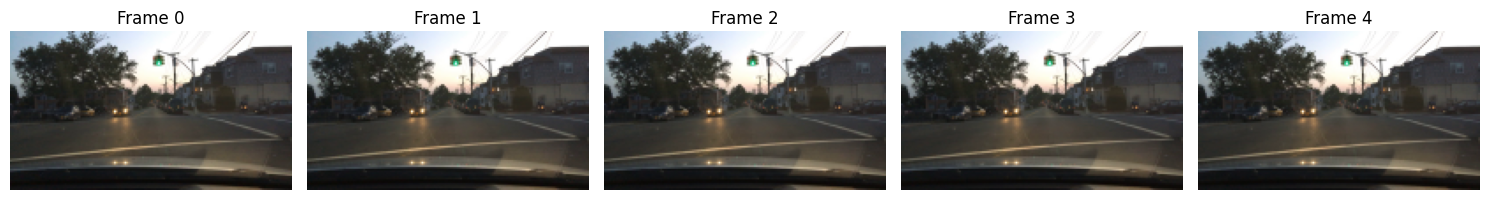

In [43]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your H5 file (adjust if needed)
h5_path = os.path.join(os.getcwd(), "frame_pairs.h5")

# Open the H5 file and inspect the available datasets
with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    
    # Assuming the original inputs are stored under the key 'inputs_original'
    inputs = f['inputs_original']
    print("Inputs shape:", inputs.shape)  # Expected shape: (N, 3, 90, 160)
    
    num_samples = 5  # Number of frames to display
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        # Get the i-th frame; shape: (3, 90, 160)
        frame = inputs[i]
        # Transpose to (90, 160, 3) for display
        frame_disp = np.transpose(frame, (1, 2, 0))
        
        # Check the data type and range:
        if np.issubdtype(frame_disp.dtype, np.floating):
            # If data is float and maximum value is greater than 1, assume it's in [0,255] and normalize
            if frame_disp.max() > 1:
                frame_disp = frame_disp / 255.0
        else:
            # If the data is of an integer type but not uint8, convert it to uint8.
            frame_disp = frame_disp.astype(np.uint8)
        
        axes[i].imshow(frame_disp)
        axes[i].axis('off')
        axes[i].set_title(f"Frame {i}")
    
    plt.tight_layout()
    plt.show()
